In [63]:
import os
import timeit
import  matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import numpy as np
import sklearn as sklearn
import seaborn as sns
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from numba import jit
from tqdm import tqdm
from scipy.spatial import distance_matrix
from sklearn.metrics import mean_squared_error

In [64]:
@jit(nopython=True, cache = True)
def alternate_variogram_compiled(X,Y,Z,width,leng,direction = 45,theta_tolerance = 22.5) :
    n=len(X)
    nlag=np.int((leng/width)) # 25, nombre de lag généré, fiw : "Round to nearest integer towards zero"
    dist=[]
    for kk in np.arange(0,nlag,1): # génération de point 0:1:nlag
        dist.append(width+width*(kk)) # pré-allocation des valeurs de distance pour chaque lag
    leng=dist[nlag-1] # distance maximale, valeur du dernier lag
    dev=np.zeros(nlag)
    counts=np.zeros(nlag);    
    n=len(X)
    #theta_tolerance = 22.5
    #direction       = 45
    
    for ii in np.arange(0,n):
        if ii % 10000 == 0 :
            print("Iteration",ii,"/",n)
        for jj in np.arange(ii,n): # 
            xi=X[ii] # xi
            yi=Y[ii]
            zi=Z[ii] # Zi, Observation value
            xj=X[jj] # xi+h, h = distance lag
            yj=Y[jj]
            zj=Z[jj] # Zi+h
            x = xj-xi
            y = yj-yi
            r   = np.sqrt((x)**2+(y)**2) # distance euclidienne
            tht = np.arctan2(y,x) * (180/np.pi)
            
            if tht < 0 :
                tht = 180 + 180-np.absolute(tht) # permet de varier de 0° -> 360°
            
            if(r<leng) and zi != np.nan and zj != np.nan :
                # Ajout de la directionalité 
                
                if (direction + theta_tolerance) < 360 and (direction - theta_tolerance) > 0  :
                    if ((tht >= (direction - theta_tolerance)) and (tht <= (direction + theta_tolerance))) or ((tht >= (direction - theta_tolerance)+180) and (tht <= (direction + theta_tolerance)+180)) :
                        index=np.int((r/width))  # chaque distance/width est associée à un index,
                    # permet de regrouper les valeurs entre elles (paires), ex : distance/width = 2.9-> 2, etc etc
                        dev[index]=dev[index]+(zi-zj)**2 
                        counts[index]=counts[index]+1
                        
                elif (direction + theta_tolerance) > 360 :   
                    if tht >= (direction) or tht <= (0 + (theta_tolerance-(360-direction))) :
                        index=np.int((r/width)) 
                        dev[index]=dev[index]+(zi-zj)**2 
                        counts[index]=counts[index]+1
                else :
                    if (tht >= (360 - np.absolute(theta_tolerance - direction ))) or (tht <= (direction  + theta_tolerance)):
                        index=np.int((r/width))
                        dev[index]=dev[index]+(zi-zj)**2 
                        counts[index]=counts[index]+1
        
            
    gam = np.divide(dev,2*counts)
        
    return dist, counts, gam

# Mise en place du cas synthétique

In [65]:
def fun_Primary(x,y,mu,sigma,size):
    field_z    = np.cos(y)** 2 * np.sin(x**2) +np.random.normal(mu, sigma, (size,  size))  # Fonction 2D test 
    
    return field_z

def fun_Secondary(x,y,mu,sigma,size):
    field_y    = np.cos(y)** 2 * np.sin(x**2) +np.random.normal(mu, sigma, (size,  size)) *np.exp(x/2)  # Fonction 2D test 

    
    return field_y


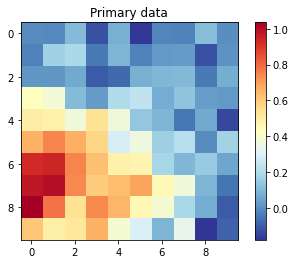

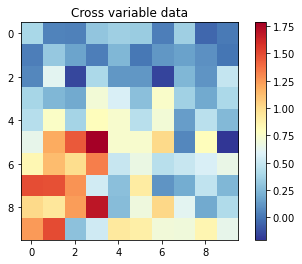

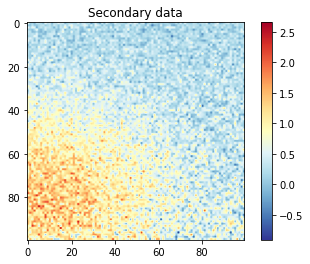

In [66]:
# Primary Data générées (Z)
x_original,y_original = np.mgrid[0:0.5 * np.pi:10j,0:0.5 * np.pi:10j]
# Secondary Data générées (Y)
xx_original, yy_original = np.mgrid[0:0.5 * np.pi:100j, 0:0.5 * np.pi:100j]
# coordinates from 1 -> 100 
xx_z, yy_z  = np.mgrid[0:100:10, 0:100:10]
xx_y, yy_y = np.mgrid[0:100, 0:100]

# Setup Random Noise
np.random.seed(21)
mu_z, sigma_z = 0, 0.1
mu_y, sigma_y = 0.2, 0.2

#Primary Data
_field_z    = fun_Primary(x_original,y_original,mu_z,sigma_z,size = 10)
_field_zy   = fun_Secondary(x_original,y_original,mu = mu_y,sigma = sigma_y,size = 10) 


#Secondary Data
_field_y   = fun_Secondary(xx_original,yy_original,mu = mu_y,sigma = sigma_y,size = 100)

# Quick view 
figg = plt.imshow(_field_z, cmap='RdYlBu_r')
plt.title('Primary data')
plt.colorbar(figg)
plt.show()
figg = plt.imshow(_field_zy, cmap='RdYlBu_r')
plt.title('Cross variable data')
plt.colorbar(figg)
plt.show()
figg = plt.imshow(_field_y, cmap='RdYlBu_r')
plt.title('Secondary data')
plt.colorbar(figg)



In [67]:
# Conversion en dataframe
Primary = pd.DataFrame()
Primary["X"] = xx_z.reshape(-1)
Primary["Y"] = yy_z.reshape(-1)
Primary["original_z"] = _field_z.reshape(-1)
Primary["original_zy"] = _field_zy.reshape(-1)
original_std_z = Primary["original_z"].std()
original_mean_z = Primary["original_z"].mean()
Primary["Primary"] = (Primary["original_z"] - Primary["original_z"].mean()) / Primary["original_z"].std()
Primary["Secondary"] = (Primary["original_zy"] - Primary["original_zy"].mean()) / Primary["original_zy"].std()

In [68]:
# Conversion en dataframe
Secondary = pd.DataFrame()
Secondary["X"] = xx_y.reshape(-1)
Secondary["Y"] = yy_y.reshape(-1)
Secondary["original_y"] = _field_y.reshape(-1)
original_std_y = Secondary["original_y"].std()
original_mean_y = Secondary["original_y"].mean()
Secondary["Secondary"] = (Secondary["original_y"] - Secondary["original_y"].mean()) / Secondary["original_y"].std()

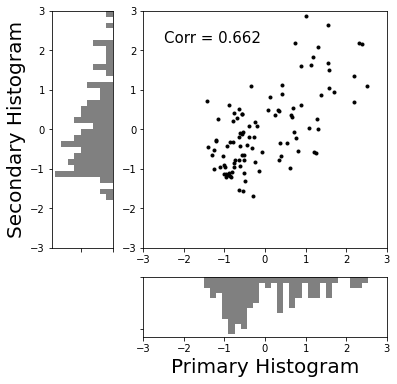

In [69]:
# Set up the axes with gridspec
corr = np.corrcoef(Primary["Primary"], Primary["Secondary"])[0, 1]
vlim = (-3, 3)
fig = plt.figure(figsize=(6, 6))
grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.5)
main_ax = fig.add_subplot(grid[:-1, 1:])
y_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main_ax)
x_hist = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharex=main_ax)

# scatter points on the main axes
main_ax.plot(Primary["Primary"], Primary["Secondary"], "ok", markersize=3)
main_ax.set_xlim(vlim)
main_ax.set_ylim(vlim)
main_ax.text(-2.5, 2.2,
    "Corr = {0:.3f}".format(
        np.corrcoef(Primary["Primary"], Primary["Secondary"])[0, 1]
    ),
    size=15
)

# histogram on the attached axes
x_hist.hist(
    Primary["Primary"],
    40,
    histtype="stepfilled",
    label="Primary",
    orientation="vertical",
    color="gray",
    range=vlim,
)
x_hist.set_xlabel("Primary Histogram", size=20)
x_hist.invert_yaxis()


y_hist.hist(
    Primary["Secondary"],
    40,
    histtype="stepfilled",
    orientation="horizontal",
    color="gray",
    range=vlim,
)
y_hist.set_ylabel("Secondary Histogram", size=20)
y_hist.invert_xaxis()


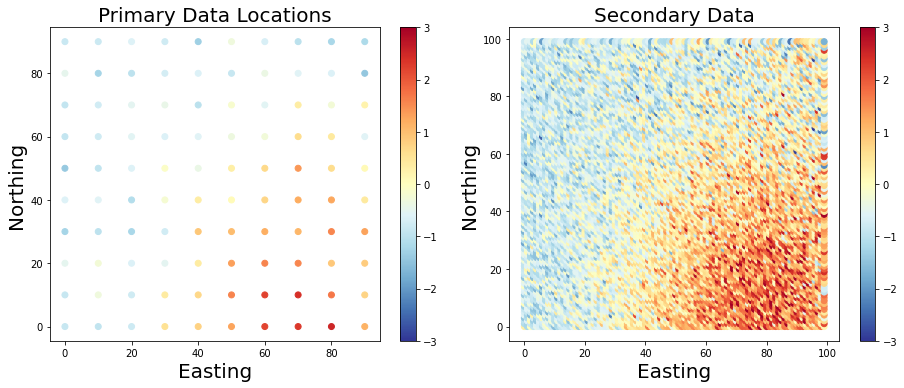

In [70]:

f, ax = plt.subplots(1, 2, figsize=(13, 5.5))
gridded = np.reshape(
    Secondary.sort_values(by=["X", "Y"], axis=0, ascending=True)[
        "Secondary"
    ].values,
    [100, 100],
    order="C",
) # not used

img0 = ax[0].scatter(Primary["X"], Primary["Y"], c=Primary["Primary"].values,
                     vmin = -3,vmax = 3,cmap = "RdYlBu_r")
ax[0].set_title("Primary Data Locations", size=20)
ax[0].set_xlabel("Easting", size=20)
ax[0].set_ylabel("Northing", size=20)
#ax[0].set(xlim=(XMIN, XMAX), ylim=(YMIN, YMAX))

img1 = ax[1].scatter(Secondary["X"], Secondary["Y"], c=Secondary["Secondary"].values,
                     vmin = -3,vmax = 3,cmap = "RdYlBu_r")
ax[1].set_xlabel("Easting", size=20)
ax[1].set_ylabel("Northing", size=20)
ax[1].set_title("Secondary Data", size=20)
f.colorbar(img0, ax=ax[0])
f.colorbar(img1, ax=ax[1])
plt.tight_layout()

# Variogrammes

## Secondary 

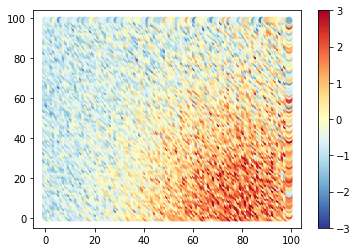

In [71]:
img1 = plt.scatter(Secondary["X"], Secondary["Y"], c=Secondary["Secondary"].values,
                   vmin = -3,vmax = 3,cmap = "RdYlBu_r")
plt.colorbar(img1)

In [72]:
X = Secondary["X"].astype(float).values
Y = Secondary["Y"].astype(float).values
Z = Secondary["Secondary"].astype(float).values
original_std_y = Secondary["original_y"].std()
original_mean_y = Secondary["original_y"].mean()
print("size X :", len(X))
print("size Y :", len(Y))
print("size Z :", len(Z))

size X : 10000
size Y : 10000
size Z : 10000


In [73]:
L=(max(X)-min(X))*1/2 # distance maximale
print("max x :", max(X), " \t Distance maximale retenue :",L)
w = 1.0 # width, taille des lags
print("nlag :" , np.int(np.fix(L/w)))

max x : 99.0  	 Distance maximale retenue : 49.5
nlag : 49


In [74]:
direction = [0,45,90,135] 
angle_tolerance = 22.5
dist, counts, gam = {}, {}, {}

for Dir in direction :
    st1 = timeit.default_timer()
    dist[Dir], counts[Dir], gam[Dir] = alternate_variogram_compiled(X,Y,Z,w,L,Dir,angle_tolerance)
    print("direction done :", Dir)
    st2 = timeit.default_timer()
    print("RUN TIME : {0}".format(st2-st1))

Iteration 0 / 10000
direction done : 0
RUN TIME : 5.452278900003876
Iteration 0 / 10000
direction done : 45
RUN TIME : 3.27429139999731
Iteration 0 / 10000
direction done : 90
RUN TIME : 2.929335599998012
Iteration 0 / 10000
direction done : 135
RUN TIME : 3.107531600006041


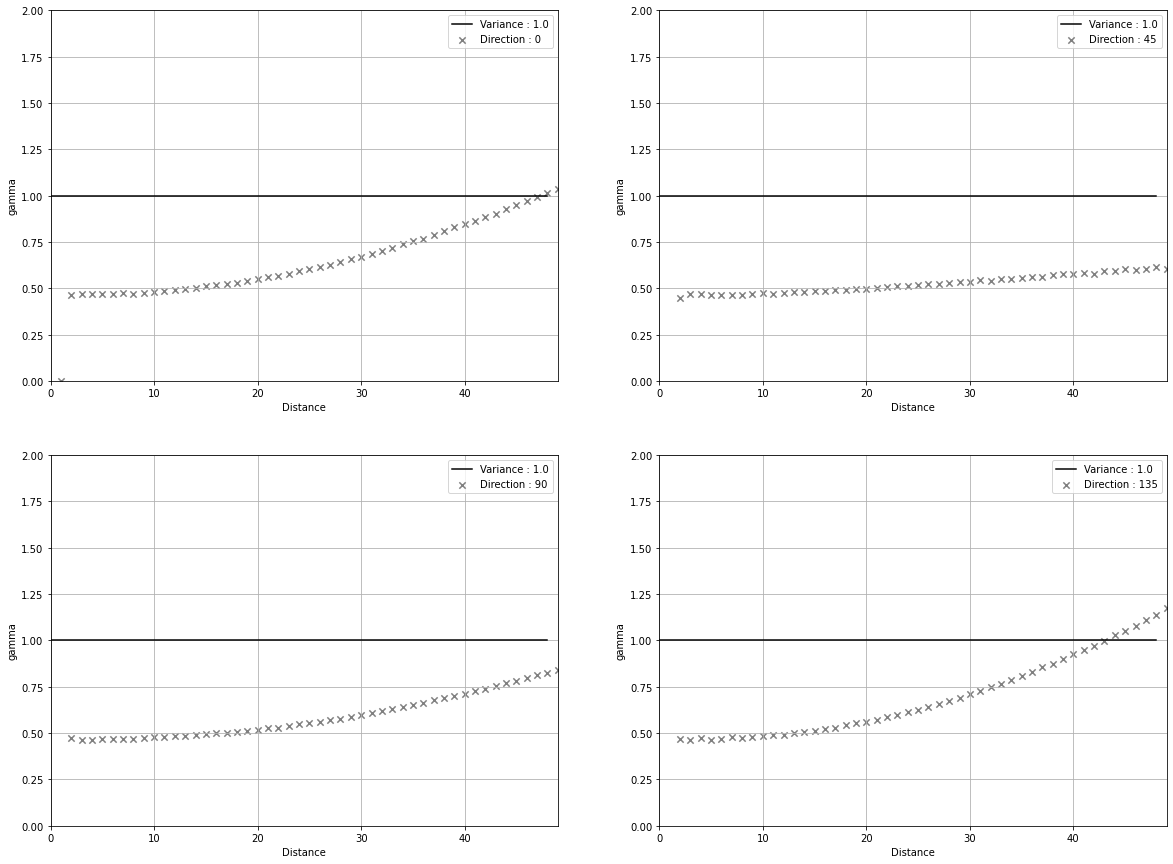

In [75]:
var_y = float("{:.2f}".format(Z.var()))
ones = np.ones(shape=(int(L))) * var_y
H    = np.arange(0,int(L))
fig,ax=plt.subplots(2,2,figsize = (20,15))
ii = 0
jj = 0
for Dir in direction : 
    dist_dir = dist[Dir]
    gam_dir = gam[Dir]
    ax[ii,jj].scatter(dist_dir,gam_dir,40,marker = 'x',color = "grey",label = str("Direction : " + str(Dir)))
    ax[ii,jj].plot(H,ones,"black", label = "Variance : " + str(var_y))
    ax[ii,jj].set_xlabel('Distance')
    ax[ii,jj].set_ylabel('gamma')
    ax[ii,jj].grid()
    ax[ii,jj].legend()
    ax[ii,jj].set_ylim([0,2])
    ax[ii,jj].set_xlim([0,max(dist_dir)])
    jj += 1
    if jj == 2 :
        ii += 1
        jj = 0

In [76]:
## MAJOR DIRECTION / MINOR DIRECTION :
Direction = {"Major" : 0,
            "Minor" : 90,
            }

In [77]:
for direction in dist :
    if direction == Direction["Major"] :
        index_major = np.ones((1,len(dist[direction])))
        dist_major  = dist[direction]
        gam_major   = gam[direction]
        count_major = counts[direction]
    elif direction == Direction["Minor"] :
        index_minor = np.ones((1,len(dist[direction]))) * 2
        dist_minor  = dist[direction]
        gam_minor   = gam[direction]
        count_minor = counts[direction]
        
index_array = np.append(index_major,index_minor)
dist_array  = np.append(dist_major,dist_minor)
gam_array   = np.append(gam_major,gam_minor)
count_array   = np.append(count_major,count_minor)

varc_2 = pd.DataFrame()
varc_2["Lag Distance"] = dist_array
varc_2["Number of Pairs"] = count_array
varc_2["Variogram Value"] = gam_array
varc_2["Variogram Index"] = index_array 
varc_2 = varc_2.loc[varc_2["Variogram Value"] != 0]
varc_2 = varc_2.dropna(axis = 0)

In [78]:
varc_2.head()

Lag Distance  Number of Pairs  Variogram Value  Variogram Index
1           2.0           9900.0         0.465788              1.0
2           3.0           9800.0         0.469455              1.0
3           4.0          28906.0         0.467375              1.0
4           5.0          28608.0         0.467069              1.0
5           6.0          46930.0         0.467651              1.0

In [79]:
varc_2.head()

Lag Distance  Number of Pairs  Variogram Value  Variogram Index
1           2.0           9900.0         0.465788              1.0
2           3.0           9800.0         0.469455              1.0
3           4.0          28906.0         0.467375              1.0
4           5.0          28608.0         0.467069              1.0
5           6.0          46930.0         0.467651              1.0

In [80]:
#Secondary.to_csv("cas_synthetique.csv")

## Primary 

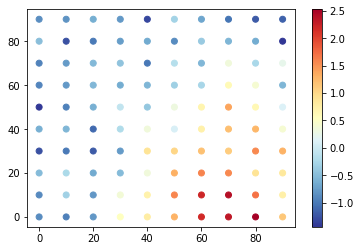

In [81]:
img0 = plt.scatter(Primary["X"], Primary["Y"], c=Primary["Primary"].values,cmap = "RdYlBu_r")
plt.colorbar(img0)

In [82]:
X = Primary["X"].astype(float).values
Y = Primary["Y"].astype(float).values
Z = Primary["Primary"].astype(float).values
original_std_y = Primary["original_z"].std()
original_mean_y = Primary["original_z"].mean()
print("size X :", len(X))
print("size Y :", len(Y))
print("size Z :", len(Z))

size X : 100
size Y : 100
size Z : 100


#### estimation de la distance maximale à retenir

In [83]:
distance_variable = 0
for i in range(0,len(X)) :
    for j in range (0,len(X)) :
        x = X[i] - X[j]
        y = Y[i] - Y[j]
        dist_temp = np.sqrt((x)**2+(y)**2) # distance euclidienne
        if dist_temp > distance_variable :
            distance_variable = dist_temp
        
print("distance maximale:", distance_variable)

distance maximale: 127.27922061357856


In [84]:
L=(max(X)-min(X))*2/3 # distance maximale
print("max x :", max(X), " \t Distance maximale retenue :",L)
w = 10.0 # width, taille des lags
print("nlag :" , np.int(np.fix(L/w)))

max x : 90.0  	 Distance maximale retenue : 60.0
nlag : 6


In [85]:
direction = [0,45,90,135]
angle_tolerance = 22.5
dist, counts, gam = {}, {}, {}

for Dir in direction :
    st1 = timeit.default_timer()
    dist[Dir], counts[Dir], gam[Dir] = alternate_variogram_compiled(X,Y,Z,w,L,Dir,angle_tolerance)
    print("direction done :", Dir)
    st2 = timeit.default_timer()
    print("RUN TIME : {0}".format(st2-st1))

Iteration 0 / 100
direction done : 0
RUN TIME : 0.0008267999946838245
Iteration 0 / 100
direction done : 45
RUN TIME : 0.0010146999993594363
Iteration 0 / 100
direction done : 90
RUN TIME : 0.0005862999969394878
Iteration 0 / 100
direction done : 135
RUN TIME : 0.0004639999970095232


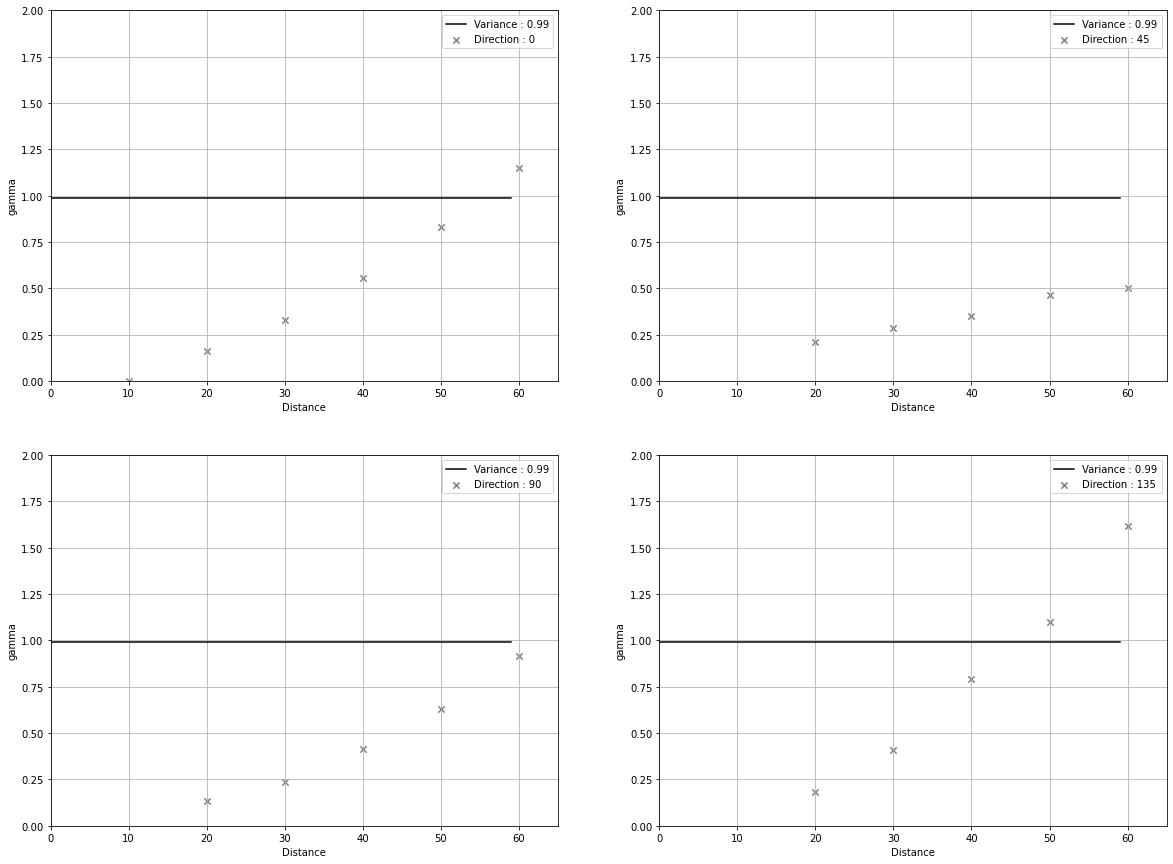

In [86]:
var_z = float("{:.2f}".format(Z.var()))
ones = np.ones(shape=(int(L))) * var_z
H    = np.arange(0,int(L))
fig,ax=plt.subplots(2,2,figsize = (20,15))
ii = 0
jj = 0
for Dir in direction : 
    dist_dir = dist[Dir]
    gam_dir = gam[Dir]
    ax[ii,jj].scatter(dist_dir,gam_dir,40,marker = 'x',color = "grey",label = str("Direction : " + str(Dir)))
    ax[ii,jj].plot(H,ones,"black", label = "Variance : " + str(var_z))
    ax[ii,jj].set_xlabel('Distance')
    ax[ii,jj].set_ylabel('gamma')
    ax[ii,jj].grid()
    ax[ii,jj].legend()
    ax[ii,jj].set_ylim([0,2])
    ax[ii,jj].set_xlim([0,max(dist_dir)+5])
    jj += 1
    if jj == 2 :
        ii += 1
        jj = 0

In [87]:
## MAJOR DIRECTION / MINOR DIRECTION :
Direction = {"Major" : 0,
            "Minor" : 90,
            }

In [88]:
for direction in dist :
    if direction == Direction["Major"] :
        index_major = np.ones((1,len(dist[direction])))
        dist_major  = dist[direction]
        gam_major   = gam[direction]
        count_major = counts[direction]
    elif direction == Direction["Minor"] :
        index_minor = np.ones((1,len(dist[direction]))) * 2
        dist_minor  = dist[direction]
        gam_minor   = gam[direction]
        count_minor = counts[direction]
        
index_array = np.append(index_major,index_minor)
dist_array  = np.append(dist_major,dist_minor)
gam_array   = np.append(gam_major,gam_minor)
count_array   = np.append(count_major,count_minor)

varc_1 = pd.DataFrame()
varc_1["Lag Distance"] = dist_array
varc_1["Number of Pairs"] = count_array
varc_1["Variogram Value"] = gam_array
varc_1["Variogram Index"] = index_array 
varc_1 = varc_1.loc[varc_1["Variogram Value"] != 0]
varc_1 = varc_1.dropna(axis = 0)

In [89]:
varc_1

Lag Distance  Number of Pairs  Variogram Value  Variogram Index
1           20.0             90.0         0.161317              1.0
2           30.0             80.0         0.331954              1.0
3           40.0            196.0         0.555955              1.0
4           50.0            168.0         0.832189              1.0
5           60.0            220.0         1.152178              1.0
7           20.0             90.0         0.135233              2.0
8           30.0             80.0         0.238507              2.0
9           40.0            196.0         0.415188              2.0
10          50.0            168.0         0.630162              2.0
11          60.0            220.0         0.918280              2.0

In [90]:
Primary.to_csv("./cas synthetique/cas_synthetique_primary.csv")

## Cross 

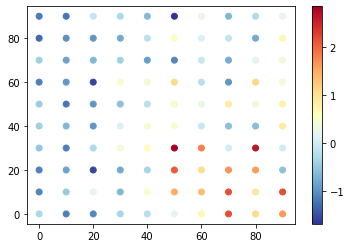

In [91]:
img0 = plt.scatter(Primary["X"], Primary["Y"], c=Primary["Secondary"].values,cmap = "RdYlBu_r")
plt.colorbar(img0)

In [92]:
X = Primary["X"].astype(float).values
Y = Primary["Y"].astype(float).values
Z = Primary["Secondary"].astype(float).values
print("size X :", len(X))
print("size Y :", len(Y))
print("size Z :", len(Z))

size X : 100
size Y : 100
size Z : 100


#### estimation de la distance maximale à retenir

In [93]:
distance_variable = 0
for i in range(0,len(X)) :
    for j in range (0,len(X)) :
        x = X[i] - X[j]
        y = Y[i] - Y[j]
        dist_temp = np.sqrt((x)**2+(y)**2) # distance euclidienne
        if dist_temp > distance_variable :
            distance_variable = dist_temp
        
print("distance maximale:", distance_variable)

distance maximale: 127.27922061357856


In [94]:
L=(max(X)-min(X))*2/3 # distance maximale
print("max x :", max(X), " \t Distance maximale retenue :",L)
w = 10.0 # width, taille des lags
print("nlag :" , np.int(np.fix(L/w)))

max x : 90.0  	 Distance maximale retenue : 60.0
nlag : 6


In [95]:
direction = [0,45,90,135]
angle_tolerance = 22.5
dist, counts, gam = {}, {}, {}

for Dir in direction :
    st1 = timeit.default_timer()
    dist[Dir], counts[Dir], gam[Dir] = alternate_variogram_compiled(X,Y,Z,w,L,Dir,angle_tolerance)
    print("direction done :", Dir)
    st2 = timeit.default_timer()
    print("RUN TIME : {0}".format(st2-st1))

Iteration 0 / 100
direction done : 0
RUN TIME : 0.0009222999942721799
Iteration 0 / 100
direction done : 45
RUN TIME : 0.00420260000100825
Iteration 0 / 100
direction done : 90
RUN TIME : 0.001508699991973117
Iteration 0 / 100
direction done : 135
RUN TIME : 0.00046520000614691526


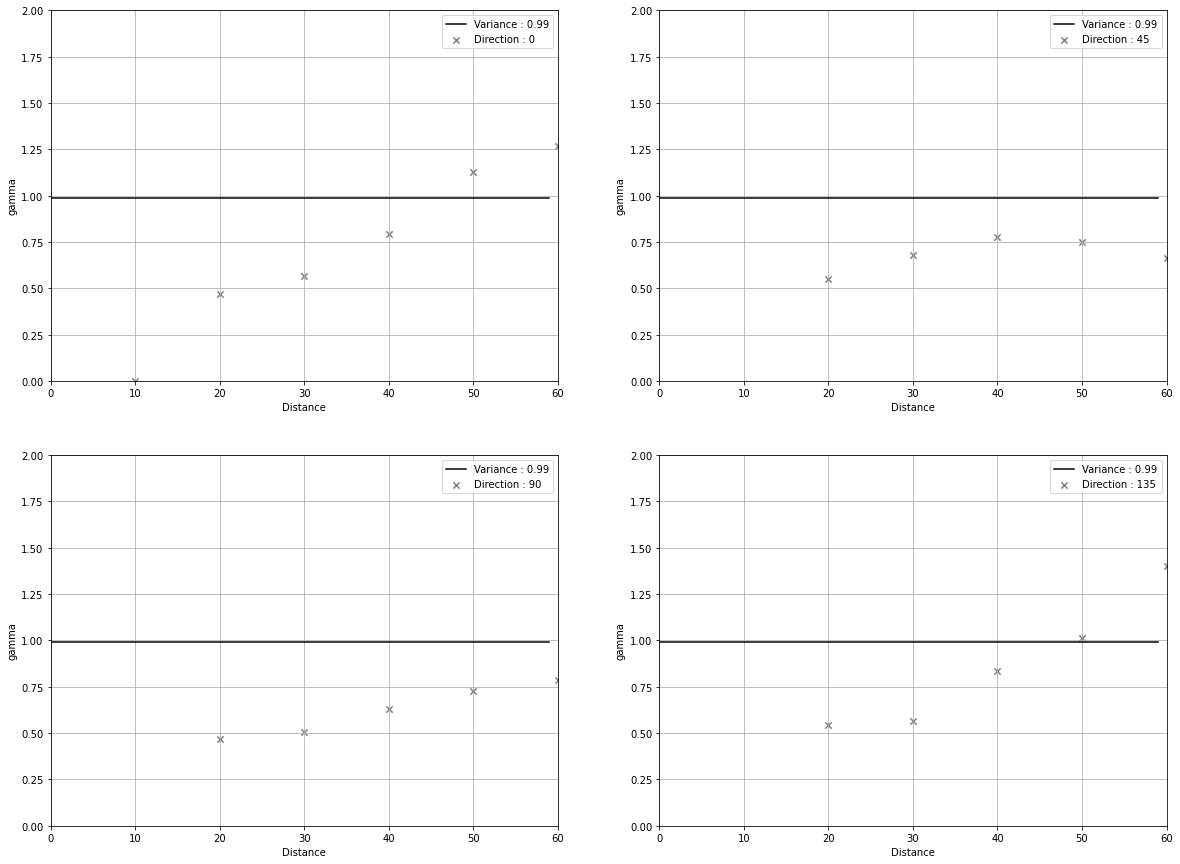

In [96]:
var_z = float("{:.2f}".format(Z.var()))
ones = np.ones(shape=(int(L))) * var_z
H    = np.arange(0,int(L))
fig,ax=plt.subplots(2,2,figsize = (20,15))
ii = 0
jj = 0
for Dir in direction : 
    dist_dir = dist[Dir]
    gam_dir = gam[Dir]
    ax[ii,jj].scatter(dist_dir,gam_dir,40,marker = 'x',color = "grey",label = str("Direction : " + str(Dir)))
    ax[ii,jj].plot(H,ones,"black", label = "Variance : " + str(var_z))
    ax[ii,jj].set_xlabel('Distance')
    ax[ii,jj].set_ylabel('gamma')
    ax[ii,jj].grid()
    ax[ii,jj].legend()
    ax[ii,jj].set_ylim([0,2])
    ax[ii,jj].set_xlim([0,max(dist_dir)])
    jj += 1
    if jj == 2 :
        ii += 1
        jj = 0

In [97]:
## MAJOR DIRECTION / MINOR DIRECTION :
Direction = {"Major" : 0,
            "Minor" : 90,
            }

In [98]:
for direction in dist :
    if direction == 0 :
        index_major = np.ones((1,len(dist[direction])))
        dist_major  = dist[direction]
        gam_major   = gam[direction]
        count_major = counts[direction]
    elif direction == 90 :
        index_minor = np.ones((1,len(dist[direction]))) * 2
        dist_minor  = dist[direction]
        gam_minor   = gam[direction]
        count_minor = counts[direction]
        
index_array = np.append(index_major,index_minor)
dist_array  = np.append(dist_major,dist_minor)
gam_array   = np.append(gam_major,gam_minor)
count_array   = np.append(count_major,count_minor)

varc_3 = pd.DataFrame()
varc_3["Lag Distance"] = dist_array
varc_3["Number of Pairs"] = count_array
varc_3["Variogram Value"] = gam_array
varc_3["Variogram Index"] = index_array 
varc_3 = varc_3.loc[varc_3["Variogram Value"] != 0]
varc_3 = varc_3.dropna(axis = 0)

In [99]:
varc_3

Lag Distance  Number of Pairs  Variogram Value  Variogram Index
1           20.0             90.0         0.471026              1.0
2           30.0             80.0         0.568120              1.0
3           40.0            196.0         0.794188              1.0
4           50.0            168.0         1.130278              1.0
5           60.0            220.0         1.266938              1.0
7           20.0             90.0         0.465832              2.0
8           30.0             80.0         0.508651              2.0
9           40.0            196.0         0.632482              2.0
10          50.0            168.0         0.728800              2.0
11          60.0            220.0         0.786131              2.0

# Correlogramme Model

In [100]:
def covar(t, d, r):
    h = d / r
    if t == 1:  # Spherical
        c = (1 - h * (1.5 - 0.5 * np.square(h)))
        c[h > 1] = 0
    elif t == 2:  # Exponential
        c = (np.exp(-3 * h))
    elif t == 3:  # Gaussian
        c = (np.exp(-3 * np.square(h)))
    return c

In [101]:
def Rot_Mat(Azimuth, a_max, a_min):
    theta = (Azimuth / 180.0) * np.pi
    Rot_Mat = np.dot(
        np.array([[1 / a_max, 0], [0, 1 / a_min]]),
        np.array(
            [
                [np.cos(theta), np.sin(theta)],
                [-np.sin(theta), np.cos(theta)],
            ]
        ),
    )
    return Rot_Mat

In [102]:
## Define some matrices for storing variogram values
LENGTH = 150
cy = np.zeros(shape=(LENGTH + 1))
cz_True = np.zeros(shape=(LENGTH + 1))
cr = np.zeros(shape=(LENGTH + 1))
cz = np.zeros(shape=(LENGTH + 1))
czy = np.zeros(shape=(LENGTH + 1))
H = np.zeros(shape=(LENGTH + 1))
ones = np.zeros(shape=(LENGTH + 1))
Sill_vals = [1,1,corr] ## !!

### Plottting labels 
colors = ["Red", "Green","Blue"]
labels_2 = ["$\u03C1_{z}$", "$\u03C1_{y}$", "$\u03C1_{zy}$"]

Corr_labels = [
    "Primary Correlogram",
    "Secondary Correlogram",
    "Cross Correlogram"]

labels_1 = [
    "$\hat{\u03C1_{z}}$",
    "$\hat{\u03C1_{y}}$",
    "$\hat{\u03C1_{zy}}$",
]
labels_MM = [
    "$\u03C1_{z_{Model}}$",
    "$\u03C1_{y_{Model}}$",
    "$\u03C1_{z_{MMII}}$",
]

Cross_ones = np.zeros(shape=(101))


## Primary

In [103]:
# h1 = Set of points X,Y
# h2 = Set of points X,Y
# k = 0 used for calculating the distance between the same points
# k = 1 used for calculationg distance between different points
# k = 2 used for plotting in the major direction
# k = 3 used for plotting in the minor direction
def C_Z_alternate(h1, h2, k,dict_C_Z,nstruct = 1,Azimuth = 0):
    C = []
    #nstruct = 1
    vtype = dict_C_Z["vtype"]
    a_max = dict_C_Z["a_max"]
    a_min = dict_C_Z["a_min"] 
    cc = dict_C_Z["cc"]
    #Azimuth = 45
    c = 0
    #print(vtype,a_max,a_min,cc)
    for i in range(nstruct):
        Q1 = h1.copy()
        Q2 = h2.copy()
        if k == 0:
            d = distance_matrix(
                np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])),
                np.matmul(Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])),
            )
        elif k == 1:
            d = np.sqrt(
                np.square(
                    (np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])))
                    - np.tile(
                        (
                            np.matmul(
                                Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])
                            )
                        ),
                        (k, 1),
                    )
                ).sum(axis=1)
            )
            d = np.asarray(d).reshape(len(d))
        elif k == 2:
            d = Q1 / a_max[i]
        elif k == 3:
            d = Q1 / a_min[i]
        c = c + covar(vtype[i], d, 1) * cc[i] 
    return c

In [104]:
def optimize_RMSE_Z_model(x, args):
    """
    args : args[0] correspond au DataFrame ; args[1] à la Sill_value
    gamma= b*spherical(a_min,a_max)
    pour un modèle à plusieur couche => inserer en tant que list : a_max = [a_max1,a_max2]
    """
    
    var = args[0][args[0]["Variogram Value"] != -999]
    Sill_value = args[1] # Variance des données
    RMSE = [] # Liste des valeurs RMSE
    Direction = ["Major","Minor"]
    
    ## x0
    if len(x0) == 3 :
        a_max_z_0 = [x[0]]         # range
        a_min_z_0 = [x[1]]
        cc_z_0 = [x[2]]            # effet pépite
        MODEL_value = [args[2]]  # type de modèle
        nstruct = 1
        
    else : # modèle plus complexe à plusieurs "couches" 
        
        a_max_z_0 = x[0::3]        # range
        a_min_z_0 = x[1::3]
        cc_z_0 = x[2::3]           # effet pépite
        MODEL_value = args[2::]      # type de modèle
        nstruct = len(MODEL_value) # nombre de couche
    
    dict_primary_0 = {"a_max" : a_max_z_0
                ,"a_min" : a_min_z_0
                ,"cc" : cc_z_0
                ,"vtype" : MODEL_value
                 }
    
    print(dict_primary_0)
    for i,Dir in enumerate(Direction) :
        k = 2+i
        c = [] # liste des covario  
        
        variogram_lag = var["Lag Distance"][var["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        variogram_value = Sill_value - var["Variogram Value"][var["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        lag_value = variogram_lag # valeurs des lags
        
        
        for h in lag_value:
            MODEL = C_Z_alternate(np.matrix(h), np.matrix(h), k, dict_primary_0,nstruct)
            
            c.append(MODEL.tolist()[0][0]) # convertion np.matrix to float
        RMSE.append(np.sqrt(mean_squared_error(variogram_value,c)))
    #print("vario :", variogram_value.values)
    #print("c :", c)
    print("RMSE :",RMSE, "\n")
        
    return sum(RMSE)

In [229]:
MODEL_type ={"Spherical" : 1,
        "Exponential" : 2,
        "Gaussien" : 3}

# Allocation des valeurs initiales

# range max, min, effet pepite, type de couche
a_max_z_0 = np.array([80])
a_min_z_0 = np.array([80])
cc_z_0    = np.array([0.8])
MODEL_value = np.array([MODEL_type["Spherical"]])


var, Sill_value,= varc_1, Sill_vals[0] # variogram , Variance
nstruct = len(a_max_z_0) # nstruct, nombre de couche

x0,args = np.empty(1),np.empty(1)
#x0 = np.array([a_max_z_0,a_min_z_0, cc_z_0,MODEL_value])
args = np.append(args,[var,Sill_value])

for i in np.arange(nstruct) : # permet de minimiser un modèle à plusieur couche   
    a = a_max_z_0[i]
    b = a_min_z_0[i]
    c = cc_z_0[i]
    d = MODEL_value[i]
    x0 = np.append(x0,[a,b,c])
    args = np.append(args,d)
x0 = np.delete(x0,0)
args = np.delete(args,0)



# Boundaries 
Bounds = [[0,150],[0,150],[0,2]]
if nstruct > 1 :
    Bounds *=  len(a_max_z_0)


# Minimize
Z_model = minimize(optimize_RMSE_Z_model,x0,args = args,
                            method='TNC', jac = '3-point',
                            bounds = Bounds,tol = 1e-9)

print(Z_model)

a_max_z = [float("{:.0f}".format(x)) for x in Z_model.x[0::3]]
a_min_z = [float("{:.0f}".format(x)) for x in Z_model.x[1::3]]
cc_z = [float("{:.2f}".format(x)) for x in Z_model.x[2::3]]

dict_primary = {"a_max" : a_max_z
                ,"a_min" : a_min_z
                ,"cc" : cc_z
                ,"vtype" : MODEL_value,
                "nstruct" : nstruct
}

{'a_max': [80.0], 'a_min': [80.0], 'cc': [0.8], 'vtype': [1]}
RMSE : [0.23898173379460488, 0.29751595204620346] 

{'a_max': [79.99951556364381], 'a_min': [80.0], 'cc': [0.8], 'vtype': [1]}
RMSE : [0.2389828379396762, 0.29751595204620346] 

{'a_max': [80.00048443635619], 'a_min': [80.0], 'cc': [0.8], 'vtype': [1]}
RMSE : [0.23898062968538267, 0.29751595204620346] 

{'a_max': [80.0], 'a_min': [79.99951556364381], 'cc': [0.8], 'vtype': [1]}
RMSE : [0.23898173379460488, 0.29751802453703796] 

{'a_max': [80.0], 'a_min': [80.00048443635619], 'cc': [0.8], 'vtype': [1]}
RMSE : [0.23898173379460488, 0.297513879578072] 

{'a_max': [80.0], 'a_min': [80.0], 'cc': [0.7999939445455476], 'vtype': [1]}
RMSE : [0.23898372787805744, 0.2975182101297338] 

{'a_max': [80.0], 'a_min': [80.0], 'cc': [0.8000060554544525], 'vtype': [1]}
RMSE : [0.23897973971767428, 0.2975136939641386] 

{'a_max': [80.00000084864242], 'a_min': [80.00000159292705], 'cc': [0.8000000464818076], 'vtype': [1]}
RMSE : [0.238981716553

RMSE : [0.10211256442618118, 0.09030267479325894] 

{'a_max': [69.47208726905392], 'a_min': [78.3626466859841], 'cc': [1.53125], 'vtype': [1]}
RMSE : [0.1021126698263415, 0.09030267479325894] 

{'a_max': [69.47292864426917], 'a_min': [78.3626466859841], 'cc': [1.53125], 'vtype': [1]}
RMSE : [0.10211245925382466, 0.09030267479325894] 

{'a_max': [69.47250795666154], 'a_min': [78.36217216454632], 'cc': [1.53125], 'vtype': [1]}
RMSE : [0.10211256442618118, 0.09030499477194101] 

{'a_max': [69.47250795666154], 'a_min': [78.36312120742188], 'cc': [1.53125], 'vtype': [1]}
RMSE : [0.10211256442618118, 0.09030035500716152] 

{'a_max': [69.47250795666154], 'a_min': [78.3626466859841], 'cc': [1.5312407275853697], 'vtype': [1]}
RMSE : [0.10211280957099618, 0.09030318780606432] 

{'a_max': [69.47250795666154], 'a_min': [78.3626466859841], 'cc': [1.5312592724146303], 'vtype': [1]}
RMSE : [0.10211231937448144, 0.09030216191526748] 

{'a_max': [72.59640377321813], 'a_min': [81.20578163826664], 'cc': 

RMSE : [0.10461517061590454, 0.07286393916746005] 

{'a_max': [71.38751283833466], 'a_min': [85.243948615607], 'cc': [1.4652829833913805], 'vtype': [1]}
RMSE : [0.10461432416903789, 0.0728647992073989] 

{'a_max': [71.38751283598012], 'a_min': [85.2439486248142], 'cc': [1.4652741103686409], 'vtype': [1]}
RMSE : [0.10461474735395634, 0.07286436908814824] 

{'a_max': [71.38708055214767], 'a_min': [85.2439486248142], 'cc': [1.4652741103686409], 'vtype': [1]}
RMSE : [0.10461462469483465, 0.07286436908814824] 

{'a_max': [71.38794511981257], 'a_min': [85.2439486248142], 'cc': [1.4652741103686409], 'vtype': [1]}
RMSE : [0.10461487022102807, 0.07286436908814824] 

{'a_max': [71.38751283598012], 'a_min': [85.24343243396595], 'cc': [1.4652741103686409], 'vtype': [1]}
RMSE : [0.10461474735395634, 0.07286448799203923] 

{'a_max': [71.38751283598012], 'a_min': [85.24446481566244], 'cc': [1.4652741103686409], 'vtype': [1]}
RMSE : [0.10461474735395634, 0.07286425046050454] 

{'a_max': [71.3875128359

RMSE : [0.10470265063700798, 0.07271174914552947] 

{'a_max': [71.18877017289103], 'a_min': [85.55646767120369], 'cc': [1.463014590299081], 'vtype': [1]}
RMSE : [0.10470265063700798, 0.0727117526680309] 

{'a_max': [71.18877017289103], 'a_min': [85.5559495910478], 'cc': [1.4630057310808662], 'vtype': [1]}
RMSE : [0.10470314117626334, 0.07271126002494255] 

{'a_max': [71.18877017289103], 'a_min': [85.5559495910478], 'cc': [1.4630234495172958], 'vtype': [1]}
RMSE : [0.1047021601836074, 0.07271224169621564] 

{'a_max': [71.1887701728529], 'a_min': [85.5559495908941], 'cc': [1.463014590300245], 'vtype': [1]}
RMSE : [0.10470265063694346, 0.07271175076922305] 

{'a_max': [71.1883390924976], 'a_min': [85.5559495908941], 'cc': [1.463014590300245], 'vtype': [1]}
RMSE : [0.10470264929662307, 0.07271175076922305] 

{'a_max': [71.1892012532082], 'a_min': [85.5559495908941], 'cc': [1.463014590300245], 'vtype': [1]}
RMSE : [0.10470265218512316, 0.07271175076922305] 

{'a_max': [71.1887701728529], 'a

RMSE : [0.10469824857234823, 0.07271613355256927] 

{'a_max': [71.18427247115444], 'a_min': [85.54974588001382], 'cc': [1.4630939318403682], 'vtype': [1]}
RMSE : [0.10469824830939944, 0.07271613334345538] 

{'a_max': [71.18427247115444], 'a_min': [85.550781971467], 'cc': [1.4630939318403682], 'vtype': [1]}
RMSE : [0.10469824830939944, 0.07271613403694885] 

{'a_max': [71.18427247115444], 'a_min': [85.55026392574041], 'cc': [1.4630850721417044], 'vtype': [1]}
RMSE : [0.104698739136014, 0.07271564311299994] 

{'a_max': [71.18427247115444], 'a_min': [85.55026392574041], 'cc': [1.463102791539032], 'vtype': [1]}
RMSE : [0.10469775756863764, 0.07271662417496803] 

{'a_max': [71.1841992966377], 'a_min': [85.54988139780698], 'cc': [1.4631052136916662], 'vtype': [1]}
RMSE : [0.1046976233746584, 0.07271675798836728] 

{'a_max': [71.18376824396113], 'a_min': [85.54988139780698], 'cc': [1.4631052136916662], 'vtype': [1]}
RMSE : [0.10469762322923656, 0.07271675798836728] 

{'a_max': [71.18463034931

In [106]:
dict_primary

{'a_max': [64.0],
 'a_min': [78.0],
 'cc': [1.14],
 'vtype': array([3]),
 'nstruct': 1}

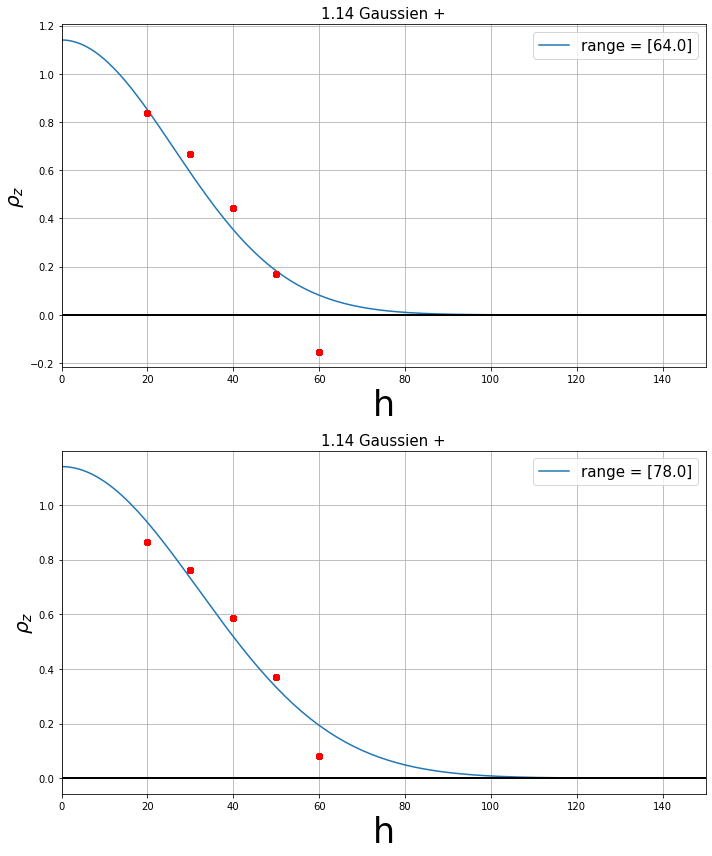

In [107]:
varg_type = 2  # See Correlogram Functions
k = 0 # Permet de changer de direction
nstruct = dict_primary["nstruct"]
MODEL_name ={ 1 : "Spherical",
         2 : "Exponential",
         3 : "Gaussien"}

label_dict = {0: dict_primary["a_max"],
             1 : dict_primary["a_min"]}

# Title name
TITLE = ""
count = 1
for cc,vtype in zip(dict_primary["cc"],dict_primary["vtype"]) :
    model = MODEL_name[vtype]
    if count == 1 :
        TITLE += f"{cc} {model} +" 
    elif count == len(dict_primary["cc"]):
        TITLE += f" {cc} {model} "
    elif count == 1 & len(dict_primary["cc"]) == 1 :
        TITLE += f"{cc} {model}"                    
    else : 
        TITLE += f" {cc} {model} +"
    count += 1

fig, axes = plt.subplots(2,1, figsize=(10, 12))
cz_True = np.zeros(shape=(LENGTH + 1))
for s in range(2) :
    for h in range(0, LENGTH + 1):
        # Calcul Correlogram model Z
        cz_True[h] = C_Z_alternate(np.matrix(h), np.matrix(h),varg_type, dict_primary,nstruct)
        H[h] = h
        MM_vargs = [ cz_True,cy,czy ]

        # Label Display 
    for i in [0]:
        LABEL =  "range = {}".format(label_dict[s])
        axes[s].plot(H, MM_vargs[i], label=LABEL)
        var = locals()["varc_{}".format(i + 1)]

        # Calcul des valeurs de Correlogram à partir du variogram
    for h in range(1, LENGTH):
        H[h] = h
        axes[s].plot(
            var["Lag Distance"][var["Variogram Index"] == (s + 1)],
            Sill_vals[i]
            - var["Variogram Value"][var["Variogram Index"] == (s + 1)],
            "o",
            color=colors[i],
        )
        axes[s].set_ylabel(labels_2[i], size=20)
        axes[s].plot(H, ones, color="Black")
        axes[s].set_xlabel("h", size=35)
        axes[s].set_title(TITLE, size=15)
        axes[s].legend(loc="best", prop={"size": 15})
        axes[s].grid()
    plt.setp(axes, xlim=(0, LENGTH))
    plt.tight_layout()

# Ici pas de direction précise, à inclure dans une loop le cas échéant
    varg_type = varg_type + 1
    k +=1

## Secondary

In [108]:
# h1 = Set of points X,Y
# h2 = Set of points X,Y
# k = 0 used for calculating the distance between the same points
# k = 1 used for calculationg distance between different points
# k = 2 used for plotting in the major direction
# k = 3 used for plotting in the minor direction
def C_Y_alternate(h1, h2, k,dict_C_Y,nstruct = 1,Azimuth = 0):
    C = []
    vtype = dict_C_Y["vtype"]
    a_max = dict_C_Y["a_max"]
    a_min = dict_C_Y["a_min"] 
    cc = dict_C_Y["cc"]
    #Azimuth = 45
    c = 0.0
    for i in range(nstruct):
        Q1 = h1.copy()
        Q2 = h2.copy()
        if k == 0:
            d = distance_matrix(
                np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])),
                np.matmul(Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])),
            )
        elif k == 1:
            d = np.sqrt(
                np.square(
                    (np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])))
                    - np.tile(
                        (
                            np.matmul(
                                Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])
                            )
                        ),
                        (k, 1),
                    )
                )
            ).sum(axis=1)
            d = np.asarray(d).reshape(len(d))
        elif k == 2:
            d = Q1 / a_max[i]
        elif k == 3:
            d = Q1 / a_min[i]
        c = c + covar(vtype[i], d, 1)  * cc[i]

    return c

In [109]:
def optimize_RMSE_Y_model(x, args):
    """
    args : args[0] correspond au DataFrame ; args[1] à la Sill_value
    gamma= b*spherical(a_min,a_max)
    pour un modèle à plusieur couche => inserer en tant que list : a_max = [a_max1,a_max2]
    """
    
    var = args[0][args[0]["Variogram Value"] != -999]
    var = var.dropna(axis = 0)
    Sill_value = args[1] # Variance des données
    RMSE = [] # Liste des valeurs RMSE
    Direction = ["Major","Minor"]
    
    ## x0
    if len(x0) == 3 :
        a_max_y_0 = [x[0]]         # range
        a_min_y_0 = [x[1]]
        cc_y_0 = [x[2]]            # effet pépite
        MODEL_value = [args[2]]  # type de modèle
        nstruct = 1
        
    else : # modèle plus complexe à plusieurs "couches" 
        
        a_max_y_0 = x[0::3]        # range
        a_min_y_0 = x[1::3]
        cc_y_0 = x[2::3]           # effet pépite
        MODEL_value = args[2::]      # type de modèle
        nstruct = len(MODEL_value) # nombre de couche
    
    dict_secondary_0 = {"a_max" : a_max_y_0
                ,"a_min" : a_min_y_0
                ,"cc" : cc_y_0
                ,"vtype" : MODEL_value
                 }
    
    print(dict_secondary_0)
    for i,Dir in enumerate(Direction) :
        k = 2+i
        c = [] # liste des covario  
        
        variogram_lag = var["Lag Distance"][var["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        variogram_value = Sill_value - var["Variogram Value"][var["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        lag_value = variogram_lag # valeurs des lags
        
        
        for h in lag_value:
            MODEL = C_Y_alternate(np.matrix(h), np.matrix(h), k, dict_secondary_0,nstruct)
            
            c.append(MODEL.tolist()[0][0]) # convertion np.matrix to float
        RMSE.append(np.sqrt(mean_squared_error(variogram_value,c)))
    #print("vario :", variogram_value.values)
    #print("c :", c)
    print("RMSE :",RMSE, "\n")
        
    return sum(RMSE)

In [230]:
MODEL_type ={"Spherical" : 1,
        "Exponential" : 2,
        "Gaussien" : 3}

# Allocation des valeurs initiales

# range max, min, effet pepite, type de couche
a_max_y_0 = np.array([50])
a_min_y_0 = np.array([72])
cc_y_0    = np.array([0.5])
MODEL_value = np.array([MODEL_type["Spherical"]])


var, Sill_value,= varc_2, Sill_vals[0] # variogram , Variance
nstruct = len(a_max_y_0) # nstruct, nombre de couche

x0,args = np.empty(1),np.empty(1)
#x0 = np.array([a_max_z_0,a_min_z_0, cc_z_0,MODEL_value])
args = np.append(args,[var,Sill_value])

for i in np.arange(nstruct) : # permet de minimiser un modèle à plusieur couche   
    a = a_max_y_0[i]
    b = a_min_y_0[i]
    c = cc_y_0[i]
    d = MODEL_value[i]
    x0 = np.append(x0,[a,b,c])
    args = np.append(args,d)
x0 = np.delete(x0,0)
args = np.delete(args,0)



# Boundaries 
Bounds = [[0,150],[0,150],[0,5]]
if nstruct > 1 :
    Bounds *=  len(a_max_y_0)


Y_model = minimize(optimize_RMSE_Y_model,x0,args = args,
                            method='TNC', jac = '3-point',# Minimize
                            bounds = Bounds,tol = 1e-9)


print(Y_model)

a_max_y = [float("{:.0f}".format(x)) for x in Y_model.x[0::3]]
a_min_y = [float("{:.0f}".format(x)) for x in Y_model.x[1::3]]
cc_y = [float("{:.2f}".format(x)) for x in Y_model.x[2::3]]

dict_secondary = {"a_max" : a_max_y
                ,"a_min" : a_min_y
                ,"cc" : cc_y
                ,"vtype" : MODEL_value
                  ,"nstruct" : nstruct
}

{'a_max': [50.0], 'a_min': [72.0], 'cc': [0.5], 'vtype': [1]}
RMSE : [0.17641941455796656, 0.1577411921233429] 

{'a_max': [49.99969722727738], 'a_min': [72.0], 'cc': [0.5], 'vtype': [1]}
RMSE : [0.17642065819020797, 0.1577411921233429] 

{'a_max': [50.00030277272262], 'a_min': [72.0], 'cc': [0.5], 'vtype': [1]}
RMSE : [0.17641817093329182, 0.1577411921233429] 

{'a_max': [50.0], 'a_min': [71.99956400727943], 'cc': [0.5], 'vtype': [1]}
RMSE : [0.17641941455796656, 0.1577424540037708] 

{'a_max': [50.0], 'a_min': [72.00043599272057], 'cc': [0.5], 'vtype': [1]}
RMSE : [0.17641941455796656, 0.15773993025501504] 

{'a_max': [50.0], 'a_min': [72.0], 'cc': [0.49999394454554763], 'vtype': [1]}
RMSE : [0.17642151673353088, 0.1577440440185249] 

{'a_max': [50.0], 'a_min': [72.0], 'cc': [0.5000060554544524], 'vtype': [1]}
RMSE : [0.17641731240216987, 0.15773834025135408] 

{'a_max': [50.00000197452886], 'a_min': [72.0000013913182], 'cc': [0.5000004369790831], 'vtype': [1]}
RMSE : [0.176419254749

RMSE : [0.11257711930806359, 0.08611018037576725] 

{'a_max': [51.11564303040184], 'a_min': [72.78611890522807], 'cc': [0.7469066164678798], 'vtype': [1]}
RMSE : [0.112576379456599, 0.08611105301439269] 

{'a_max': [72.18099353633397], 'a_min': [87.86039559730888], 'cc': [0.7736595293722694], 'vtype': [1]}
RMSE : [0.08330048666561822, 0.0804770827228332] 

{'a_max': [72.18055644761529], 'a_min': [87.86039559730888], 'cc': [0.7736595293722694], 'vtype': [1]}
RMSE : [0.08329954839622085, 0.0804770827228332] 

{'a_max': [72.18143062505266], 'a_min': [87.86039559730888], 'cc': [0.7736595293722694], 'vtype': [1]}
RMSE : [0.08330142496910299, 0.0804770827228332] 

{'a_max': [72.18099353633397], 'a_min': [87.85986356268518], 'cc': [0.7736595293722694], 'vtype': [1]}
RMSE : [0.08330048666561822, 0.08047666232532498] 

{'a_max': [72.18099353633397], 'a_min': [87.86092763193258], 'cc': [0.7736595293722694], 'vtype': [1]}
RMSE : [0.08330048666561822, 0.08047750315780407] 

{'a_max': [72.180993536

RMSE : [0.058202035122754986, 0.03408640625289373] 

{'a_max': [76.46574223225915], 'a_min': [104.77407614724653], 'cc': [0.6291720697202878], 'vtype': [1]}
RMSE : [0.05820204490678938, 0.03408640625289373] 

{'a_max': [76.46527920024376], 'a_min': [104.77344169260063], 'cc': [0.6291720697202878], 'vtype': [1]}
RMSE : [0.05820203998992472, 0.034086541681128596] 

{'a_max': [76.46527920024376], 'a_min': [104.77471060189244], 'cc': [0.6291720697202878], 'vtype': [1]}
RMSE : [0.05820203998992472, 0.03408627088168683] 

{'a_max': [76.46527920024376], 'a_min': [104.77407614724653], 'cc': [0.6291660142658354], 'vtype': [1]}
RMSE : [0.05820266215060383, 0.03408618441109185] 

{'a_max': [76.46527920024376], 'a_min': [104.77407614724653], 'cc': [0.6291781251747403], 'vtype': [1]}
RMSE : [0.058201418038031395, 0.03408662858234256] 

{'a_max': [76.46527962818041], 'a_min': [104.77408237596315], 'cc': [0.6291720856194905], 'vtype': [1]}
RMSE : [0.05820203836117573, 0.03408640550673158] 

{'a_max':

RMSE : [0.05800232154652728, 0.034104507515858334] 

{'a_max': [76.20404556347913], 'a_min': [105.81633822847724], 'cc': [0.631165075809449], 'vtype': [1]}
RMSE : [0.05800113745689564, 0.034105672702105946] 

{'a_max': [76.20404561212402], 'a_min': [105.81633842041454], 'cc': [0.6311590204216289], 'vtype': [1]}
RMSE : [0.058001729390397744, 0.03410508987301262] 

{'a_max': [76.20358416199673], 'a_min': [105.81633842041454], 'cc': [0.6311590204216289], 'vtype': [1]}
RMSE : [0.058001730391201024, 0.03410508987301262] 

{'a_max': [76.20450706225131], 'a_min': [105.81633842041454], 'cc': [0.6311590204216289], 'vtype': [1]}
RMSE : [0.058001728439947046, 0.03410508987301262] 

{'a_max': [76.20404561212402], 'a_min': [105.81569765439691], 'cc': [0.6311590204216289], 'vtype': [1]}
RMSE : [0.058001729390397744, 0.034105093288488264] 

{'a_max': [76.20404561212402], 'a_min': [105.81697918643216], 'cc': [0.6311590204216289], 'vtype': [1]}
RMSE : [0.058001729390397744, 0.03410508651324644] 

{'a_m

In [111]:
dict_secondary

{'a_max': [63.0],
 'a_min': [84.0],
 'cc': [0.56],
 'vtype': array([3]),
 'nstruct': 1}

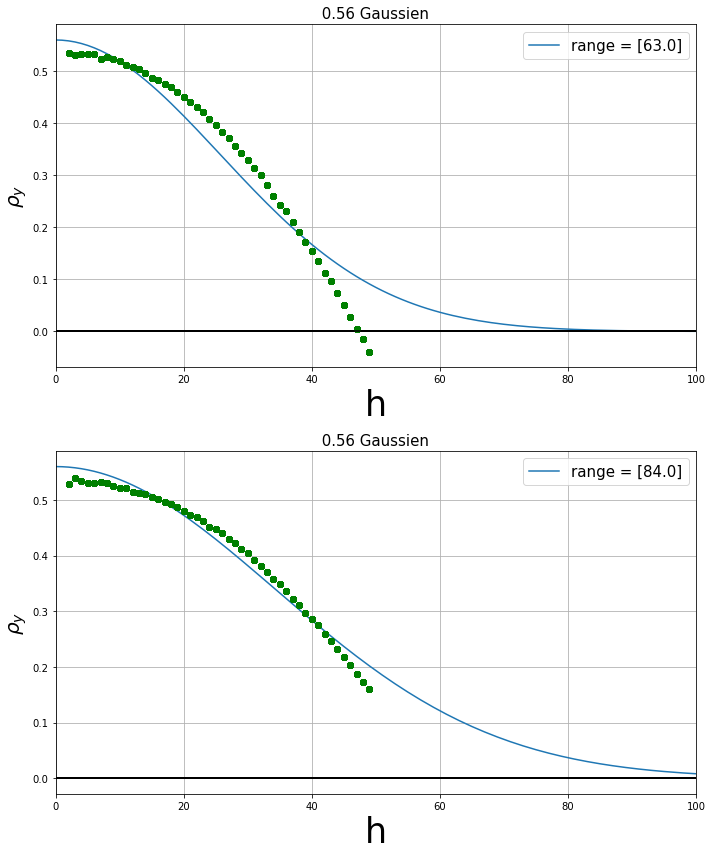

In [112]:
varg_type = 2  # See Correlogram Functions
k = 0 # Permet de changer de direction
nstruct = 1

MODEL_name ={ 1 : "Spherical",
         2 : "Exponential",
         3 : "Gaussien"}

label_dict = {0: dict_secondary["a_max"],
             1 : dict_secondary["a_min"]}

fig, axes = plt.subplots(2,1, figsize=(10, 12))
cy = np.zeros(shape=(LENGTH + 1))

# Title name
TITLE = ""
count = 1
for cc,vtype in zip(dict_secondary["cc"],dict_secondary["vtype"]) :
    model = MODEL_name[vtype]
    if count == 1 & len(dict_secondary["cc"]) >= 2 :
        TITLE += f"{cc} {model} +" 
    elif count == len(dict_secondary["cc"]):
        TITLE += f" {cc} {model} "
    elif count == 1 & len(dict_secondary["cc"]) == 1 :
        TITLE += f"{cc} {model}"                    
    else : 
        TITLE += f" {cc} {model} +"
    count += 1

for s in range(2) :
    for h in range(0, LENGTH + 1):
        # Calcul Correlogram model Z
        cy[h] = C_Y_alternate(np.matrix(h), np.matrix(h),varg_type, dict_secondary,nstruct)
        H[h] = h
        MM_vargs = [ cz_True,cy,czy ]

        # Label Display 
    for i in [1]:
        LABEL =  "range = {}".format(label_dict[s])
        axes[s].plot(H, MM_vargs[i], label=LABEL)
        var = locals()["varc_{}".format(i + 1)]

        # Calcul des valeurs de Correlogram à partir du variogram
    for h in range(1, LENGTH):
        H[h] = h
        axes[s].plot(
            var["Lag Distance"][var["Variogram Index"] == (s + 1)],
            Sill_vals[i]
            - var["Variogram Value"][var["Variogram Index"] == (s + 1)],
            "o",
            color=colors[i],
        )
        axes[s].set_ylabel(labels_2[i], size=20)
        axes[s].plot(H, ones, color="Black")
        axes[s].set_xlabel("h", size=35)
        axes[s].set_title(TITLE, size=15)
        axes[s].legend(loc="best", prop={"size": 15})
        axes[s].grid()
    plt.setp(axes, xlim=(0, 100))
    plt.tight_layout()

# Ici pas de direction précise, à inclure dans une loop le cas échéant
    varg_type = varg_type + 1
    k +=1

## Cross

In [113]:
def C_ZY(h1, h2, k,dict_C_ZY,nstruct = 1,Azimuth = 0):
    C = []
    vtype = dict_C_ZY["vtype"]
    a_max = dict_C_ZY["a_max"]
    a_min = dict_C_ZY["a_min"] 
    cc = dict_C_ZY["cc"]
    #Azimuth = 45
    c = 0
    for i in range(nstruct):
        
        Q1 = h1.copy()
        Q2 = h2.copy()
        if k == 0:
            d = distance_matrix(
                np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])),
                np.matmul(Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])),
            )
        elif k == 1:
            d = np.sqrt(
                np.square(
                    (np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])))
                    - np.tile(
                        (
                            np.matmul(
                                Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])
                            )
                        ),
                        (k, 1),
                    )
                ).sum(axis=1)
            )
            d = np.asarray(d).reshape(len(d))
        elif k == 2:
            d = Q1 / a_max[i]
        elif k == 3:
            d = Q1 / a_min[i]
        c = c + covar(vtype[i], d, 1) * cc[i]
    return c

In [114]:
def optimize_RMSE_ZY_model(x, args):
    """
    args : args[0] correspond au DataFrame ; args[1] à la Sill_value
    gamma= b*spherical(a_min,a_max)
    pour un modèle à plusieur couche => inserer en tant que list : a_max = [a_max1,a_max2]
    """
    
    var = args[0][args[0]["Variogram Value"] != -999]
    Sill_value = args[1] # Variance des données
    RMSE = [] # Liste des valeurs RMSE
    Direction = ["Major","Minor"]
    
    ## x0
    if len(x0) == 3 :
        a_max_zy_0 = [x[0]]         # range
        a_min_zy_0 = [x[1]]
        cc_zy_0 = [args[2]]         # effet pépite
        MODEL_value = [args[3]]     # type de modèle
        nstruct = 1
        
    else : # modèle plus complexe à plusieurs "couches" 
        
        a_max_zy_0 = x[0::3]        # range
        a_min_zy_0 = x[1::3]
        cc_zy_0 = [args[2]]         # effet pépite
        MODEL_value = args[3::]     # type de modèle
        nstruct = len(MODEL_value)  # nombre de couche
    
    dict_cross_0 = {"a_max" : a_max_zy_0
                ,"a_min" : a_min_zy_0
                ,"cc" : cc_zy_0
                ,"vtype" : MODEL_value
                 }
    
    print(dict_cross_0)
    for i,Dir in enumerate(Direction) :
        k = 2+i
        c = [] # liste des covario  
        
        variogram_lag = var["Lag Distance"][var["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        variogram_value = Sill_value - var["Variogram Value"][var["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        lag_value = variogram_lag # valeurs des lags
        
        
        for h in lag_value:
            MODEL = C_ZY(np.matrix(h), np.matrix(h), k, dict_cross_0,nstruct)
            
            c.append(MODEL.tolist()[0][0]) # convertion np.matrix to float
        RMSE.append(np.sqrt(mean_squared_error(variogram_value,c)))
    #print("vario :", variogram_value.values)
    #print("c :", c)
    print("RMSE :",RMSE, "\n")
        
    return sum(RMSE)

In [232]:
MODEL_type ={"Spherical" : 1,
        "Exponential" : 2,
        "Gaussien" : 3}

corr = np.corrcoef(Primary["Primary"], Primary["Secondary"])[0,1]
corr = float("{:.2f}".format(corr))
print("Coeff de correlation :", corr)

# Allocation des valeurs initiales

# range max, min, effet pepite, type de couche
a_max_zy_0  = np.array([30])
a_min_zy_0  = np.array([30])
cc_zy_0     = [corr]
MODEL_value = np.array([MODEL_type["Spherical"]])


var, Sill_value,= varc_3, corr # variogram , Variance
nstruct = len(a_max_zy_0) # nstruct, nombre de couche

x0,args = np.empty(1),np.empty(1)
#x0 = np.array([a_max_z_0,a_min_z_0, cc_z_0,MODEL_value])
args = np.append(args,[var,Sill_value])

for i in np.arange(nstruct) : # permet de minimiser un modèle à plusieur couche   
    a = a_max_zy_0[i]
    b = a_min_zy_0[i]
    c = cc_zy_0[i] # cc n'est pas à minimiser ici 
    d = MODEL_value[i]
    x0 = np.append(x0,[a,b])
    args = np.append(args,[c,d])
x0 = np.delete(x0,0)
args = np.delete(args,0)



# Boundaries 
Bounds = [[0,150],[0,150]]
if nstruct > 1 :
    Bounds *=  len(a_max_zy_0)


# Minimize
ZY_model = minimize(optimize_RMSE_ZY_model,x0,args = args,
                            method='TNC', jac = '3-point',
                            bounds = Bounds,tol = 1e-9)

print(ZY_model)

a_max_zy = [float("{:.0f}".format(x)) for x in ZY_model.x[0::3]]
a_min_zy = [float("{:.0f}".format(x)) for x in ZY_model.x[1::3]]
cc_zy = [corr]

dict_cross = {"a_max" : a_max_zy
                ,"a_min" : a_min_zy
                ,"cc" : cc_zy
                ,"vtype" : MODEL_value
              ,"nstruct"  : nstruct
}

Coeff de correlation : 0.66
{'a_max': array([30.]), 'a_min': array([30.]), 'cc': [0.66], 'vtype': array([1.0], dtype=object)}
RMSE : [0.35335527298747516, 0.1035348976831821] 

{'a_max': array([29.99981834]), 'a_min': array([30.]), 'cc': [0.66], 'vtype': array([1.0], dtype=object)}
RMSE : [0.3533553875971669, 0.1035348976831821] 

{'a_max': array([30.00018166]), 'a_min': array([30.]), 'cc': [0.66], 'vtype': array([1.0], dtype=object)}
RMSE : [0.35335515837892634, 0.1035348976831821] 

{'a_max': array([30.]), 'a_min': array([29.99981834]), 'cc': [0.66], 'vtype': array([1.0], dtype=object)}
RMSE : [0.35335527298747516, 0.1035353111099156] 

{'a_max': array([30.]), 'a_min': array([30.00018166]), 'cc': [0.66], 'vtype': array([1.0], dtype=object)}
RMSE : [0.35335527298747516, 0.1035344842547091] 

{'a_max': array([30.0000003]), 'a_min': array([30.00000109]), 'cc': [0.66], 'vtype': array([1.0], dtype=object)}
RMSE : [0.35335527279741463, 0.10353489521003152] 

{'a_max': array([29.99981864]),

{'a_max': array([40.37644965]), 'a_min': array([45.55550379]), 'cc': [0.66], 'vtype': array([1.0], dtype=object)}
RMSE : [0.3490056423955723, 0.0731079582138492] 

{'a_max': array([40.41253833]), 'a_min': array([45.5613974]), 'cc': [0.66], 'vtype': array([1.0], dtype=object)}
RMSE : [0.3490055209043493, 0.07310795168395583] 

{'a_max': array([40.41229362]), 'a_min': array([45.5613974]), 'cc': [0.66], 'vtype': array([1.0], dtype=object)}
RMSE : [0.34900552098353904, 0.07310795168395583] 

{'a_max': array([40.41278305]), 'a_min': array([45.5613974]), 'cc': [0.66], 'vtype': array([1.0], dtype=object)}
RMSE : [0.34900552083531494, 0.07310795168395583] 

{'a_max': array([40.41253833]), 'a_min': array([45.5611215]), 'cc': [0.66], 'vtype': array([1.0], dtype=object)}
RMSE : [0.3490055209043493, 0.07310795172061074] 

{'a_max': array([40.41253833]), 'a_min': array([45.56167329]), 'cc': [0.66], 'vtype': array([1.0], dtype=object)}
RMSE : [0.3490055209043493, 0.07310795167372583] 

{'a_max': arr

In [116]:
dict_cross

{'a_max': [31.0],
 'a_min': [35.0],
 'cc': [0.66],
 'vtype': array([3]),
 'nstruct': 1}

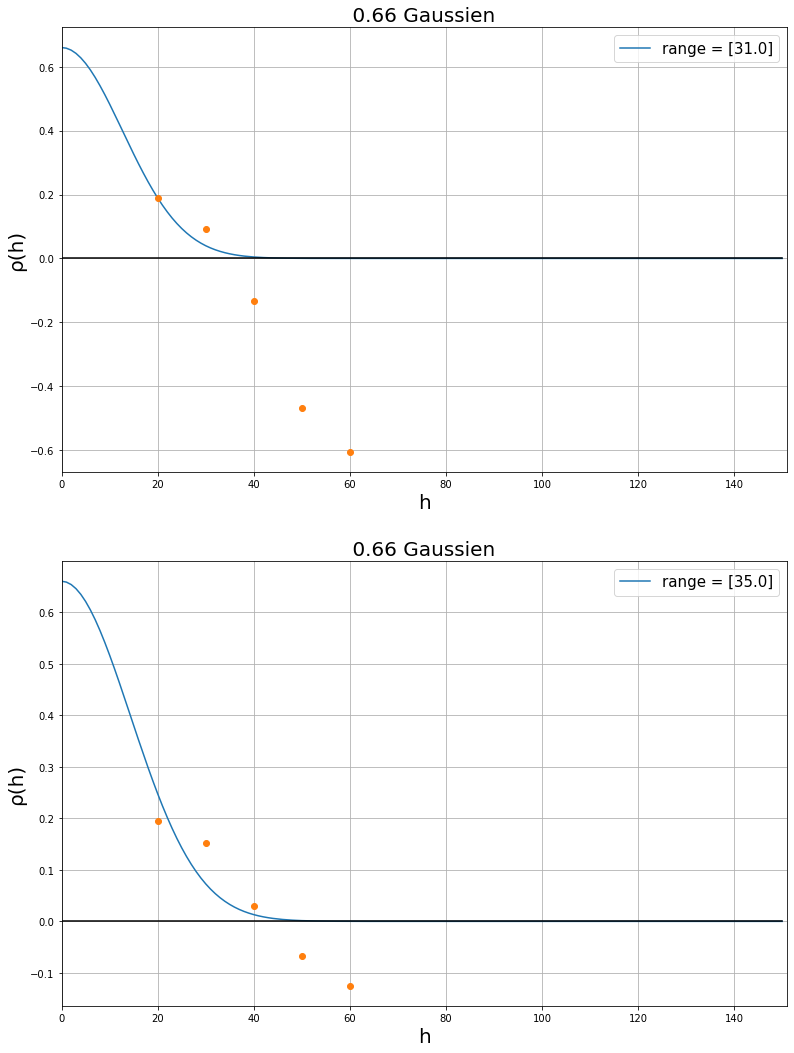

In [117]:
## Constantes de démarrage
varg_type = 2  # See Correlogram Functions
MODEL_name ={ 1 : "Spherical",
         2 : "Exponential",
         3 : "Gaussien"}

label_dict = {0: dict_cross["a_max"],
             1 : dict_cross["a_min"]}

fig, axes = plt.subplots(2, 1, figsize=(13, 18))
czy = np.zeros(shape=(LENGTH + 1))

# Title name
TITLE = ""
count = 1
for cc,vtype in zip(dict_cross["cc"],dict_cross["vtype"]) :
    model = MODEL_name[vtype]
    if count == 1 & len(dict_cross["cc"]) >= 2 :
        TITLE += f"{cc} {model} +" 
    elif count == len(dict_cross["cc"]):
        TITLE += f" {cc} {model} "
    elif count == 1 & len(dict_cross["cc"]) == 1 :
        TITLE += f"{cc} {model}"                    
    else : 
        TITLE += f" {cc} {model} +"
    count += 1


for s in range(2) :

    for h in range(0, LENGTH + 1):
        czy[h]= C_ZY(np.matrix(h), np.matrix(h),varg_type,dict_cross, 1)
        H[h] = h
    MM_vargs = [ cz_True,cy,czy ]

    for i in [2]: 
        LABEL =  "range = {}".format(label_dict[s])
        axes[s].plot(H, MM_vargs[i], label=LABEL)

        if (i + 1) <= 3:
            var = locals()["varc_{}".format(i + 1)]
            axes[s].plot(
                var["Lag Distance"][
                    var["Variogram Index"] == (s + 1)
                ],
                Sill_vals[i]
                - var["Variogram Value"][
                    var["Variogram Index"] == (s + 1)
                ],
                "o"
                )

    axes[s].plot(H, ones, color="Black")
    axes[s].grid()
    axes[s].set_xlim(0, LENGTH + 1)
    #axes[k].set_ylim(-0.1, 1)
    axes[s].set_ylabel("\u03C1(h)", size=20)
    axes[s].set_xlabel("h", size=20)
    axes[s].set_title(TITLE,size=20)
    axes[s].legend(loc="best", prop={"size": 15})
    varg_type = varg_type + 1

    
Save = False 
if Save :
    fileout =  "C:/Users/Alexandre/Desktop/Cours/Stage/\collocatedcokriging/Correlogram_test/"+Model+".png"
    plt.tight_layout()
    plt.savefig('fileout', bbox_inches="tight", dpi=300)
    

# Correlogram MM2 

### Scalling Correlogram 

In [118]:
# h1 = Set of points X,Y
# h2 = Set of points X,Y
# k = 0 used for calculating the distance between the same points
# k = 1 used for calculationg distance between different points
# k = 2 used for plotting in the major direction
# k = 3 used for plotting in the minor direction
def C_r (h1, h2, k, dict_C_r,nstruct = 1,Azimuth = 0 ):
    C = []
    vtype = dict_C_r["vtype"]
    a_max = dict_C_r["a_max"]
    a_min = dict_C_r["a_min"] 
    cc = dict_C_r["cc"]
    #Azimuth = 45
    c = 0
    for i in range(nstruct):
        Q1 = h1.copy()
        Q2 = h2.copy()
        if k == 0:
            d = distance_matrix(
                np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])),
                np.matmul(Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])),
            )
        elif k == 1:
            d = np.sqrt(
                np.square(
                    (np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])))
                    - np.tile(
                        (
                            np.matmul(
                                Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])
                            )
                        ),
                        (k, 1),
                    )
                ).sum(axis=1)
            )
            d = np.asarray(d).reshape(len(d))
        elif k == 2:
            d = Q1 / a_max[i]
        elif k == 3:
            d = Q1 / a_min[i]
        c = c + covar(vtype[i], d, 1) * cc[i]
    return c

### C_Z_MM2

In [119]:
# h1 = Set of points X,Y
# h2 = Set of points X,Y
# Corr = correlation between primary and secondary data
# k = 0 used for calculating the distance between the same points
# k = 1 used for calculationg distance between different points
# k = 2 used for plotting in the major direction
# k = 3 used for plotting in the minor direction
def C_Z_MM2(h1, h2, k, corr,dict_secondary, dict_C_r ):
    
    return (C_Y_alternate(h1, h2, k,dict_secondary, nstruct = 1) * corr ** 2) + (
        (1 - corr ** 2) * C_r (h1, h2, k,dict_C_r,nstruct = 1 )
    )

In [120]:
def optimize_RMSE_scalling_correlogram(x, args):
    """
    args : args[0] correspond au DataFrame ; args[1] correspond à la Sill_value (= 1)
    gamma= b*second(a_min,a_max)+ c*first(a_min_g,a_max_g)
    On minimize ici la différence entre le correlogram généré C_Z_MII ( qui se base sur le correlogram Y) et
    le modèle de correlogram ce C_Z. Les modifications s'effectuent sur le correlogram C_r 
    """
    
    dict_secondary = args[0] # dictionnaire des valeurs du correlogram secondaire
    dict_primary   = args[1] # dictionnaire des valeurs du correlogram primaire
    corr  = args[2]
    RMSE = [] # Liste des RMSE
    
    Direction = ["Major", "Minor"] #Deux directions à additionner
    
    ## x0
    if len(x0) == 3 :
        a_max_r_0 = [x[0]]         # range
        a_min_r_0 = [x[1]]
        cc_r_0 = [x[2]]            # effet pépite
        MODEL_value = [args[3]]  # type de modèle
        nstruct = 1
        
    else : # modèle plus complexe à plusieurs "couches", mais n'est pas forcément compatible.
        
        a_max_r_0 = x[0::3]        # range
        a_min_r_0 = x[1::3]
        cc_r_0 = x[2::3]           # effet pépite
        MODEL_value = args[3::]      # type de modèle
        nstruct = len(MODEL_value) # nombre de couche
    
    dict_scalling_0 = {"a_max" : a_max_r_0
                ,"a_min" : a_min_r_0
                ,"cc" : cc_r_0
                ,"vtype" : MODEL_value
                 }
    print(dict_scalling_0)
    for i,Dir in enumerate(Direction) :
        
        # Inititialisation des matrices
        cy = np.zeros(shape=(101))
        cr = np.zeros(shape=(101))
        cz_mm2 = np.zeros(shape=(101))
        cz = np.zeros(shape=(101))
        k = i + 2                # numéro de la direction 
        
        for h in range(0, 101):
            cy[h] = C_Y_alternate(np.matrix(h), np.matrix(h), k,
                                  dict_secondary, nstruct = 1)

            cz[h] = C_Z_alternate(np.matrix(h), np.matrix(h),k,
                                  dict_primary, nstruct = 1)

            cr[h] = C_r(np.matrix(h), np.matrix(h), k,
                        dict_scalling_0,nstruct = 1 )

            cz_mm2[h] = C_Z_MM2(np.matrix(h), np.matrix(h), k, corr,dict_secondary, dict_scalling_0)

            RMSE.append(np.sqrt(mean_squared_error(cz,cz_mm2))) 
    return sum(RMSE)

In [121]:
print('-' * 30)
print("dict_primary :", dict_primary)
print("dict_secondary :", dict_secondary)
print("dict_cross :", dict_cross)

------------------------------
dict_primary : {'a_max': [64.0], 'a_min': [78.0], 'cc': [1.14], 'vtype': array([3]), 'nstruct': 1}
dict_secondary : {'a_max': [63.0], 'a_min': [84.0], 'cc': [0.56], 'vtype': array([3]), 'nstruct': 1}
dict_cross : {'a_max': [31.0], 'a_min': [35.0], 'cc': [0.66], 'vtype': array([3]), 'nstruct': 1}


In [233]:
MODEL_type ={"Spherical" : 1,
        "Exponential" : 2,
        "Gaussien" : 3}

# Allocation des valeurs initiales
#x0 = np.array([a_max_z_0,a_min_z_0, cc_z_0,MODEL_value])

# range max, min, effet pepite, type de couche
a_max_r_0 = np.array([10])
a_min_r_0 = np.array([10])
cc_r_0    = np.array([2])
MODEL_value = np.array([MODEL_type["Spherical"]])
nstruct = len(a_max_r_0) # nstruct, nombre de couche

x0,args = np.empty(1),np.empty(1)
args = np.append(args,[dict_secondary,dict_primary,corr])

for i in np.arange(nstruct) : # permet de minimiser un modèle à plusieur couche   
    a = a_max_r_0[i]
    b = a_min_r_0[i]
    c = cc_r_0[i]
    d = MODEL_value[i]
    x0 = np.append(x0,[a,b,c])
    args = np.append(args,d)
x0 = np.delete(x0,0)
args = np.delete(args,0)



# Boundaries 
Bounds = [[0,150],[0,150],[0,5]]
if nstruct > 1 :
    Bounds *=  nstruct


# Minimize
scalling_model = minimize(optimize_RMSE_scalling_correlogram,x0,args = args,
                            method='TNC', jac = '3-point',
                            bounds = Bounds,tol = 1e-9)

print(scalling_model)

a_max_r = [float("{:.0f}".format(x)) for x in scalling_model.x[0::3]]
a_min_r = [float("{:.0f}".format(x)) for x in scalling_model.x[1::3]]
cc_r = [float("{:.2f}".format(x)) for x in scalling_model.x[2::3]]

dict_scalling = {"a_max" : a_max_r
                ,"a_min" : a_min_r
                ,"cc" : cc_r
                ,"vtype" : MODEL_value
}

{'a_max': [10.0], 'a_min': [10.0], 'cc': [2.0], 'vtype': [1]}
{'a_max': [9.999939445455476], 'a_min': [10.0], 'cc': [2.0], 'vtype': [1]}
{'a_max': [10.000060554544524], 'a_min': [10.0], 'cc': [2.0], 'vtype': [1]}
{'a_max': [10.0], 'a_min': [9.999939445455476], 'cc': [2.0], 'vtype': [1]}
{'a_max': [10.0], 'a_min': [10.000060554544524], 'cc': [2.0], 'vtype': [1]}
{'a_max': [10.0], 'a_min': [10.0], 'cc': [1.9999878890910952], 'vtype': [1]}
{'a_max': [10.0], 'a_min': [10.0], 'cc': [2.0000121109089046], 'vtype': [1]}
{'a_max': [10.000002593881604], 'a_min': [10.000002463041], 'cc': [2.0000000192006038], 'vtype': [1]}
{'a_max': [9.999942039321372], 'a_min': [10.000002463041], 'cc': [2.0000000192006038], 'vtype': [1]}
{'a_max': [10.000063148441836], 'a_min': [10.000002463041], 'cc': [2.0000000192006038], 'vtype': [1]}
{'a_max': [10.000002593881604], 'a_min': [9.99994190848156], 'cc': [2.0000000192006038], 'vtype': [1]}
{'a_max': [10.000002593881604], 'a_min': [10.00006301760044], 'cc': [2.000

{'a_max': [58.931388826639065], 'a_min': [85.85008262825293], 'cc': [1.7840488134067076], 'vtype': [1]}
{'a_max': [58.931388826639065], 'a_min': [85.85008262825293], 'cc': [1.784070419990206], 'vtype': [1]}
{'a_max': [60.07689998279811], 'a_min': [79.24547598687009], 'cc': [2.079622567172404], 'vtype': [1]}
{'a_max': [60.07653618986662], 'a_min': [79.24547598687009], 'cc': [2.079622567172404], 'vtype': [1]}
{'a_max': [60.0772637757296], 'a_min': [79.24547598687009], 'cc': [2.079622567172404], 'vtype': [1]}
{'a_max': [60.07689998279811], 'a_min': [79.24499611949969], 'cc': [2.079622567172404], 'vtype': [1]}
{'a_max': [60.07689998279811], 'a_min': [79.24595585424049], 'cc': [2.079622567172404], 'vtype': [1]}
{'a_max': [60.07689998279811], 'a_min': [79.24547598687009], 'cc': [2.07960997411267], 'vtype': [1]}
{'a_max': [60.07689998279811], 'a_min': [79.24547598687009], 'cc': [2.0796351602321375], 'vtype': [1]}
{'a_max': [60.64965556087764], 'a_min': [75.94317266617867], 'cc': [2.2274040424

{'a_max': [66.01530284955811], 'a_min': [83.44469342795003], 'cc': [2.041069944145246], 'vtype': [1]}
{'a_max': [66.01490309931921], 'a_min': [83.44418813240968], 'cc': [2.041069944145246], 'vtype': [1]}
{'a_max': [66.01490309931921], 'a_min': [83.44519872349038], 'cc': [2.041069944145246], 'vtype': [1]}
{'a_max': [66.01490309931921], 'a_min': [83.44469342795003], 'cc': [2.041057584539165], 'vtype': [1]}
{'a_max': [66.01490309931921], 'a_min': [83.44469342795003], 'cc': [2.0410823037513266], 'vtype': [1]}
{'a_max': [63.56778822345974], 'a_min': [82.66056163466573], 'cc': [2.076868696977054], 'vtype': [1]}
{'a_max': [63.567403291613516], 'a_min': [82.66056163466573], 'cc': [2.076868696977054], 'vtype': [1]}
{'a_max': [63.56817315530597], 'a_min': [82.66056163466573], 'cc': [2.076868696977054], 'vtype': [1]}
{'a_max': [63.56778822345974], 'a_min': [82.66006108739974], 'cc': [2.076868696977054], 'vtype': [1]}
{'a_max': [63.56778822345974], 'a_min': [82.66106218193171], 'cc': [2.0768686969

{'a_max': [69.62429989375838], 'a_min': [78.5850481980785], 'cc': [2.1372935115489824], 'vtype': [1]}
{'a_max': [69.6238782869816], 'a_min': [78.5850481980785], 'cc': [2.1372935115489824], 'vtype': [1]}
{'a_max': [69.62472150053516], 'a_min': [78.5850481980785], 'cc': [2.1372935115489824], 'vtype': [1]}
{'a_max': [69.62429989375838], 'a_min': [78.58457232989849], 'cc': [2.1372935115489824], 'vtype': [1]}
{'a_max': [69.62429989375838], 'a_min': [78.5855240662585], 'cc': [2.1372935115489824], 'vtype': [1]}
{'a_max': [69.62429989375838], 'a_min': [78.5850481980785], 'cc': [2.1372805692654717], 'vtype': [1]}
{'a_max': [69.62429989375838], 'a_min': [78.5850481980785], 'cc': [2.137306453832493], 'vtype': [1]}
{'a_max': [70.31367026547716], 'a_min': [80.85733581345565], 'cc': [2.1064709324751822], 'vtype': [1]}
{'a_max': [70.31324448424948], 'a_min': [80.85733581345565], 'cc': [2.1064709324751822], 'vtype': [1]}
{'a_max': [70.31409604670483], 'a_min': [80.85733581345565], 'cc': [2.10647093247

{'a_max': [69.79686103730958], 'a_min': [81.57574100012378], 'cc': [2.1042266233746783], 'vtype': [1]}
{'a_max': [69.79686103730958], 'a_min': [81.57574100012378], 'cc': [2.1042521076259475], 'vtype': [1]}
{'a_max': [69.79686093550684], 'a_min': [81.57574104292935], 'cc': [2.104239339365751], 'vtype': [1]}
{'a_max': [69.79643828379453], 'a_min': [81.57574104292935], 'cc': [2.104239339365751], 'vtype': [1]}
{'a_max': [69.79728358721916], 'a_min': [81.57574104292935], 'cc': [2.104239339365751], 'vtype': [1]}
{'a_max': [69.79686093550684], 'a_min': [81.57524706474504], 'cc': [2.104239339365751], 'vtype': [1]}
{'a_max': [69.79686093550684], 'a_min': [81.57623502111366], 'cc': [2.104239339365751], 'vtype': [1]}
{'a_max': [69.79686093550684], 'a_min': [81.57574104292935], 'cc': [2.1042265972402743], 'vtype': [1]}
{'a_max': [69.79686093550684], 'a_min': [81.57574104292935], 'cc': [2.1042520814912273], 'vtype': [1]}
{'a_max': [69.78993962036381], 'a_min': [81.57865128722473], 'cc': [2.10246251

{'a_max': [69.84852049589057], 'a_min': [82.15175120324433], 'cc': [2.1017947884993147], 'vtype': [1]}
{'a_max': [69.84852049589057], 'a_min': [82.15274614164433], 'cc': [2.1017947884993147], 'vtype': [1]}
{'a_max': [69.84852049589057], 'a_min': [82.15224867244433], 'cc': [2.1017820611767046], 'vtype': [1]}
{'a_max': [69.84852049589057], 'a_min': [82.15224867244433], 'cc': [2.1018075158219247], 'vtype': [1]}
{'a_max': [69.88163632366515], 'a_min': [82.13867736154828], 'cc': [2.1012791461697518], 'vtype': [1]}
{'a_max': [69.88121315859934], 'a_min': [82.13867736154828], 'cc': [2.1012791461697518], 'vtype': [1]}
{'a_max': [69.88205948873096], 'a_min': [82.13867736154828], 'cc': [2.1012791461697518], 'vtype': [1]}
{'a_max': [69.88163632366515], 'a_min': [82.13817997452874], 'cc': [2.1012791461697518], 'vtype': [1]}
{'a_max': [69.88163632366515], 'a_min': [82.13917474856781], 'cc': [2.1012791461697518], 'vtype': [1]}
{'a_max': [69.88163632366515], 'a_min': [82.13867736154828], 'cc': [2.101

{'a_max': [69.87997879416552], 'a_min': [82.15656718685594], 'cc': [2.1011817167384566], 'vtype': [1]}
{'a_max': [69.8795556391368], 'a_min': [82.15656718685594], 'cc': [2.1011817167384566], 'vtype': [1]}
{'a_max': [69.88040194919425], 'a_min': [82.15656718685594], 'cc': [2.1011817167384566], 'vtype': [1]}
{'a_max': [69.87997879416552], 'a_min': [82.15606969150538], 'cc': [2.1011817167384566], 'vtype': [1]}
{'a_max': [69.87997879416552], 'a_min': [82.1570646822065], 'cc': [2.1011817167384566], 'vtype': [1]}
{'a_max': [69.87997879416552], 'a_min': [82.15656718685594], 'cc': [2.1011689931282747], 'vtype': [1]}
{'a_max': [69.87997879416552], 'a_min': [82.15656718685594], 'cc': [2.1011944403486384], 'vtype': [1]}
{'a_max': [69.87997319085409], 'a_min': [82.15651428418256], 'cc': [2.101182887831952], 'vtype': [1]}
{'a_max': [69.8795500358593], 'a_min': [82.15651428418256], 'cc': [2.101182887831952], 'vtype': [1]}
{'a_max': [69.88039634584888], 'a_min': [82.15651428418256], 'cc': [2.10118288

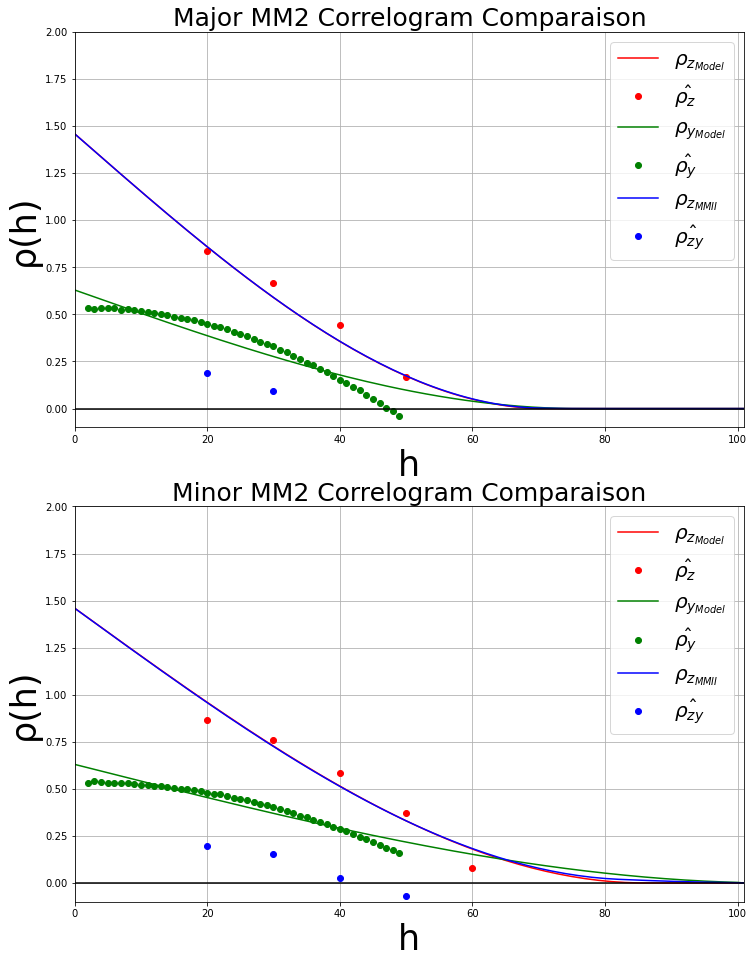

In [234]:
labels_MM = ['$ρ_{z_{Model}}$', '$ρ_{y_{Model}}$', '$ρ_{z_{MMII}}$']
varg_type = 2  # See Correlogram Functions
k = 0
cy = np.zeros(shape=(LENGTH + 1))
cz = np.zeros(shape=(LENGTH + 1))
cr = np.zeros(shape=(LENGTH + 1))
cz_mm2 = np.zeros(shape=(LENGTH + 1))

fig, axes = plt.subplots(2, 1, figsize=(12, 16))
for s,Dir in enumerate(["Major","Minor"]):
    for h in range(0, 101):

        cy[h]= C_Y_alternate(np.matrix(h), np.matrix(h), varg_type,dict_secondary, nstruct = 1)

        cz_True[h] = C_Z_alternate(np.matrix(h), np.matrix(h),varg_type,dict_primary, nstruct = 1)

        cz[h] = C_Z_MM2(np.matrix(h), np.matrix(h), varg_type, corr,dict_secondary,dict_scalling )

        cr[h] = C_r (np.matrix(h), np.matrix(h), varg_type, dict_scalling,nstruct = 1 )

        H[h] = h
    MM_vargs = [cz_True, cy, cz]
    
    for i in range(0, 3):
        axes[s].plot(H, MM_vargs[i], color=colors[i], label=labels_MM[i])
        if (i + 1) < 4:
            var = locals()["varc_{}".format(i + 1)]
            axes[s].plot(
                var["Lag Distance"][
                    var["Variogram Index"] == (varg_type - 1)
                ],
                Sill_vals[i]
                - var["Variogram Value"][
                    var["Variogram Index"] == (varg_type - 1)
                ],
                "o",
                color=colors[i],
                label=labels_1[i],
            )

    axes[s].plot(H, ones, color="Black")
    axes[s].grid()
    axes[s].set_xlim(0, 101)
    axes[s].set_ylim(-0.1, 2)
    axes[s].set_ylabel("\u03C1(h)", size=35)
    axes[s].set_xlabel("h", size=35)
    axes[s].set_title(
        Dir+" MM2 Correlogram Comparaison",
        size=25,
    )
    axes[s].legend(loc="best", prop={"size": 20})
    varg_type = varg_type + 1
    k += 1

# LMC 

In [125]:
def optimize_RMSE_LMC_model(x, args):
    """
    args : args[0] correspond au DataFrame ; args[1] correspond à la Sill_value (= 1)
    gamma= b*second(a_min,a_max)+ c*first(a_min_g,a_max_g)
    On cherche à minimiser un seul modèle qui serait compatible avec les trois autres correlogrammes (pas les modèles) 
    """
    
    df_primary   = args[0] # DataFrame des valeurs primaire
    df_secondary = args[1] # DataFrame des valeurs secondaire
    df_cross     = args[2] # DataFrame des valeurs cross 
    sill_value_z = args[3]
    sill_value_y = args[4]
    corr         = args[5]
    nstruct      = args[-1]
    RMSE = [] # Liste des RMSE
    Direction = ["Major", "Minor"] #Deux directions 
    ## x0
    if nstruct == 1 : # modèle à une couche
        a_max_0 = [x[0]]         # range
        a_min_0 = [x[1]]
        cc_0 = x[2::]            # effet pépite
        MODEL_value = [args[6]]  # type de modèle
        nstruct = 1
        
    else : # modèle plus complexe à plusieurs "couches", mais n'est pas forcément compatible avec les données.
    
        a_max_0 = x[0:-3*nstruct:nstruct]     # range
        a_min_0 = x[1:-3*nstruct:nstruct]
        cc_0 = x[nstruct*nstruct::]   # effet pépite
        MODEL_value = args[6:6+nstruct]      # type de modèle
        
        ## Condition des sills, il faut c1 + c2 + .. = sill_value du correlogram
        for i,sill in zip([0,1,2],[sill_value_z,sill_value_y,corr]) :
            for c1,c2 in [cc_0[i::3]] :
                if c1 + c2 > sill :
                    cc_0[i+3] = sill - cc_0[i]
                    print(cc_0[i],cc_0[i+3])

    dict_model_LMC_z = {"a_max" : a_max_0
                ,"a_min" : a_min_0
                ,"cc" : cc_0[0::3]
                ,"vtype" : MODEL_value
                 }
    
    dict_model_LMC_y = {"a_max" : a_max_0
                ,"a_min" : a_min_0
                ,"cc" : cc_0[1::3]
                ,"vtype" : MODEL_value
                 }
    
    dict_model_LMC_zy = {"a_max" : a_max_0
                ,"a_min" : a_min_0
                ,"cc" : cc_0[2::3]
                ,"vtype" : MODEL_value
                 }
    
    print("Z : ",dict_model_LMC_z,'\n Y :',dict_model_LMC_y,'\n ZY :',dict_model_LMC_zy)
    for i,Dir in enumerate(Direction) :
        k = i + 2
        MODEL_y  = []
        MODEL_z  = []
        MODEL_zy = []
        
        ### Correlogramme Y
        lag_value_y = df_secondary["Lag Distance"][df_secondary["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        variogram_value_y = sill_value_y - df_secondary["Variogram Value"][df_secondary["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        
        for h in lag_value_y:
            MODEL = C_Y_alternate(np.matrix(h), np.matrix(h), k,
                                  dict_model_LMC_y,nstruct)
            MODEL_y.append(MODEL.tolist()[0][0])
        RMSE.append(np.sqrt(mean_squared_error(variogram_value_y,MODEL_y)))
        
        ### Correlogramme Z
        lag_value_z = df_primary["Lag Distance"][df_primary["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        variogram_value_z = sill_value_z - df_primary["Variogram Value"][df_primary["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        for h in lag_value_z:
            MODEL = C_Z_alternate(np.matrix(h), np.matrix(h), k,
                                  dict_model_LMC_z,nstruct)
            MODEL_z.append(MODEL.tolist()[0][0])
        RMSE.append(np.sqrt(mean_squared_error(variogram_value_z,MODEL_z)))
        
        ## Correlogramme ZY
        lag_value_zy = df_cross["Lag Distance"][df_cross["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        variogram_value_zy = corr - df_cross["Variogram Value"][df_cross["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        for h in lag_value_zy:
            MODEL = C_ZY(np.matrix(h), np.matrix(h), k,
                                  dict_model_LMC_zy,nstruct)
            
            MODEL_zy.append(MODEL.tolist()[0][0])
        RMSE.append(np.sqrt(mean_squared_error(variogram_value_zy,MODEL_zy)))
    #print("RMSE value :",RMSE , " sum(RMSE) :",sum(RMSE),
    print("\n", "-" * 45)
    return sum(RMSE)

In [256]:
MODEL_type ={"Spherical" : 1,
        "Exponential" : 2,
        "Gaussien" : 3}

# Allocation des valeurs initiales
#x0 = np.array([a_max_z_0,a_min_z_0, cc_z_0,MODEL_value])

# range max, min, effet pepite, type de couche
a_max_LMC_0  = np.array([40,70])
a_min_LMC_0  = np.array([40,70])
cc_LMC_0     = np.array([0.6,0.4,0.3,0.2,0.5,0.2]) # les cc sont en fin de liste
sill_value_z = Sill_vals[0]
sill_value_y = Sill_vals[1]
sill_value_zy = Sill_vals[2]

MODEL_value = np.array([MODEL_type["Spherical"],MODEL_type["Gaussien"]]  )
nstruct = len(a_max_LMC_0) # nstruct, nombre de couche

x0,args = np.empty(1),np.empty(1)
args = np.append(args,[varc_1,varc_2,varc_3,sill_value_z,sill_value_y,sill_value_zy])

for i in np.arange(nstruct) : # permet de minimiser un modèle à plusieur couche   
    a = a_max_LMC_0[i]
    b = a_min_LMC_0[i]
    d = MODEL_value[i]
    x0 = np.append(x0,[a,b])
    args = np.append(args,[d])
args = np.append(args,nstruct)
c = cc_LMC_0.tolist()
x0 = np.append(x0,c)
x0 = np.delete(x0,0)
args = np.delete(args,0)


# Boundaries 
Bounds = [[0,100],[0,100]] * nstruct
Bounds +=  [[0,1],[0,1],[0,corr]] * nstruct
      
# Minimize
LMC_model = minimize(optimize_RMSE_LMC_model,x0,args = args,
                            method='TNC', jac = '3-point',
                            bounds = Bounds,options = {"xtol" : 1e-10,"ftol" : 1e-10,
                                                      "disp" : True})

Z :  {'a_max': array([40., 70.]), 'a_min': array([40., 70.]), 'cc': array([0.6, 0.2]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([40., 70.]), 'a_min': array([40., 70.]), 'cc': array([0.4, 0.5]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([40., 70.]), 'a_min': array([40., 70.]), 'cc': array([0.3, 0.2]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([39.99975778, 70.        ]), 'a_min': array([40., 70.]), 'cc': array([0.6, 0.2]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([39.99975778, 70.        ]), 'a_min': array([40., 70.]), 'cc': array([0.4, 0.5]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([39.99975778, 70.        ]), 'a_min': array([40., 70.]), 'cc': array([0.3, 0.2]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([40.00024222, 70.        ]), 'a_min': array([40., 70.]), 'cc': array([0.6, 0.2]


 ---------------------------------------------
Z :  {'a_max': array([40.00000051, 69.99999971]), 'a_min': array([39.99975839, 70.0000003 ]), 'cc': array([0.6       , 0.20000002]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([40.00000051, 69.99999971]), 'a_min': array([39.99975839, 70.0000003 ]), 'cc': array([0.39999998, 0.49999998]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([40.00000051, 69.99999971]), 'a_min': array([39.99975839, 70.0000003 ]), 'cc': array([0.3, 0.2]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([40.00000051, 69.99999971]), 'a_min': array([40.00024283, 70.0000003 ]), 'cc': array([0.6       , 0.20000002]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([40.00000051, 69.99999971]), 'a_min': array([40.00024283, 70.0000003 ]), 'cc': array([0.39999998, 0.49999998]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([40.00000051, 69.99999971]), 'a_min'


 ---------------------------------------------
Z :  {'a_max': array([40.00000051, 69.99999971]), 'a_min': array([40.00000061, 70.0000003 ]), 'cc': array([0.6       , 0.20000002]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([40.00000051, 69.99999971]), 'a_min': array([40.00000061, 70.0000003 ]), 'cc': array([0.39999998, 0.49999998]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([40.00000051, 69.99999971]), 'a_min': array([40.00000061, 70.0000003 ]), 'cc': array([0.3       , 0.20000605]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([40.00000592, 70.00000074]), 'a_min': array([40.00000734, 70.00000537]), 'cc': array([0.60000003, 0.20000013]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([40.00000592, 70.00000074]), 'a_min': array([40.00000734, 70.00000537]), 'cc': array([0.39999991, 0.49999993]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([40.00000592, 70.00000

 ---------------------------------------------
Z :  {'a_max': array([40.00000592, 70.00000074]), 'a_min': array([40.00000734, 70.00000537]), 'cc': array([0.60000003, 0.20000618]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([40.00000592, 70.00000074]), 'a_min': array([40.00000734, 70.00000537]), 'cc': array([0.39999991, 0.49999993]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([40.00000592, 70.00000074]), 'a_min': array([40.00000734, 70.00000537]), 'cc': array([0.3       , 0.19999998]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([40.00000592, 70.00000074]), 'a_min': array([40.00000734, 70.00000537]), 'cc': array([0.60000003, 0.20000013]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([40.00000592, 70.00000074]), 'a_min': array([40.00000734, 70.00000537]), 'cc': array([0.39999991, 0.49999387]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([40.00000592, 70.000000


 ---------------------------------------------
Z :  {'a_max': array([52.35802712, 63.06230823]), 'a_min': array([54.58994387, 77.30379191]), 'cc': array([0.70917014, 0.29082986]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([52.35802712, 63.06230823]), 'a_min': array([54.58994387, 77.30379191]), 'cc': array([8.34288819e-03, 5.55111512e-17]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([52.35802712, 63.06230823]), 'a_min': array([54.58994387, 77.30379191]), 'cc': array([0.28866219, 0.10912294]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([52.35802712, 63.06230823]), 'a_min': array([54.58994387, 77.30379191]), 'cc': array([0.70917014, 0.2908238 ]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([52.35802712, 63.06230823]), 'a_min': array([54.58994387, 77.30379191]), 'cc': array([8.34288819e-03, 5.55111512e-17]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([52.35


 ---------------------------------------------
Z :  {'a_max': array([46.17901356, 66.53115411]), 'a_min': array([47.29497194, 73.65189595]), 'cc': array([0.65458507, 0.34541493]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([46.17901356, 66.53115411]), 'a_min': array([47.29497194, 73.65189595]), 'cc': array([0.2041775, 0.25     ]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([46.17901356, 66.53115411]), 'a_min': array([47.29497194, 73.65189595]), 'cc': array([0.29432807, 0.15456147]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([46.17901356, 66.53115411]), 'a_min': array([47.29497194, 73.65189595]), 'cc': array([0.65458507, 0.34541493]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([46.17901356, 66.53115411]), 'a_min': array([47.29497194, 73.65189595]), 'cc': array([0.20417144, 0.25      ]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([46.17901356, 66.5311541


 ---------------------------------------------
Z :  {'a_max': array([43.08950678, 68.26557706]), 'a_min': array([43.64748597, 71.82638292]), 'cc': array([0.62729254, 0.32134082]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([43.08950678, 68.26557706]), 'a_min': array([43.64748597, 71.82638292]), 'cc': array([0.30208572, 0.375     ]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([43.08950678, 68.26557706]), 'a_min': array([43.64748597, 71.82638292]), 'cc': array([0.29716403, 0.17728073]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([43.08950678, 68.26557706]), 'a_min': array([43.64748597, 71.82594798]), 'cc': array([0.62728648, 0.32134082]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([43.08950678, 68.26557706]), 'a_min': array([43.64748597, 71.82594798]), 'cc': array([0.30208572, 0.375     ]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([43.08950678, 68.26557

 ZY : {'a_max': array([44.63426017, 67.39836559]), 'a_min': array([45.4709536 , 72.73892197]), 'cc': array([0.29574605, 0.1659211 ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([44.63426017, 67.39836559]), 'a_min': array([45.4715043 , 72.73892197]), 'cc': array([0.6409388, 0.3590612]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([44.63426017, 67.39836559]), 'a_min': array([45.4715043 , 72.73892197]), 'cc': array([0.25312858, 0.3125    ]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([44.63426017, 67.39836559]), 'a_min': array([45.4715043 , 72.73892197]), 'cc': array([0.29574605, 0.1659211 ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([44.63426017, 67.39795746]), 'a_min': array([45.47122895, 72.73892197]), 'cc': array([0.6409388, 0.3590612]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([44.63426017, 67.39795746])

 Y : {'a_max': array([44.63399075, 67.39836582]), 'a_min': array([45.47122962, 72.73892235]), 'cc': array([0.25312859, 0.3125    ]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([44.63399075, 67.39836582]), 'a_min': array([45.47122962, 72.73892235]), 'cc': array([0.29574605, 0.1659211 ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([44.63453131, 67.39836582]), 'a_min': array([45.47122962, 72.73892235]), 'cc': array([0.6409388, 0.3590612]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([44.63453131, 67.39836582]), 'a_min': array([45.47122962, 72.73892235]), 'cc': array([0.25312859, 0.3125    ]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([44.63453131, 67.39836582]), 'a_min': array([45.47122962, 72.73892235]), 'cc': array([0.29574605, 0.1659211 ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([44.63426103, 67.39836582

 ---------------------------------------------
Z :  {'a_max': array([44.63426103, 67.39836582]), 'a_min': array([45.47122962, 72.73892235]), 'cc': array([0.6409388, 0.3590612]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([44.63426103, 67.39836582]), 'a_min': array([45.47122962, 72.73892235]), 'cc': array([0.25312859, 0.3125    ]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([44.63426103, 67.39836582]), 'a_min': array([45.47122962, 72.73892235]), 'cc': array([0.29574605, 0.16591504]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([44.63426103, 67.39836582]), 'a_min': array([45.47122962, 72.73892235]), 'cc': array([0.6409388, 0.3590612]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([44.63426103, 67.39836582]), 'a_min': array([45.47122962, 72.73892235]), 'cc': array([0.25312859, 0.3125    ]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([44.63426103, 67.39836582])


 ---------------------------------------------
Z :  {'a_max': array([70.91439344, 74.51626309]), 'a_min': array([65.68179611, 84.56423499]), 'cc': array([0.58049709, 0.41949685]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([70.91439344, 74.51626309]), 'a_min': array([65.68179611, 84.56423499]), 'cc': array([0.32073951, 0.32522524]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([70.91439344, 74.51626309]), 'a_min': array([65.68179611, 84.56423499]), 'cc': array([0.27666677, 0.03113743]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
0.5804970918072142 0.4195029081927858
Z :  {'a_max': array([70.91439344, 74.51626309]), 'a_min': array([65.68179611, 84.56423499]), 'cc': array([0.58049709, 0.41950291]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([70.91439344, 74.51626309]), 'a_min': array([65.68179611, 84.56423499]), 'cc': array([0.32073951, 0.32522524]), 'vtype': array([1, 3], dtype=object)} 
 ZY : 


 ---------------------------------------------
Z :  {'a_max': array([70.91439349, 74.51626308]), 'a_min': array([65.68179679, 84.5642355 ]), 'cc': array([0.58049709, 0.41950291]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([70.91439349, 74.51626308]), 'a_min': array([65.68179679, 84.5642355 ]), 'cc': array([0.3207395 , 0.32522524]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([70.91439349, 74.51626308]), 'a_min': array([65.68179679, 84.5642355 ]), 'cc': array([0.27667282, 0.03113743]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([70.91439349, 74.51626308]), 'a_min': array([65.68179679, 84.5642355 ]), 'cc': array([0.58049709, 0.41949685]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([70.91439349, 74.51626308]), 'a_min': array([65.68179679, 84.5642355 ]), 'cc': array([0.3207395 , 0.32522524]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([70.91439349, 74.51626

 ZY : {'a_max': array([70.91439321, 74.51626299]), 'a_min': array([65.68179696, 84.56423569]), 'cc': array([0.27666677, 0.03113743]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
0.580503153896873 0.419496846103127
Z :  {'a_max': array([70.91439321, 74.51626299]), 'a_min': array([65.68179696, 84.56423569]), 'cc': array([0.58050315, 0.41949685]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([70.91439321, 74.51626299]), 'a_min': array([65.68179696, 84.56423569]), 'cc': array([0.32073951, 0.32522524]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([70.91439321, 74.51626299]), 'a_min': array([65.68179696, 84.56423569]), 'cc': array([0.27666677, 0.03113743]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([70.91439321, 74.51626299]), 'a_min': array([65.68179696, 84.56423569]), 'cc': array([0.5804971, 0.4195029]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_m


 ---------------------------------------------
Z :  {'a_max': array([70.91439369, 74.51671459]), 'a_min': array([65.68179652, 84.56423527]), 'cc': array([0.5804971, 0.4195029]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([70.91439369, 74.51671459]), 'a_min': array([65.68179652, 84.56423527]), 'cc': array([0.32073951, 0.32522524]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([70.91439369, 74.51671459]), 'a_min': array([65.68179652, 84.56423527]), 'cc': array([0.27666677, 0.03113743]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([70.91439369, 74.51626336]), 'a_min': array([65.68179652, 84.56372319]), 'cc': array([0.5804971, 0.4195029]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([70.91439369, 74.51626336]), 'a_min': array([65.68179652, 84.56372319]), 'cc': array([0.32073951, 0.32522524]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([70.91439369, 74.51626336]

 Y : {'a_max': array([70.91439467, 74.5162643 ]), 'a_min': array([65.68140005, 84.56423557]), 'cc': array([0.3207395 , 0.32522524]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([70.91439467, 74.5162643 ]), 'a_min': array([65.68140005, 84.56423557]), 'cc': array([0.27666677, 0.03113742]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([70.91439467, 74.5162643 ]), 'a_min': array([65.68219551, 84.56423557]), 'cc': array([0.58049714, 0.41950286]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([70.91439467, 74.5162643 ]), 'a_min': array([65.68219551, 84.56423557]), 'cc': array([0.3207395 , 0.32522524]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([70.91439467, 74.5162643 ]), 'a_min': array([65.68219551, 84.56423557]), 'cc': array([0.27666677, 0.03113742]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([70.91439467, 74.515813

 ---------------------------------------------
Z :  {'a_max': array([72.73139548, 76.65278388]), 'a_min': array([73.49454798, 90.24917695]), 'cc': array([0.66887292, 0.33112708]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([72.73139548, 76.65278388]), 'a_min': array([73.49454798, 90.24917695]), 'cc': array([0.31222906, 0.31814079]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([72.73139548, 76.65278388]), 'a_min': array([73.49454798, 90.24917695]), 'cc': array([0.28939448, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([72.73227633, 76.65278388]), 'a_min': array([73.49454798, 90.24917695]), 'cc': array([0.66887292, 0.33112708]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([72.73227633, 76.65278388]), 'a_min': array([73.49454798, 90.24917695]), 'cc': array([0.31222906, 0.31814079]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([72.73227633, 76.652783


 ---------------------------------------------
Z :  {'a_max': array([72.7318359 , 76.65278388]), 'a_min': array([73.49454798, 90.24917695]), 'cc': array([0.66887292, 0.33112708]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([72.7318359 , 76.65278388]), 'a_min': array([73.49454798, 90.24917695]), 'cc': array([0.31222906, 0.31814684]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([72.7318359 , 76.65278388]), 'a_min': array([73.49454798, 90.24917695]), 'cc': array([0.28939448, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([72.7318359 , 76.65278388]), 'a_min': array([73.49454798, 90.24917695]), 'cc': array([0.66887292, 0.33112708]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([72.7318359 , 76.65278388]), 'a_min': array([73.49454798, 90.24917695]), 'cc': array([0.31222906, 0.31814079]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([72.7318359 , 76.65278

 ZY : {'a_max': array([72.73183594, 76.65278386]), 'a_min': array([73.49454845, 90.24917716]), 'cc': array([0.28938842, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([72.73183594, 76.65278386]), 'a_min': array([73.49454845, 90.24917716]), 'cc': array([0.66887293, 0.33112707]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([72.73183594, 76.65278386]), 'a_min': array([73.49454845, 90.24917716]), 'cc': array([0.31222906, 0.31814079]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([72.73183594, 76.65278386]), 'a_min': array([73.49454845, 90.24917716]), 'cc': array([0.28940053, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([72.73183594, 76.65278386]), 'a_min': array([73.49454845, 90.24917716]), 'cc': array([0.66887293, 0.33112102]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([72.73183594, 76.652783


 ---------------------------------------------
Z :  {'a_max': array([72.73183574, 76.65278375]), 'a_min': array([73.49454878, 90.24917731]), 'cc': array([0.66887293, 0.33112707]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([72.73183574, 76.65278375]), 'a_min': array([73.49454878, 90.24917731]), 'cc': array([0.31223512, 0.31814079]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([72.73183574, 76.65278375]), 'a_min': array([73.49454878, 90.24917731]), 'cc': array([0.28939447, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([72.73183574, 76.65278375]), 'a_min': array([73.49454878, 90.24917731]), 'cc': array([0.66887293, 0.33112707]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([72.73183574, 76.65278375]), 'a_min': array([73.49454878, 90.24917731]), 'cc': array([0.31222906, 0.31814079]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([72.73183574, 76.65278


 ---------------------------------------------
Z :  {'a_max': array([72.7318362 , 76.65278388]), 'a_min': array([73.49454885, 90.24972374]), 'cc': array([0.66887294, 0.33112706]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([72.7318362 , 76.65278388]), 'a_min': array([73.49454885, 90.24972374]), 'cc': array([0.31222906, 0.31814079]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([72.7318362 , 76.65278388]), 'a_min': array([73.49454885, 90.24972374]), 'cc': array([0.28939447, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([72.7318362 , 76.65278388]), 'a_min': array([73.49454885, 90.24917724]), 'cc': array([0.66886689, 0.33112706]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([72.7318362 , 76.65278388]), 'a_min': array([73.49454885, 90.24917724]), 'cc': array([0.31222906, 0.31814079]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([72.7318362 , 76.65278


 ---------------------------------------------
Z :  {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.29434535, 100.        ]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.29434535, 100.        ]), 'cc': array([0.28911684, 0.29764364]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.29434535, 100.        ]), 'cc': array([0.22698439, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.29549946, 100.        ]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.29549946, 100.        ]), 'cc': array([0.28911684, 0.29764364]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86075463, 73

 ZY : {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([2.26984385e-01, 6.05545445e-06]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.28911684, 0.29764364]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([2.26984385e-01, 1.21109089e-05]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
0.8409903988612628 0.1590096011387372
Z :  {'a_max': array([69.86075481, 73.87469063]), 'a_min': array([ 95.29492252, 100.        ]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=ob


 ---------------------------------------------
Z :  {'a_max': array([69.86075481, 73.87469063]), 'a_min': array([ 95.29492252, 100.        ]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075481, 73.87469063]), 'a_min': array([ 95.29492252, 100.        ]), 'cc': array([0.28911684, 0.29763758]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86075481, 73.87469063]), 'a_min': array([ 95.29492252, 100.        ]), 'cc': array([0.22698438, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([69.86075481, 73.87469063]), 'a_min': array([ 95.29492252, 100.        ]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075481, 73.87469063]), 'a_min': array([ 95.29492252, 100.        ]), 'cc': array([0.28911684, 0.29764969]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86075481, 73


 ---------------------------------------------
Z :  {'a_max': array([69.86075936, 73.87469087]), 'a_min': array([ 95.2949258, 100.       ]), 'cc': array([0.84099051, 0.15900949]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075936, 73.87469087]), 'a_min': array([ 95.2949258, 100.       ]), 'cc': array([0.28911683, 0.29764363]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86075936, 73.87469087]), 'a_min': array([ 95.2949258, 100.       ]), 'cc': array([0.22697829, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([69.86075936, 73.87469087]), 'a_min': array([ 95.2949258, 100.       ]), 'cc': array([0.84099051, 0.15900949]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075936, 73.87469087]), 'a_min': array([ 95.2949258, 100.       ]), 'cc': array([0.28911683, 0.29764363]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86075936, 73.87469


 ---------------------------------------------
Z :  {'a_max': array([76.80216373, 74.81071252]), 'a_min': array([100., 100.]), 'cc': array([0.98013404, 0.01986596]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([76.80216373, 74.81071252]), 'a_min': array([100., 100.]), 'cc': array([0.27501219, 0.28027109]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([76.80216373, 74.81071252]), 'a_min': array([100., 100.]), 'cc': array([0.1765762, 0.       ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([76.80216373, 74.81071252]), 'a_min': array([100., 100.]), 'cc': array([0.98013404, 0.01986596]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([76.80216373, 74.81071252]), 'a_min': array([100., 100.]), 'cc': array([0.2750243 , 0.28027109]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([76.80216373, 74.81071252]), 'a_min': array([100., 100.]), 'cc': array([0.1765762, 0.       ])


 ---------------------------------------------
0.9105682755509614 0.08943172444903857
Z :  {'a_max': array([73.33145918, 74.34270157]), 'a_min': array([ 97.6474612, 100.       ]), 'cc': array([0.91056828, 0.08943172]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([73.33145918, 74.34270157]), 'a_min': array([ 97.6474612, 100.       ]), 'cc': array([0.28206754, 0.28895736]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([73.33145918, 74.34270157]), 'a_min': array([ 97.6474612, 100.       ]), 'cc': array([0.20178029, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([73.33145918, 74.34270157]), 'a_min': array([ 97.6474612, 100.       ]), 'cc': array([0.91056222, 0.08943778]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([73.33145918, 74.34270157]), 'a_min': array([ 97.6474612, 100.       ]), 'cc': array([0.28206149, 0.28895736]), 'vtype': array([1, 3], dtype=object)} 
 ZY :

 ---------------------------------------------
Z :  {'a_max': array([71.59610691, 74.10869609]), 'a_min': array([96.4711918 , 99.99939445]), 'cc': array([0.87577631, 0.12422369]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([71.59610691, 74.10869609]), 'a_min': array([96.4711918 , 99.99939445]), 'cc': array([0.28559219, 0.2933005 ]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([71.59610691, 74.10869609]), 'a_min': array([96.4711918 , 99.99939445]), 'cc': array([0.21438234, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([71.59610691, 74.10869609]), 'a_min': array([96.4711918 , 99.99878891]), 'cc': array([0.87577631, 0.12422369]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([71.59610691, 74.10869609]), 'a_min': array([96.4711918 , 99.99878891]), 'cc': array([0.28559219, 0.2933005 ]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([71.59610691, 74.108696

 ---------------------------------------------
Z :  {'a_max': array([70.72843077, 73.99169335]), 'a_min': array([ 95.88247649, 100.        ]), 'cc': array([0.85838335, 0.14161665]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([70.72843077, 73.99169335]), 'a_min': array([ 95.88247649, 100.        ]), 'cc': array([0.28735451, 0.29547207]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([70.72843077, 73.99169335]), 'a_min': array([ 95.88247649, 100.        ]), 'cc': array([0.22068336, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([70.72843077, 73.99169335]), 'a_min': array([ 95.88363772, 100.        ]), 'cc': array([0.85838335, 0.14161665]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([70.72843077, 73.99169335]), 'a_min': array([ 95.88363772, 100.        ]), 'cc': array([0.28735451, 0.29547207]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([70.72843077,


 ---------------------------------------------
Z :  {'a_max': array([70.29416703, 73.93319198]), 'a_min': array([ 95.58898975, 100.        ]), 'cc': array([0.84968687, 0.15031313]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([70.29416703, 73.93319198]), 'a_min': array([ 95.58898975, 100.        ]), 'cc': array([0.28823567, 0.29655785]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([70.29416703, 73.93319198]), 'a_min': array([ 95.58898975, 100.        ]), 'cc': array([0.22383387, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([70.29501837, 73.93319198]), 'a_min': array([ 95.58898975, 100.        ]), 'cc': array([0.84968687, 0.15031313]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([70.29501837, 73.93319198]), 'a_min': array([ 95.58898975, 100.        ]), 'cc': array([0.28823567, 0.29655785]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([70.29501837

 ZY : {'a_max': array([70.2945927 , 73.93319198]), 'a_min': array([ 95.58898975, 100.        ]), 'cc': array([2.23833874e-01, 6.05545445e-06]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([70.2945927 , 73.93319198]), 'a_min': array([ 95.58898975, 100.        ]), 'cc': array([0.84968687, 0.15031313]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([70.2945927 , 73.93319198]), 'a_min': array([ 95.58898975, 100.        ]), 'cc': array([0.28823567, 0.29655785]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([70.2945927 , 73.93319198]), 'a_min': array([ 95.58898975, 100.        ]), 'cc': array([2.23833874e-01, 1.21109089e-05]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
0.8453386343975637 0.15466136560243626
Z :  {'a_max': array([70.07767367, 73.90394129]), 'a_min': array([ 95.44195608, 100.        ]), 'cc': array([0.84533863, 0.15466137]), 'vtype': array([1,


 ---------------------------------------------
Z :  {'a_max': array([70.07767367, 73.90394129]), 'a_min': array([ 95.44195608, 100.        ]), 'cc': array([0.84533863, 0.15465531]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([70.07767367, 73.90394129]), 'a_min': array([ 95.44195608, 100.        ]), 'cc': array([0.28867625, 0.29710075]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([70.07767367, 73.90394129]), 'a_min': array([ 95.44195608, 100.        ]), 'cc': array([0.22540913, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
0.8453386343975637 0.15466136560243626
Z :  {'a_max': array([70.07767367, 73.90394129]), 'a_min': array([ 95.44195608, 100.        ]), 'cc': array([0.84533863, 0.15466137]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([70.07767367, 73.90394129]), 'a_min': array([ 95.44195608, 100.        ]), 'cc': array([0.28867625, 0.29710075]), 'vtype': array([1, 3], dtype=objec


 ---------------------------------------------
Z :  {'a_max': array([69.96921415, 73.88931595]), 'a_min': array([ 95.36843924, 100.        ]), 'cc': array([0.84316451, 0.15683549]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.96921415, 73.88931595]), 'a_min': array([ 95.36843924, 100.        ]), 'cc': array([0.28889049, 0.29737219]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.96921415, 73.88931595]), 'a_min': array([ 95.36843924, 100.        ]), 'cc': array([0.22619676, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([69.96921415, 73.88931595]), 'a_min': array([ 95.36843924, 100.        ]), 'cc': array([0.84316451, 0.15683549]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.96921415, 73.88931595]), 'a_min': array([ 95.36843924, 100.        ]), 'cc': array([0.2889026 , 0.29737219]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.96921415


 ---------------------------------------------
Z :  {'a_max': array([69.91498439, 73.88200328]), 'a_min': array([95.33168082, 99.99939445]), 'cc': array([0.84207746, 0.15792254]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.91498439, 73.88200328]), 'a_min': array([95.33168082, 99.99939445]), 'cc': array([0.28900669, 0.29750792]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.91498439, 73.88200328]), 'a_min': array([95.33168082, 99.99939445]), 'cc': array([0.22659057, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([69.91498439, 73.88200328]), 'a_min': array([95.33168082, 99.99878891]), 'cc': array([0.84207746, 0.15792254]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.91498439, 73.88200328]), 'a_min': array([95.33168082, 99.99878891]), 'cc': array([0.28900669, 0.29750792]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.91498439, 73.88200


 ---------------------------------------------
Z :  {'a_max': array([69.88786951, 73.87834694]), 'a_min': array([ 95.31272445, 100.        ]), 'cc': array([0.84153393, 0.15846607]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.88786951, 73.87834694]), 'a_min': array([ 95.31272445, 100.        ]), 'cc': array([0.28906176, 0.29757578]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.88786951, 73.87834694]), 'a_min': array([ 95.31272445, 100.        ]), 'cc': array([0.22678748, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([69.88786951, 73.87834694]), 'a_min': array([ 95.31387878, 100.        ]), 'cc': array([0.84153393, 0.15846607]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.88786951, 73.87834694]), 'a_min': array([ 95.31387878, 100.        ]), 'cc': array([0.28906176, 0.29757578]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.88786951

Z :  {'a_max': array([69.88786951, 73.87834694]), 'a_min': array([ 95.31330161, 100.        ]), 'cc': array([0.84153393, 0.15846607]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.88786951, 73.87834694]), 'a_min': array([ 95.31330161, 100.        ]), 'cc': array([0.28906176, 0.29757578]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.88786951, 73.87834694]), 'a_min': array([ 95.31330161, 100.        ]), 'cc': array([2.26787478e-01, 1.21109089e-05]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
0.8412621602913797 0.15873783970862032
Z :  {'a_max': array([69.87431207, 73.87651878]), 'a_min': array([ 95.30411201, 100.        ]), 'cc': array([0.84126216, 0.15873784]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.87431207, 73.87651878]), 'a_min': array([ 95.30411201, 100.        ]), 'cc': array([0.2890893 , 0.29760971]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.87431207,

 ---------------------------------------------
0.8412621602913797 0.15873783970862032
Z :  {'a_max': array([69.87431207, 73.87651878]), 'a_min': array([ 95.30411201, 100.        ]), 'cc': array([0.84126216, 0.15873784]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.87431207, 73.87651878]), 'a_min': array([ 95.30411201, 100.        ]), 'cc': array([0.2890893 , 0.29760971]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.87431207, 73.87651878]), 'a_min': array([ 95.30411201, 100.        ]), 'cc': array([0.22688593, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([69.87431207, 73.87651878]), 'a_min': array([ 95.30411201, 100.        ]), 'cc': array([0.84126216, 0.15873784]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.87431207, 73.87651878]), 'a_min': array([ 95.30411201, 100.        ]), 'cc': array([0.2890893 , 0.29760365]), 'vtype': array([1, 3], dtype=object


 ---------------------------------------------
Z :  {'a_max': array([69.86753335, 73.87560469]), 'a_min': array([ 95.29951721, 100.        ]), 'cc': array([0.84112628, 0.15887372]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86753335, 73.87560469]), 'a_min': array([ 95.29951721, 100.        ]), 'cc': array([0.28910307, 0.29762667]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86753335, 73.87560469]), 'a_min': array([ 95.29951721, 100.        ]), 'cc': array([0.2269291, 0.       ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([69.86753335, 73.87560469]), 'a_min': array([ 95.29951721, 100.        ]), 'cc': array([0.84112628, 0.15887372]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86753335, 73.87560469]), 'a_min': array([ 95.29951721, 100.        ]), 'cc': array([0.28910307, 0.29762667]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86753335, 


 ---------------------------------------------
Z :  {'a_max': array([69.86414399, 73.87514765]), 'a_min': array([ 95.2972198, 100.       ]), 'cc': array([0.84105228, 0.15894166]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86414399, 73.87514765]), 'a_min': array([ 95.2972198, 100.       ]), 'cc': array([0.28910995, 0.29763516]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86414399, 73.87514765]), 'a_min': array([ 95.2972198, 100.       ]), 'cc': array([0.22695977, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
0.8410643920405229 0.15893560795947714
Z :  {'a_max': array([69.86414399, 73.87514765]), 'a_min': array([ 95.2972198, 100.       ]), 'cc': array([0.84106439, 0.15893561]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86414399, 73.87514765]), 'a_min': array([ 95.2972198, 100.       ]), 'cc': array([0.28910995, 0.29763516]), 'vtype': array([1, 3], dtype=object)} 
 ZY :


 ---------------------------------------------
Z :  {'a_max': array([69.86244931, 73.87536647]), 'a_min': array([ 95.2960711, 100.       ]), 'cc': array([0.84102437, 0.15897563]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86244931, 73.87536647]), 'a_min': array([ 95.2960711, 100.       ]), 'cc': array([0.28911339, 0.2976394 ]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86244931, 73.87536647]), 'a_min': array([ 95.2960711, 100.       ]), 'cc': array([0.22697208, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([69.86244931, 73.87491913]), 'a_min': array([95.2960711 , 99.99939445]), 'cc': array([0.84102437, 0.15897563]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86244931, 73.87491913]), 'a_min': array([95.2960711 , 99.99939445]), 'cc': array([0.28911339, 0.2976394 ]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86244931, 73.87491

 ---------------------------------------------
Z :  {'a_max': array([69.86117893, 73.87480487]), 'a_min': array([ 95.29549675, 100.        ]), 'cc': array([0.84100738, 0.15899262]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86117893, 73.87480487]), 'a_min': array([ 95.29549675, 100.        ]), 'cc': array([0.28911511, 0.29764152]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86117893, 73.87480487]), 'a_min': array([ 95.29549675, 100.        ]), 'cc': array([0.22697823, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([69.86202501, 73.87480487]), 'a_min': array([ 95.29549675, 100.        ]), 'cc': array([0.84100738, 0.15899262]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86202501, 73.87480487]), 'a_min': array([ 95.29549675, 100.        ]), 'cc': array([0.28911511, 0.29764152]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86202501,

 Y : {'a_max': array([69.86160197, 73.87480487]), 'a_min': array([ 95.29549675, 100.        ]), 'cc': array([0.28911511, 0.29764152]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86160197, 73.87480487]), 'a_min': array([ 95.29549675, 100.        ]), 'cc': array([2.26978232e-01, 6.05545445e-06]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([69.86160197, 73.87480487]), 'a_min': array([ 95.29549675, 100.        ]), 'cc': array([0.84100738, 0.15899262]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86160197, 73.87480487]), 'a_min': array([ 95.29549675, 100.        ]), 'cc': array([0.28911511, 0.29764152]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86160197, 73.87480487]), 'a_min': array([ 95.29549675, 100.        ]), 'cc': array([2.26978232e-01, 1.21109089e-05]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
0.8409988880053553


 ---------------------------------------------
Z :  {'a_max': array([69.8611783 , 73.87474774]), 'a_min': array([ 95.29520958, 100.        ]), 'cc': array([0.84099889, 0.15899506]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.8611783 , 73.87474774]), 'a_min': array([ 95.29520958, 100.        ]), 'cc': array([0.28911598, 0.29764258]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.8611783 , 73.87474774]), 'a_min': array([ 95.29520958, 100.        ]), 'cc': array([0.22698131, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
0.8409988880053553 0.15900111199464473
Z :  {'a_max': array([69.8611783 , 73.87474774]), 'a_min': array([ 95.29520958, 100.        ]), 'cc': array([0.84099889, 0.15900111]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.8611783 , 73.87474774]), 'a_min': array([ 95.29520958, 100.        ]), 'cc': array([0.28911598, 0.29764258]), 'vtype': array([1, 3], dtype=objec


 ---------------------------------------------
Z :  {'a_max': array([69.86096647, 73.87471917]), 'a_min': array([ 95.29506599, 100.        ]), 'cc': array([0.84099464, 0.15900536]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86096647, 73.87471917]), 'a_min': array([ 95.29506599, 100.        ]), 'cc': array([0.28911641, 0.29764311]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86096647, 73.87471917]), 'a_min': array([ 95.29506599, 100.        ]), 'cc': array([0.22697679, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([69.86096647, 73.87471917]), 'a_min': array([ 95.29506599, 100.        ]), 'cc': array([0.84099464, 0.15900536]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86096647, 73.87471917]), 'a_min': array([ 95.29506599, 100.        ]), 'cc': array([0.28911641, 0.29764311]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86096647


 ---------------------------------------------
Z :  {'a_max': array([69.86086055, 73.87470489]), 'a_min': array([ 95.2949942, 100.       ]), 'cc': array([0.84099252, 0.15900748]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86086055, 73.87470489]), 'a_min': array([ 95.2949942, 100.       ]), 'cc': array([0.28911057, 0.29764337]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86086055, 73.87470489]), 'a_min': array([ 95.2949942, 100.       ]), 'cc': array([0.22698362, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([69.86086055, 73.87470489]), 'a_min': array([ 95.2949942, 100.       ]), 'cc': array([0.84099252, 0.15900748]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86086055, 73.87470489]), 'a_min': array([ 95.2949942, 100.       ]), 'cc': array([0.28912268, 0.29764337]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86086055, 73.87470

 ---------------------------------------------
Z :  {'a_max': array([69.86080759, 73.87514509]), 'a_min': array([ 95.2949583, 100.       ]), 'cc': array([0.84099146, 0.15900854]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86080759, 73.87514509]), 'a_min': array([ 95.2949583, 100.       ]), 'cc': array([0.28911673, 0.29764351]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86080759, 73.87514509]), 'a_min': array([ 95.2949583, 100.       ]), 'cc': array([0.226984, 0.      ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([69.86080759, 73.87469775]), 'a_min': array([95.2949583 , 99.99939445]), 'cc': array([0.84099146, 0.15900854]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86080759, 73.87469775]), 'a_min': array([95.2949583 , 99.99939445]), 'cc': array([0.28911673, 0.29764351]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86080759, 73.87469775])

 ZY : {'a_max': array([69.86120415, 73.87469418]), 'a_min': array([ 95.29494035, 100.        ]), 'cc': array([0.22698419, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([69.86078111, 73.87469418]), 'a_min': array([ 95.2943633, 100.       ]), 'cc': array([0.84099093, 0.15900907]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86078111, 73.87469418]), 'a_min': array([ 95.2943633, 100.       ]), 'cc': array([0.28911678, 0.29764357]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86078111, 73.87469418]), 'a_min': array([ 95.2943633, 100.       ]), 'cc': array([0.22698419, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([69.86078111, 73.87469418]), 'a_min': array([ 95.29551741, 100.        ]), 'cc': array([0.84099093, 0.15900907]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86078111, 73.87


 ---------------------------------------------
Z :  {'a_max': array([69.86034483, 73.87469239]), 'a_min': array([ 95.29493138, 100.        ]), 'cc': array([0.84099066, 0.15900934]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86034483, 73.87469239]), 'a_min': array([ 95.29493138, 100.        ]), 'cc': array([0.28911681, 0.29764361]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86034483, 73.87469239]), 'a_min': array([ 95.29493138, 100.        ]), 'cc': array([0.22698429, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([69.86119091, 73.87469239]), 'a_min': array([ 95.29493138, 100.        ]), 'cc': array([0.84099066, 0.15900934]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86119091, 73.87469239]), 'a_min': array([ 95.29493138, 100.        ]), 'cc': array([0.28911681, 0.29764361]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86119091


 ---------------------------------------------
Z :  {'a_max': array([69.86076787, 73.87469239]), 'a_min': array([ 95.29493138, 100.        ]), 'cc': array([0.84099066, 0.15900934]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86076787, 73.87469239]), 'a_min': array([ 95.29493138, 100.        ]), 'cc': array([0.28911681, 0.29764966]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86076787, 73.87469239]), 'a_min': array([ 95.29493138, 100.        ]), 'cc': array([0.22698429, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([69.86076787, 73.87469239]), 'a_min': array([ 95.29493138, 100.        ]), 'cc': array([0.84099066, 0.15900934]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86076787, 73.87469239]), 'a_min': array([ 95.29493138, 100.        ]), 'cc': array([0.28911681, 0.29764361]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86076787


 ---------------------------------------------
Z :  {'a_max': array([69.86076125, 73.8746915 ]), 'a_min': array([ 95.29492689, 100.        ]), 'cc': array([0.84099053, 0.15900947]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86076125, 73.8746915 ]), 'a_min': array([ 95.29492689, 100.        ]), 'cc': array([0.28911682, 0.29764362]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86076125, 73.8746915 ]), 'a_min': array([ 95.29492689, 100.        ]), 'cc': array([0.22699039, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([69.86076125, 73.8746915 ]), 'a_min': array([ 95.29492689, 100.        ]), 'cc': array([0.84099053, 0.15900342]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86076125, 73.8746915 ]), 'a_min': array([ 95.29492689, 100.        ]), 'cc': array([0.28911682, 0.29764362]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86076125


 ---------------------------------------------
Z :  {'a_max': array([69.86075794, 73.87469105]), 'a_min': array([ 95.29492465, 100.        ]), 'cc': array([0.84099046, 0.15900954]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075794, 73.87469105]), 'a_min': array([ 95.29492465, 100.        ]), 'cc': array([0.28911077, 0.29764363]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86075794, 73.87469105]), 'a_min': array([ 95.29492465, 100.        ]), 'cc': array([0.22698436, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([69.86075794, 73.87469105]), 'a_min': array([ 95.29492465, 100.        ]), 'cc': array([0.84099046, 0.15900954]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075794, 73.87469105]), 'a_min': array([ 95.29492465, 100.        ]), 'cc': array([0.28912288, 0.29764363]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86075794

 ---------------------------------------------
Z :  {'a_max': array([69.86075629, 73.87469083]), 'a_min': array([95.29492353, 99.99878891]), 'cc': array([0.84099043, 0.15900957]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075629, 73.87469083]), 'a_min': array([95.29492353, 99.99878891]), 'cc': array([0.28911683, 0.29764363]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86075629, 73.87469083]), 'a_min': array([95.29492353, 99.99878891]), 'cc': array([0.22698437, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([69.86075629, 73.87469083]), 'a_min': array([ 95.29492353, 100.        ]), 'cc': array([0.84098437, 0.15900957]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075629, 73.87469083]), 'a_min': array([ 95.29492353, 100.        ]), 'cc': array([0.28911683, 0.29764363]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86075629, 73.87


 ---------------------------------------------
Z :  {'a_max': array([69.86075546, 73.87513806]), 'a_min': array([ 95.29492296, 100.        ]), 'cc': array([0.84099041, 0.15900959]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075546, 73.87513806]), 'a_min': array([ 95.29492296, 100.        ]), 'cc': array([0.28911683, 0.29764364]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86075546, 73.87513806]), 'a_min': array([ 95.29492296, 100.        ]), 'cc': array([0.22698438, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([69.86075546, 73.87469072]), 'a_min': array([95.29492296, 99.99939445]), 'cc': array([0.84099041, 0.15900959]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075546, 73.87469072]), 'a_min': array([95.29492296, 99.99939445]), 'cc': array([0.28911683, 0.29764364]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86075546, 73


 ---------------------------------------------
Z :  {'a_max': array([69.86033201, 73.87469066]), 'a_min': array([ 95.29492268, 100.        ]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86033201, 73.87469066]), 'a_min': array([ 95.29492268, 100.        ]), 'cc': array([0.28911683, 0.29764364]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86033201, 73.87469066]), 'a_min': array([ 95.29492268, 100.        ]), 'cc': array([0.22698438, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([69.86117808, 73.87469066]), 'a_min': array([ 95.29492268, 100.        ]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86117808, 73.87469066]), 'a_min': array([ 95.29492268, 100.        ]), 'cc': array([0.28911683, 0.29764364]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86117808, 73


 ---------------------------------------------
Z :  {'a_max': array([69.86075504, 73.87469066]), 'a_min': array([ 95.29492268, 100.        ]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075504, 73.87469066]), 'a_min': array([ 95.29492268, 100.        ]), 'cc': array([0.28911683, 0.29764969]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86075504, 73.87469066]), 'a_min': array([ 95.29492268, 100.        ]), 'cc': array([0.22698438, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([69.86075504, 73.87469066]), 'a_min': array([ 95.29492268, 100.        ]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075504, 73.87469066]), 'a_min': array([ 95.29492268, 100.        ]), 'cc': array([0.28911683, 0.29764364]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86075504, 73

Z :  {'a_max': array([69.86075484, 73.87469064]), 'a_min': array([ 95.29492254, 100.        ]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075484, 73.87469064]), 'a_min': array([ 95.29492254, 100.        ]), 'cc': array([0.28911684, 0.29764364]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86075484, 73.87469064]), 'a_min': array([ 95.29492254, 100.        ]), 'cc': array([0.22697833, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([69.86075484, 73.87469064]), 'a_min': array([ 95.29492254, 100.        ]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075484, 73.87469064]), 'a_min': array([ 95.29492254, 100.        ]), 'cc': array([0.28911684, 0.29764364]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86075484, 73.87469064]), 'a_min': array([ 95.29492254, 100. 

 ---------------------------------------------
0.8409964528788217 0.15900354712117826
Z :  {'a_max': array([69.86075473, 73.87469062]), 'a_min': array([ 95.29492247, 100.        ]), 'cc': array([0.84099645, 0.15900355]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075473, 73.87469062]), 'a_min': array([ 95.29492247, 100.        ]), 'cc': array([0.28911684, 0.29764364]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86075473, 73.87469062]), 'a_min': array([ 95.29492247, 100.        ]), 'cc': array([0.22698438, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([69.86075473, 73.87469062]), 'a_min': array([ 95.29492247, 100.        ]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075473, 73.87469062]), 'a_min': array([ 95.29492247, 100.        ]), 'cc': array([0.28911078, 0.29764364]), 'vtype': array([1, 3], dtype=object)}


 ---------------------------------------------
Z :  {'a_max': array([69.86075468, 73.87424327]), 'a_min': array([ 95.29492244, 100.        ]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075468, 73.87424327]), 'a_min': array([ 95.29492244, 100.        ]), 'cc': array([0.28911684, 0.29764364]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86075468, 73.87424327]), 'a_min': array([ 95.29492244, 100.        ]), 'cc': array([0.22698438, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([69.86075468, 73.87513796]), 'a_min': array([ 95.29492244, 100.        ]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075468, 73.87513796]), 'a_min': array([ 95.29492244, 100.        ]), 'cc': array([0.28911684, 0.29764364]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86075468, 73


 ---------------------------------------------
Z :  {'a_max': array([69.86033162, 73.87469061]), 'a_min': array([ 95.29492242, 100.        ]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86033162, 73.87469061]), 'a_min': array([ 95.29492242, 100.        ]), 'cc': array([0.28911684, 0.29764364]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86033162, 73.87469061]), 'a_min': array([ 95.29492242, 100.        ]), 'cc': array([0.22698439, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([69.8611777 , 73.87469061]), 'a_min': array([ 95.29492242, 100.        ]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.8611777 , 73.87469061]), 'a_min': array([ 95.29492242, 100.        ]), 'cc': array([0.28911684, 0.29764364]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.8611777 , 73


 ---------------------------------------------
Z :  {'a_max': array([69.86075466, 73.87469061]), 'a_min': array([ 95.29492242, 100.        ]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075466, 73.87469061]), 'a_min': array([ 95.29492242, 100.        ]), 'cc': array([0.28911684, 0.29764969]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86075466, 73.87469061]), 'a_min': array([ 95.29492242, 100.        ]), 'cc': array([0.22698439, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([69.86075466, 73.87469061]), 'a_min': array([ 95.29492242, 100.        ]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075466, 73.87469061]), 'a_min': array([ 95.29492242, 100.        ]), 'cc': array([0.28911684, 0.29764364]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86075466, 73


 ---------------------------------------------
Z :  {'a_max': array([69.86075464, 73.87469061]), 'a_min': array([ 95.29492241, 100.        ]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075464, 73.87469061]), 'a_min': array([ 95.29492241, 100.        ]), 'cc': array([0.28911684, 0.29764364]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86075464, 73.87469061]), 'a_min': array([ 95.29492241, 100.        ]), 'cc': array([0.22699044, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([69.86075464, 73.87469061]), 'a_min': array([ 95.29492241, 100.        ]), 'cc': array([0.8409904 , 0.15900355]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075464, 73.87469061]), 'a_min': array([ 95.29492241, 100.        ]), 'cc': array([0.28911684, 0.29764364]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86075464, 


 ---------------------------------------------
Z :  {'a_max': array([69.86075464, 73.87469061]), 'a_min': array([ 95.29492241, 100.        ]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075464, 73.87469061]), 'a_min': array([ 95.29492241, 100.        ]), 'cc': array([0.28911684, 0.29764364]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86075464, 73.87469061]), 'a_min': array([ 95.29492241, 100.        ]), 'cc': array([0.22697833, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([69.86075464, 73.87469061]), 'a_min': array([ 95.29492241, 100.        ]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075464, 73.87469061]), 'a_min': array([ 95.29492241, 100.        ]), 'cc': array([0.28911684, 0.29764364]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86075464, 73


 ---------------------------------------------
Z :  {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([95.29492241, 99.99939445]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([95.29492241, 99.99939445]), 'cc': array([0.28911684, 0.29764364]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([95.29492241, 99.99939445]), 'cc': array([0.22698439, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([95.29492241, 99.99878891]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([95.29492241, 99.99878891]), 'cc': array([0.28911684, 0.29764364]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86075463, 73.87469061]

 ZY : {'a_max': array([69.86033159, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.22698439, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([69.86117767, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86117767, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.28911684, 0.29764364]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86117767, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.22698439, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.29434535, 100.        ]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075463, 73.87469061


 ---------------------------------------------
Z :  {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.28911684, 0.29764364]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([2.26984385e-01, 1.21109089e-05]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
0.8409903953671658 0.1590096046328342
Z :  {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.28911684, 0.29764364]), 'vtype': array([1, 3], dtype=object)} 
 Z


 ---------------------------------------------
0.8409903953671658 0.1590096046328342
Z :  {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.28911684, 0.29764364]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.22698439, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.28911684, 0.29763758]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_


 ---------------------------------------------
Z :  {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.28912289, 0.29764364]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.22698439, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.28911684, 0.29764364]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86075463, 73.87469061]


 ---------------------------------------------
Z :  {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([95.2949224 , 99.99878891]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([95.2949224 , 99.99878891]), 'cc': array([0.28911684, 0.29764364]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([95.2949224 , 99.99878891]), 'cc': array([0.22698439, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.84098434, 0.1590096 ]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.28911684, 0.29764364]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86075463, 73.8746906


 ---------------------------------------------
Z :  {'a_max': array([69.86075463, 73.87424326]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075463, 73.87424326]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.28911684, 0.29764364]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86075463, 73.87424326]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.22698439, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([69.86075463, 73.87513795]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075463, 73.87513795]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.28911684, 0.29764364]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86075463, 73.87513795]

 ZY : {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.22698439, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([69.86033159, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86033159, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.28911684, 0.29764364]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86033159, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.22698439, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([69.86117767, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86117767, 73.87469061])

 Y : {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.29434535, 100.        ]), 'cc': array([0.28911684, 0.29764364]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.29434535, 100.        ]), 'cc': array([0.22698439, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.29549946, 100.        ]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.29549946, 100.        ]), 'cc': array([0.28911684, 0.29764364]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.29549946, 100.        ]), 'cc': array([0.22698439, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([69.86075463, 7


 ---------------------------------------------
Z :  {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.28911684, 0.29764364]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([2.26984385e-01, 1.21109089e-05]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
0.8409903953512204 0.15900960464877956
Z :  {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.28911684, 0.29764364]), 'vtype': array([1, 3], dtype=object)} 
 


 ---------------------------------------------
Z :  {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.28911684, 0.29764364]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([2.26984385e-01, 6.05545445e-06]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.28911684, 0.29764364]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86075463, 73.8


 ---------------------------------------------
0.840990395351094 0.159009604648906
Z :  {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.28911684, 0.29764364]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.22698439, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.28911684, 0.29763758]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_ma


 ---------------------------------------------
Z :  {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.28911078, 0.29764364]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.22698439, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.28912289, 0.29764364]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86075463, 73.87469061]


 ---------------------------------------------
Z :  {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([95.2949224 , 99.99878891]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([95.2949224 , 99.99878891]), 'cc': array([0.28911684, 0.29764364]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([95.2949224 , 99.99878891]), 'cc': array([0.22698439, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.84098434, 0.1590096 ]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.28911684, 0.29764364]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86075463, 73.8746906


 ---------------------------------------------
Z :  {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.29549946, 100.        ]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.29549946, 100.        ]), 'cc': array([0.28911684, 0.29764364]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.29549946, 100.        ]), 'cc': array([0.22698439, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([69.86075463, 73.87424326]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075463, 73.87424326]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.28911684, 0.29764364]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86075463, 73.874


 ---------------------------------------------
Z :  {'a_max': array([69.86033159, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86033159, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.28911684, 0.29764364]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86033159, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.22698439, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([69.86117767, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86117767, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.28911684, 0.29764364]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86117767, 73.87469061]


 ---------------------------------------------
Z :  {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.28911684, 0.29764364]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([2.26984385e-01, 6.05545445e-06]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.28911684, 0.29764364]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86075463, 73.8

 ZY : {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.22698439, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
0.8409903953509713 0.1590096046490287
Z :  {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.28911684, 0.29764364]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.22698439, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_m


 ---------------------------------------------
Z :  {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.28911078, 0.29764364]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.22698439, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.28912289, 0.29764364]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86075463, 73.87469061]


 ---------------------------------------------
Z :  {'a_max': array([69.86075463, 73.87513795]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075463, 73.87513795]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.28911684, 0.29764364]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86075463, 73.87513795]), 'a_min': array([ 95.2949224, 100.       ]), 'cc': array([0.22698439, 0.        ]), 'vtype': array([1, 3], dtype=object)}

 ---------------------------------------------
Z :  {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([95.2949224 , 99.99939445]), 'cc': array([0.8409904, 0.1590096]), 'vtype': array([1, 3], dtype=object)} 
 Y : {'a_max': array([69.86075463, 73.87469061]), 'a_min': array([95.2949224 , 99.99939445]), 'cc': array([0.28911684, 0.29764364]), 'vtype': array([1, 3], dtype=object)} 
 ZY : {'a_max': array([69.86075463, 73.87469061]

In [257]:
if nstruct >= 2 :
    dict_primary_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in LMC_model.x[0:-nstruct*3:2]]
                    ,"a_min" : [float("{:.0f}".format(x)) for x in LMC_model.x[1:-nstruct*3:2]]
                    ,"cc" : [float("{:.2f}".format(x)) for x in LMC_model.x[nstruct**2 ::3]]
                    ,"vtype" : MODEL_value
                        ,"nstruct" : nstruct
                       }

    dict_secondary_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in LMC_model.x[0:-nstruct*3:2]]
                    ,"a_min" : [float("{:.0f}".format(x)) for x in LMC_model.x[1:-nstruct*3:2]]
                    ,"cc" : [float("{:.2f}".format(x)) for x in LMC_model.x[nstruct**2 +1 ::3]]
                    ,"vtype" : MODEL_value
                          ,"nstruct" : nstruct
                       }

    dict_cross_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in LMC_model.x[0:-nstruct*3:2]]
                    ,"a_min" : [float("{:.0f}".format(x)) for x in LMC_model.x[1:-nstruct*3:2]]
                    ,"cc" : [float("{:.2f}".format(x)) for x in LMC_model.x[nstruct**2 +2 ::3]]
                    ,"vtype" : MODEL_value
                      ,"nstruct" : nstruct
                       }

    dict_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in LMC_model.x[0:-3:3]]
                ,"a_min" : [float("{:.0f}".format(x)) for x in LMC_model.x[1:-3:3]]
                ,"vtype" : MODEL_value
                ,"nstruct" : nstruct
    }
else :
    dict_primary_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in [LMC_model.x[0]]]
                    ,"a_min" : [float("{:.0f}".format(x)) for x in [LMC_model.x[1]]]
                    ,"cc" : [float("{:.2f}".format(x)) for x in [LMC_model.x[2]]]
                    ,"vtype" : MODEL_value
                        ,"nstruct" : nstruct
                       }

    dict_secondary_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in[ LMC_model.x[0]]]
                    ,"a_min" : [float("{:.0f}".format(x)) for x in [LMC_model.x[1]]]
                    ,"cc" : [float("{:.2f}".format(x)) for x in [LMC_model.x[3]]]
                    ,"vtype" : MODEL_value
                          ,"nstruct" : nstruct
                       }

    dict_cross_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in [LMC_model.x[0]]]
                    ,"a_min" : [float("{:.0f}".format(x)) for x in [LMC_model.x[1]]]
                    ,"cc" : [float("{:.2f}".format(x)) for x in [LMC_model.x[4]]]
                    ,"vtype" : MODEL_value
                      ,"nstruct" : nstruct
                       }

    dict_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in [LMC_model.x[0]]]
                ,"a_min" : [float("{:.0f}".format(x)) for x in [LMC_model.x[1]]]
                ,"vtype" : MODEL_value
                ,"nstruct" : nstruct
               }
    

print('-' * 30)
print("dict_primary_LMC :", dict_primary_LMC)
print("dict_secondary_LMC :", dict_secondary_LMC)
print("dict_cross_LMC :", dict_cross_LMC)

------------------------------
dict_primary_LMC : {'a_max': [70.0, 74.0], 'a_min': [95.0, 100.0], 'cc': [0.84, 1.0], 'vtype': array([1, 3]), 'nstruct': 2}
dict_secondary_LMC : {'a_max': [70.0, 74.0], 'a_min': [95.0, 100.0], 'cc': [0.29, 0.3], 'vtype': array([1, 3]), 'nstruct': 2}
dict_cross_LMC : {'a_max': [70.0, 74.0], 'a_min': [95.0, 100.0], 'cc': [0.23, 0.0], 'vtype': array([1, 3]), 'nstruct': 2}


In [263]:
dict_primary_LMC["cc"][1] = 0.15

In [264]:
print('-' * 30)
print("dict_primary_LMC :", dict_primary_LMC)
print("dict_secondary_LMC :", dict_secondary_LMC)
print("dict_cross_LMC :", dict_cross_LMC)

------------------------------
dict_primary_LMC : {'a_max': [70.0, 74.0], 'a_min': [95.0, 100.0], 'cc': [0.84, 0.15], 'vtype': array([1, 3]), 'nstruct': 2}
dict_secondary_LMC : {'a_max': [70.0, 74.0], 'a_min': [95.0, 100.0], 'cc': [0.29, 0.3], 'vtype': array([1, 3]), 'nstruct': 2}
dict_cross_LMC : {'a_max': [70.0, 74.0], 'a_min': [95.0, 100.0], 'cc': [0.23, 0.0], 'vtype': array([1, 3]), 'nstruct': 2}


## Model 1 couche

In [202]:
condition = True
if condition :
    MODEL_type ={"Spherical" : 1,
            "Exponential" : 2,
            "Gaussien" : 3}

    # Allocation des valeurs initiales
    #x0 = np.array([a_max_z_0,a_min_z_0, cc_z_0,MODEL_value])

    # range max, min, effet pepite, type de couche
    a_max_LMC_0  = np.array([40])
    a_min_LMC_0  = np.array([40])
    cc_LMC_0     = np.array([0.6,0.4,0.3]) # les cc sont en fin de liste
    sill_value_z = Sill_vals[0]
    sill_value_y = Sill_vals[1]
    sill_value_zy = Sill_vals[2]

    MODEL_value = np.array([MODEL_type["Spherical"]]  )
    nstruct = len(a_max_LMC_0) # nstruct, nombre de couche

    x0,args = np.empty(1),np.empty(1)
    args = np.append(args,[varc_1,varc_2,varc_3,sill_value_z,sill_value_y,sill_value_zy])

    for i in np.arange(nstruct) : # permet de minimiser un modèle à plusieur couche   
        a = a_max_LMC_0[i]
        b = a_min_LMC_0[i]
        d = MODEL_value[i]
        x0 = np.append(x0,[a,b])
        args = np.append(args,[d])
    args = np.append(args,nstruct)
    c = cc_LMC_0.tolist()
    x0 = np.append(x0,c)
    x0 = np.delete(x0,0)
    args = np.delete(args,0)


    # Boundaries 
    Bounds = [[0,100],[0,100]] * nstruct
    Bounds +=  [[0,1],[0,1],[0,corr]] * nstruct

    # Minimize
    LMC_model = minimize(optimize_RMSE_LMC_model,x0,args = args,
                                method='TNC', jac = '3-point',
                                bounds = Bounds,options = {"xtol" : 1e-10,"ftol" : 1e-10,
                                                          "disp" : True})




Z :  {'a_max': [40.0], 'a_min': [40.0], 'cc': array([0.6]), 'vtype': [1]} 
 Y : {'a_max': [40.0], 'a_min': [40.0], 'cc': array([0.4]), 'vtype': [1]} 
 ZY : {'a_max': [40.0], 'a_min': [40.0], 'cc': array([0.3]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [39.999757781821906], 'a_min': [40.0], 'cc': array([0.6]), 'vtype': [1]} 
 Y : {'a_max': [39.999757781821906], 'a_min': [40.0], 'cc': array([0.4]), 'vtype': [1]} 
 ZY : {'a_max': [39.999757781821906], 'a_min': [40.0], 'cc': array([0.3]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [40.000242218178094], 'a_min': [40.0], 'cc': array([0.6]), 'vtype': [1]} 
 Y : {'a_max': [40.000242218178094], 'a_min': [40.0], 'cc': array([0.4]), 'vtype': [1]} 
 ZY : {'a_max': [40.000242218178094], 'a_min': [40.0], 'cc': array([0.3]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [40.0], 'a_min': [39.999757781821906], 'cc': array([0.6]), 'vtype': [1]} 
 Y : {'a


 ---------------------------------------------
Z :  {'a_max': [93.95701550506031], 'a_min': [100.0], 'cc': array([0.73677128]), 'vtype': [1]} 
 Y : {'a_max': [93.95701550506031], 'a_min': [100.0], 'cc': array([0.75083739]), 'vtype': [1]} 
 ZY : {'a_max': [93.95701550506031], 'a_min': [100.0], 'cc': array([0.33029222]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [93.95701550506031], 'a_min': [100.0], 'cc': array([0.73677128]), 'vtype': [1]} 
 Y : {'a_max': [93.95701550506031], 'a_min': [100.0], 'cc': array([0.75083133]), 'vtype': [1]} 
 ZY : {'a_max': [93.95701550506031], 'a_min': [100.0], 'cc': array([0.33028617]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [93.95701550506031], 'a_min': [100.0], 'cc': array([0.73677128]), 'vtype': [1]} 
 Y : {'a_max': [93.95701550506031], 'a_min': [100.0], 'cc': array([0.75083133]), 'vtype': [1]} 
 ZY : {'a_max': [93.95701550506031], 'a_min': [100.0], 'cc': array([0.33029828]), 'vtype


 ---------------------------------------------
Z :  {'a_max': [80.46776216562341], 'a_min': [85.00051679187202], 'cc': array([0.70257848]), 'vtype': [1]} 
 Y : {'a_max': [80.46776216562341], 'a_min': [85.00051679187202], 'cc': array([0.6631235]), 'vtype': [1]} 
 ZY : {'a_max': [80.46776216562341], 'a_min': [85.00051679187202], 'cc': array([0.32271916]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [80.46776216562341], 'a_min': [85.00000207823098], 'cc': array([0.70257243]), 'vtype': [1]} 
 Y : {'a_max': [80.46776216562341], 'a_min': [85.00000207823098], 'cc': array([0.6631235]), 'vtype': [1]} 
 ZY : {'a_max': [80.46776216562341], 'a_min': [85.00000207823098], 'cc': array([0.32271916]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [80.46776216562341], 'a_min': [85.00000207823098], 'cc': array([0.70258454]), 'vtype': [1]} 
 Y : {'a_max': [80.46776216562341], 'a_min': [85.00000207823098], 'cc': array([0.6631235]), 'vtype': [


 ---------------------------------------------
Z :  {'a_max': [85.67870283198926], 'a_min': [100.0], 'cc': array([0.88530706]), 'vtype': [1]} 
 Y : {'a_max': [85.67870283198926], 'a_min': [100.0], 'cc': array([0.63093089]), 'vtype': [1]} 
 ZY : {'a_max': [85.67870283198926], 'a_min': [100.0], 'cc': array([0.29349997]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [85.67818400850672], 'a_min': [100.0], 'cc': array([0.88530706]), 'vtype': [1]} 
 Y : {'a_max': [85.67818400850672], 'a_min': [100.0], 'cc': array([0.63093089]), 'vtype': [1]} 
 ZY : {'a_max': [85.67818400850672], 'a_min': [100.0], 'cc': array([0.29349997]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [85.67922165547179], 'a_min': [100.0], 'cc': array([0.88530706]), 'vtype': [1]} 
 Y : {'a_max': [85.67922165547179], 'a_min': [100.0], 'cc': array([0.63093089]), 'vtype': [1]} 
 ZY : {'a_max': [85.67922165547179], 'a_min': [100.0], 'cc': array([0.29349997]), 'vtype


 ---------------------------------------------
Z :  {'a_max': [85.59651656941777], 'a_min': [100.0], 'cc': array([0.99999394]), 'vtype': [1]} 
 Y : {'a_max': [85.59651656941777], 'a_min': [100.0], 'cc': array([0.62690525]), 'vtype': [1]} 
 ZY : {'a_max': [85.59651656941777], 'a_min': [100.0], 'cc': array([0.2758851]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [85.59651656941777], 'a_min': [100.0], 'cc': array([0.99998789]), 'vtype': [1]} 
 Y : {'a_max': [85.59651656941777], 'a_min': [100.0], 'cc': array([0.62690525]), 'vtype': [1]} 
 ZY : {'a_max': [85.59651656941777], 'a_min': [100.0], 'cc': array([0.2758851]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [85.59651656941777], 'a_min': [100.0], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [85.59651656941777], 'a_min': [100.0], 'cc': array([0.62689919]), 'vtype': [1]} 
 ZY : {'a_max': [85.59651656941777], 'a_min': [100.0], 'cc': array([0.2758851]), 'vtype': [1]}

 -


 ---------------------------------------------
Z :  {'a_max': [78.60961996307934], 'a_min': [100.0], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [78.60961996307934], 'a_min': [100.0], 'cc': array([0.63976957]), 'vtype': [1]} 
 ZY : {'a_max': [78.60961996307934], 'a_min': [100.0], 'cc': array([0.11707518]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [78.61057200279079], 'a_min': [100.0], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [78.61057200279079], 'a_min': [100.0], 'cc': array([0.63976957]), 'vtype': [1]} 
 ZY : {'a_max': [78.61057200279079], 'a_min': [100.0], 'cc': array([0.11707518]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [78.61009598293506], 'a_min': [99.99939445455476], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [78.61009598293506], 'a_min': [99.99939445455476], 'cc': array([0.63976957]), 'vtype': [1]} 
 ZY : {'a_max': [78.61009598293506], 'a_min': [99.99939445455476], 'cc': array([0.117075


 ---------------------------------------------
Z :  {'a_max': [78.6100959704147], 'a_min': [100.0], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [78.6100959704147], 'a_min': [100.0], 'cc': array([0.63977562]), 'vtype': [1]} 
 ZY : {'a_max': [78.6100959704147], 'a_min': [100.0], 'cc': array([0.11707518]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [78.6100959704147], 'a_min': [100.0], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [78.6100959704147], 'a_min': [100.0], 'cc': array([0.63976957]), 'vtype': [1]} 
 ZY : {'a_max': [78.6100959704147], 'a_min': [100.0], 'cc': array([0.11706912]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [78.6100959704147], 'a_min': [100.0], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [78.6100959704147], 'a_min': [100.0], 'cc': array([0.63976957]), 'vtype': [1]} 
 ZY : {'a_max': [78.6100959704147], 'a_min': [100.0], 'cc': array([0.11708123]), 'vtype': [1]}

 -----------------------


 ---------------------------------------------
Z :  {'a_max': [80.25164018465104], 'a_min': [99.99878890910952], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [80.25164018465104], 'a_min': [99.99878890910952], 'cc': array([0.63583247]), 'vtype': [1]} 
 ZY : {'a_max': [80.25164018465104], 'a_min': [99.99878890910952], 'cc': array([0.13830368]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [80.25164018465104], 'a_min': [100.0], 'cc': array([0.99999394]), 'vtype': [1]} 
 Y : {'a_max': [80.25164018465104], 'a_min': [100.0], 'cc': array([0.63583247]), 'vtype': [1]} 
 ZY : {'a_max': [80.25164018465104], 'a_min': [100.0], 'cc': array([0.13830368]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [80.25164018465104], 'a_min': [100.0], 'cc': array([0.99998789]), 'vtype': [1]} 
 Y : {'a_max': [80.25164018465104], 'a_min': [100.0], 'cc': array([0.63583247]), 'vtype': [1]} 
 ZY : {'a_max': [80.25164018465104], 'a_min': [100.0], 'cc':


 ---------------------------------------------
Z :  {'a_max': [80.43210091903089], 'a_min': [100.0], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [80.43210091903089], 'a_min': [100.0], 'cc': array([0.6354632]), 'vtype': [1]} 
 ZY : {'a_max': [80.43210091903089], 'a_min': [100.0], 'cc': array([0.13745823]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [80.43210092741242], 'a_min': [100.0], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [80.43210092741242], 'a_min': [100.0], 'cc': array([0.6354632]), 'vtype': [1]} 
 ZY : {'a_max': [80.43210092741242], 'a_min': [100.0], 'cc': array([0.13745217]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [80.43161387448875], 'a_min': [100.0], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [80.43161387448875], 'a_min': [100.0], 'cc': array([0.6354632]), 'vtype': [1]} 
 ZY : {'a_max': [80.43161387448875], 'a_min': [100.0], 'cc': array([0.13745217]), 'vtype': [1]}

 -----------------


 ---------------------------------------------
Z :  {'a_max': [80.40804068837303], 'a_min': [100.0], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [80.40804068837303], 'a_min': [100.0], 'cc': array([0.63546094]), 'vtype': [1]} 
 ZY : {'a_max': [80.40804068837303], 'a_min': [100.0], 'cc': array([0.1361557]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [80.40804068837303], 'a_min': [100.0], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [80.40804068837303], 'a_min': [100.0], 'cc': array([0.63547305]), 'vtype': [1]} 
 ZY : {'a_max': [80.40804068837303], 'a_min': [100.0], 'cc': array([0.1361557]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [80.40804068837303], 'a_min': [100.0], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [80.40804068837303], 'a_min': [100.0], 'cc': array([0.635467]), 'vtype': [1]} 
 ZY : {'a_max': [80.40804068837303], 'a_min': [100.0], 'cc': array([0.13614965]), 'vtype': [1]}

 ------------------


 ---------------------------------------------
Z :  {'a_max': [80.40767368455064], 'a_min': [100.0], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [80.40767368455064], 'a_min': [100.0], 'cc': array([0.63546588]), 'vtype': [1]} 
 ZY : {'a_max': [80.40767368455064], 'a_min': [100.0], 'cc': array([0.1361637]), 'vtype': [1]}

 ---------------------------------------------


In [203]:
if condition :
    if nstruct >= 2 :
        dict_primary_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in LMC_model.x[0:-nstruct*3:2]]
                        ,"a_min" : [float("{:.0f}".format(x)) for x in LMC_model.x[1:-nstruct*3:2]]
                        ,"cc" : [float("{:.2f}".format(x)) for x in LMC_model.x[nstruct**2 ::3]]
                        ,"vtype" : MODEL_value
                            ,"nstruct" : nstruct
                           }

        dict_secondary_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in LMC_model.x[0:-nstruct*3:2]]
                        ,"a_min" : [float("{:.0f}".format(x)) for x in LMC_model.x[1:-nstruct*3:2]]
                        ,"cc" : [float("{:.2f}".format(x)) for x in LMC_model.x[nstruct**2 +1 ::3]]
                        ,"vtype" : MODEL_value
                              ,"nstruct" : nstruct
                           }

        dict_cross_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in LMC_model.x[0:-nstruct*3:2]]
                        ,"a_min" : [float("{:.0f}".format(x)) for x in LMC_model.x[1:-nstruct*3:2]]
                        ,"cc" : [float("{:.2f}".format(x)) for x in LMC_model.x[nstruct**2 +2 ::3]]
                        ,"vtype" : MODEL_value
                          ,"nstruct" : nstruct
                           }

        dict_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in LMC_model.x[0:-3:3]]
                    ,"a_min" : [float("{:.0f}".format(x)) for x in LMC_model.x[1:-3:3]]
                    ,"vtype" : MODEL_value
                    ,"nstruct" : nstruct
        }
    else :
        dict_primary_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in [LMC_model.x[0]]]
                        ,"a_min" : [float("{:.0f}".format(x)) for x in [LMC_model.x[1]]]
                        ,"cc" : [float("{:.2f}".format(x)) for x in [LMC_model.x[2]]]
                        ,"vtype" : MODEL_value
                            ,"nstruct" : nstruct
                           }

        dict_secondary_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in[ LMC_model.x[0]]]
                        ,"a_min" : [float("{:.0f}".format(x)) for x in [LMC_model.x[1]]]
                        ,"cc" : [float("{:.2f}".format(x)) for x in [LMC_model.x[3]]]
                        ,"vtype" : MODEL_value
                              ,"nstruct" : nstruct
                           }

        dict_cross_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in [LMC_model.x[0]]]
                        ,"a_min" : [float("{:.0f}".format(x)) for x in [LMC_model.x[1]]]
                        ,"cc" : [float("{:.2f}".format(x)) for x in [LMC_model.x[4]]]
                        ,"vtype" : MODEL_value
                          ,"nstruct" : nstruct
                           }

        dict_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in [LMC_model.x[0]]]
                    ,"a_min" : [float("{:.0f}".format(x)) for x in [LMC_model.x[1]]]
                    ,"vtype" : MODEL_value
                    ,"nstruct" : nstruct
                   }


    print('-' * 30)
    print("dict_primary_LMC :", dict_primary_LMC)
    print("dict_secondary_LMC :", dict_secondary_LMC)
    print("dict_cross_LMC :", dict_cross_LMC)

------------------------------
dict_primary_LMC : {'a_max': [80.0], 'a_min': [100.0], 'cc': [1.0], 'vtype': array([1]), 'nstruct': 1}
dict_secondary_LMC : {'a_max': [80.0], 'a_min': [100.0], 'cc': [0.64], 'vtype': array([1]), 'nstruct': 1}
dict_cross_LMC : {'a_max': [80.0], 'a_min': [100.0], 'cc': [0.14], 'vtype': array([1]), 'nstruct': 1}


In [253]:
print("dict_primary_LMC :", dict_primary_LMC)
print("dict_secondary_LMC :", dict_secondary_LMC)
print("dict_cross_LMC :", dict_cross_LMC)

dict_primary_LMC : {'a_max': [80.0], 'a_min': [100.0], 'cc': [1.0], 'vtype': array([1]), 'nstruct': 1}
dict_secondary_LMC : {'a_max': [80.0], 'a_min': [100.0], 'cc': [0.64], 'vtype': array([1]), 'nstruct': 1}
dict_cross_LMC : {'a_max': [80.0], 'a_min': [100.0], 'cc': [0.14], 'vtype': array([1]), 'nstruct': 1}


## ----------------------------------------------

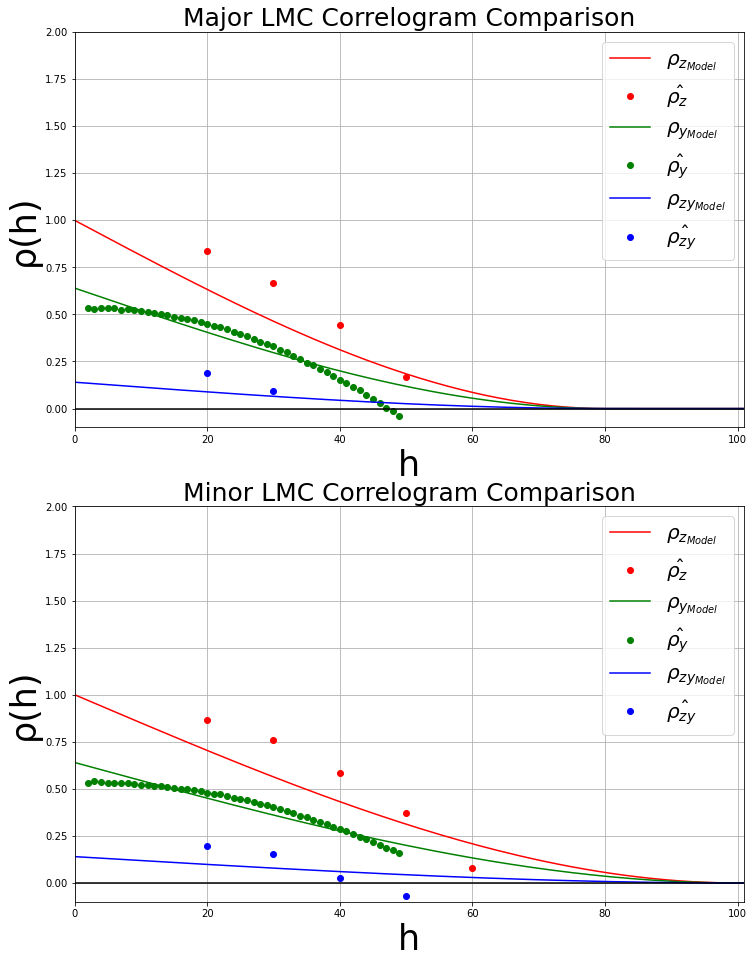

In [204]:
labels_MM = ['$ρ_{z_{Model}}$', '$ρ_{y_{Model}}$', '$ρ_{zy_{Model}}$']
varg_type = 2  # See Correlogram Functions
k = 0
cy = np.zeros(shape=(LENGTH + 1))
cz_True = np.zeros(shape=(LENGTH + 1))
czy = np.zeros(shape=(LENGTH + 1))
nstruct = dict_secondary_LMC["nstruct"]
fig, axes = plt.subplots(2, 1, figsize=(12, 16))
for s,Dir in enumerate(["Major","Minor"]):
    for h in range(0, 101):

        cy[h]= C_Y_alternate(np.matrix(h), np.matrix(h), varg_type,dict_secondary_LMC, nstruct )

        cz_True[h] = C_Z_alternate(np.matrix(h), np.matrix(h),varg_type,dict_primary_LMC, nstruct )

        czy[h]= C_ZY(np.matrix(h), np.matrix(h),varg_type,dict_cross_LMC, nstruct)

        H[h] = h
    MM_vargs = [cz_True, cy, czy]
    
    for i in range(0, 3):
        axes[s].plot(H, MM_vargs[i], color=colors[i], label=labels_MM[i])
        if (i + 1) < 4:
            var = locals()["varc_{}".format(i + 1)]
            axes[s].plot(
                var["Lag Distance"][
                    var["Variogram Index"] == (varg_type - 1)
                ],
                Sill_vals[i]
                - var["Variogram Value"][
                    var["Variogram Index"] == (varg_type - 1)
                ],
                "o",
                color=colors[i],
                label=labels_1[i],
            )

    axes[s].plot(H, ones, color="Black")
    axes[s].grid()
    axes[s].set_xlim(0, 101)
    axes[s].set_ylim(-0.1, 2)
    axes[s].set_ylabel("\u03C1(h)", size=35)
    axes[s].set_xlabel("h", size=35)
    axes[s].set_title(
        Dir+" LMC Correlogram Comparison",
        size=25,
    )
    axes[s].legend(loc="best", prop={"size": 20})
    varg_type = varg_type + 1
    k += 1

# Cokriging

In [265]:
Mean_Z = np.average(Primary["Primary"])
STD_Z = 1.0
print(Mean_Z)
print(STD_Z)

-1.9984014443252817e-17
1.0


In [266]:
Mean_Y = np.average(Primary["Secondary"])
STD_Y =  1.0
print(Mean_Y)
print(STD_Y)

-3.044786645034492e-16
1.0


## KDTree

In [267]:
from sklearn.neighbors import KDTree

In [268]:
def ech_data_kdtree(x,y,z,ech) :
    """
    Fonction qui ré-echantillonne avant l'utilisation d'un KD Tree
    """
    low_quality_secondary = pd.DataFrame()
    x_ech = x[::ech]
    low_quality_secondary["x"] = x_ech
    y_ech = y[::ech]
    low_quality_secondary["y"] = y_ech
    z_ech = z[::ech]
    low_quality_secondary["z"] = z_ech
    
    return low_quality_secondary,x_ech,y_ech,z_ech

In [269]:
##MATRICES NON ECHANTILLONEE
x = Secondary["X"].values
y = Secondary["Y"].values
z = Secondary["Secondary"].values

# MATRICES ECHANTILLONEES
ech = 1
df_kriging,x_ech,y_ech,z_ech = ech_data_kdtree(x,y,z,ech)

In [270]:
Primary.head()

X   Y  original_z  original_zy   Primary  Secondary
0  0   0   -0.005196     0.389179 -0.869635  -0.324669
1  0  10   -0.011120     0.049883 -0.888949  -1.098621
2  0  20    0.104180     0.041148 -0.512981  -1.118546
3  0  30   -0.125674     0.301680 -1.262488  -0.524260
4  0  40    0.074539     0.349682 -0.609634  -0.414765

In [271]:
#Constitution d'un KD Tree, Primary data
datafl_XY = Primary[["X", "Y"]].values
datafl = Primary
tree = KDTree(datafl_XY)
Pred_grid_xy = np.matrix([x, y]).T

#Constitution d'un KD Tree, Secondary data
datafl_sec = Secondary
datafl_XY_2nd = Secondary[["X", "Y"]].values
tree_2nd = KDTree(datafl_XY_2nd)

### Primary Data Search for Kriging

In [272]:
k_p = 60 # number of data to use
X_Y = np.zeros((len(x), k_p, 2))
X_Y_Star = np.zeros((len(x), k_p, 2))
closematrix_Primary = np.zeros((len(x), k_p))
closematrix_Secondary = np.zeros((len(x), k_p))
neardistmatrix = np.zeros((len(x), k_p))

for i in range(0, len(x)):
    nearest_dist, nearest_ind = tree.query(Pred_grid_xy[i : i + 1, :], k=k_p)
    a = nearest_ind.ravel()
    group = datafl.iloc[a, :]
    closematrix_Primary[i, :] = group["Primary"]
    closematrix_Secondary[i, :] = group["Secondary"]
    neardistmatrix[i, :] = nearest_dist
    X_Y[i, :, :] = group[["X", "Y"]]

### Secondary Data Search for Kriging

In [273]:
X_Y_2nd = np.zeros((len(x), k_p, 2))
closematrix_Secondary_2nd = np.zeros((len(x), k_p))
for i in range(0, len(x)):
    nearest_dist, nearest_ind = tree_2nd.query(
        Pred_grid_xy[i : i + 1, :], k=k_p
    )
    a = nearest_ind.ravel()
    group = datafl_sec.iloc[a, :]
    closematrix_Secondary_2nd[i, :] = group["Secondary"]
    X_Y_2nd[i, :, :] = group[["X", "Y"]]

### Recap des models de variogrammes

In [274]:
print("Premier Correlogram") 
print(dict_primary)

Premier Correlogram
{'a_max': [71.0], 'a_min': [86.0], 'cc': [1.46], 'vtype': array([1]), 'nstruct': 1}


In [275]:
print("Second Correlogram") 
print(dict_secondary)

Second Correlogram
{'a_max': [76.0], 'a_min': [106.0], 'cc': [0.63], 'vtype': array([1]), 'nstruct': 1}


In [276]:
print("Cross Correlogram") 
print(dict_cross)

Cross Correlogram
{'a_max': [40.0], 'a_min': [46.0], 'cc': [0.66], 'vtype': array([1]), 'nstruct': 1}


In [277]:
print("LMC Correlogram ") 
print(dict_LMC)

LMC Correlogram 
{'a_max': [70.0, 100.0, 0.0], 'a_min': [95.0, 1.0], 'vtype': array([1, 3]), 'nstruct': 2}


## Full Cokriging

In [278]:
cz = np.zeros(shape=(k_p, k_p))
czy = np.zeros(shape=(k_p, k_p))
czy_2 = np.zeros(shape=(k_p, k_p))
cy = np.zeros(shape=(k_p, k_p))
s_m = 0
sm_idx = []
est_Full_CCK = np.zeros(shape=(len(x)))
for z in tqdm(range(0, len(x))):
    Kriging_Matrix = np.zeros(shape=((k_p * 2), (k_p * 2)))
    # C_ZZ
    cz = C_Z_alternate(X_Y[z, :, :], X_Y[z, :, :],0,dict_primary, nstruct = 1, Azimuth = 0)
    # C_ZY
    czy = C_ZY(X_Y[z, :, :], X_Y_2nd[z, :, :], 0,dict_cross, nstruct = 1, Azimuth = 0)
    czy_2 = C_ZY(X_Y_2nd[z, :, :], X_Y[z, :, :], 0,dict_cross, nstruct = 1, Azimuth = 0)
    # C_YY
    cy = C_Y_alternate(X_Y_2nd[z, :, :], X_Y_2nd[z, :, :], 0, dict_secondary, nstruct = 1, Azimuth = 0 )
    Kriging_Matrix = np.vstack(
        (np.hstack((cz, czy)), np.hstack((czy.T, cy)))
    )
    # print(Kriging_Matrix)
    # Set up Right Hand Sides
    r = np.zeros(shape=(k_p * 2))
    k_p_weights = np.zeros(shape=(k_p * 2))
    # RHS #C_z*
    r[0:k_p] = C_Z_alternate(X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k_p, 1)), 1,dict_primary, nstruct = 1, Azimuth = 0 )
    # RHS #C_zy*
    r[k_p : k_p * 2] = C_ZY(
        X_Y_2nd[z, :, :], np.tile(Pred_grid_xy[z], (k_p, 1)), 1, dict_cross, nstruct = 1, Azimuth = 0)
    # Calculate Kriging Weights
    try:
        k_p_weights = np.dot(np.linalg.inv(Kriging_Matrix), r)
    except:
        s_m = s_m + 1
        sm_idx.append(z)
        k_p_weights = np.dot(scipy.linalg.pinv(Kriging_Matrix), r)
    # Start Est at zero
    est_Full_CCK[z] = 0
    # add in mean_z
    est_Full_CCK[z] = est_Full_CCK[z] + Mean_Z
    for i in range(0, k_p):
        # add in Z_i
        est_Full_CCK[z] = (
            est_Full_CCK[z]
            + k_p_weights[i] * (closematrix_Primary[z, i] - Mean_Z) / STD_Z
        )
        # add in Y_i
        est_Full_CCK[z] = (
            est_Full_CCK[z]
            + k_p_weights[i + k_p]
            * (closematrix_Secondary_2nd[z, i] - Mean_Y)
            / STD_Y
        )
print("There where {} Singular Matrices".format(s_m))

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 494.85it/s]

There where 0 Singular Matrices


## Full Cokriging with LMC

In [279]:
cz = np.zeros(shape=(k_p, k_p))
czy = np.zeros(shape=(k_p, k_p))
czy_2 = np.zeros(shape=(k_p, k_p))
cy = np.zeros(shape=(k_p, k_p))
s_m = 0
sm_idx = []
est_Full_CCK_LMC = np.zeros(shape=(len(x)))
nstruct = 1

dict_secondary_LMC
dict_primary_LMC
dict_cross_LMC

for z in tqdm(range(0, len(x))):
    Kriging_Matrix = np.zeros(shape=((k_p * 2), (k_p * 2)))
    # C_ZZ
    cz = C_Z_alternate(X_Y[z, :, :], X_Y[z, :, :],0,dict_primary_LMC, nstruct ,Azimuth = 0)
    # C_ZY
    czy = C_ZY(X_Y[z, :, :], X_Y_2nd[z, :, :], 0,dict_cross_LMC, nstruct ,Azimuth = 0)
    czy_2 = C_ZY(X_Y_2nd[z, :, :], X_Y[z, :, :], 0,dict_cross_LMC, nstruct ,Azimuth = 0)
    # C_YY
    cy = C_Y_alternate(X_Y_2nd[z, :, :], X_Y_2nd[z, :, :], 0, dict_secondary_LMC, nstruct ,Azimuth = 0 )
    Kriging_Matrix = np.vstack(
        (np.hstack((cz, czy)), np.hstack((czy.T, cy)))
    )
    # print(Kriging_Matrix)
    # Set up Right Hand Sides
    r = np.zeros(shape=(k_p * 2))
    k_p_weights = np.zeros(shape=(k_p * 2))
    # RHS #C_z*
    r[0:k_p] = C_Z_alternate(X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k_p, 1)), 1,dict_primary_LMC, nstruct ,Azimuth = 0 )
    # RHS #C_zy*
    r[k_p : k_p * 2] = C_ZY(
        X_Y_2nd[z, :, :], np.tile(Pred_grid_xy[z], (k_p, 1)), 1, dict_cross_LMC, nstruct ,Azimuth = 0)
    # Calculate Kriging Weights
    try:
        k_p_weights = np.dot(np.linalg.inv(Kriging_Matrix), r)
    except:
        s_m = s_m + 1
        sm_idx.append(z)
        k_p_weights = np.dot(scipy.linalg.pinv(Kriging_Matrix), r)
    # Start Est at zero
    est_Full_CCK_LMC[z] = 0
    # add in mean_z
    est_Full_CCK_LMC[z] = est_Full_CCK_LMC[z] + Mean_Z
    for i in range(0, k_p):
        # add in Z_i
        est_Full_CCK_LMC[z] = (
            est_Full_CCK_LMC[z]
            + k_p_weights[i] * (closematrix_Primary[z, i] - Mean_Z) / STD_Z
        )
        # add in Y_i
        est_Full_CCK_LMC[z] = (
            est_Full_CCK_LMC[z]
            + k_p_weights[i + k_p]
            * (closematrix_Secondary_2nd[z, i] - Mean_Y)
            / STD_Y
        )
print("There where {} Singular Matrices".format(s_m))

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 511.56it/s]

There where 0 Singular Matrices


## Intrinsic Collocated Cokriging - MM2

In [280]:
k = k_p
s_m = 0
sm_idx = []
cz = np.zeros(shape=(k, k))
czy = np.zeros(shape=(k, k))
cy = np.zeros(shape=(k, k))
est_icck_MM2 = np.zeros(shape=(len(x)))
for z in tqdm(range(0, len(x))):
    Kriging_Matrix = np.zeros(shape=((k * 2 + 1), (k * 2 + 1)))
    # C_ZZ
    # 1
    # C_Z_MM2(X_Y[z, :, :], X_Y[z, :, :], 0, corr)
        
    cz = C_Z_MM2(X_Y[z, :, :], X_Y[z, :, :], 0,corr,dict_secondary, dict_scalling )
    # C_ZY
    # 2,#3
    # corr * C_Y(X_Y[z, :, :], X_Y[z, :, :], 0)
    czy = C_Y_alternate(X_Y[z, :, :], X_Y[z, :, :], 0,
                                       dict_secondary, nstruct = 1)
    # C_YY
    # 4
    # C_Y(X_Y[z, :, :], X_Y[z, :, :], 0)
    cy = C_Y_alternate(X_Y[z, :, :], X_Y[z, :, :], 0,
                                       dict_secondary, nstruct = 1)
    # Set up Right Hand Side
    # print(Kriging_Matrix.reshape(((2*k)+1),((2*k)+1)))
    Kriging_Matrix[0 : k * 2, 0 : k * 2] = np.vstack(
        (np.hstack((cz, czy)), np.hstack((czy.T, cy)))
    )
    r = np.zeros(shape=(k * 2) + 1)
    k_weights = r
    # RHS #C_z*
    # 5
    r[0:k] = C_Z_MM2(
        X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)), 1, corr,dict_secondary, dict_scalling )
    # RHS #C_yz*
    # 6
    r[k : k * 2] = (
        C_Y_alternate(X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)), 1,
                                       dict_secondary, nstruct = 1) * corr
    )
    # RHS corr
    # 7
    r[k * 2] = corr
    # c_zy
    # 8
    Kriging_Matrix[k * 2, 0:k] = (
        C_Y_alternate(X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)),1,
                                       dict_secondary, nstruct = 1) * corr
    )
    Kriging_Matrix[0:k, k * 2] = (
        C_Y_alternate(X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)),1,
                                       dict_secondary, nstruct = 1) * corr
    )
    # c_y
    # 9
    Kriging_Matrix[k * 2, k : k * 2] = C_Y_alternate(
        X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)),1,
                                       dict_secondary, nstruct = 1)
    
    Kriging_Matrix[k : k * 2, k * 2] = C_Y_alternate(
        X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)),1,
                                       dict_secondary, nstruct = 1)
    
    Kriging_Matrix[k * 2, k * 2] = 1
    # Kriging_Matrix.reshape(((2*k)+1),((2*k)+1))
    # Calculate Kriging Weights
    try:
        k_weights = np.dot(np.linalg.inv(Kriging_Matrix), r)
    except:
        s_m = s_m + 1
        sm_idx.append(z)
        k_weights = np.dot(scipy.linalg.pinv(Kriging_Matrix), r)
    # Start Est at zero
    est_icck_MM2[z] = 0
    # add in mean_z
    est_icck_MM2[z] = est_icck_MM2[z] + Mean_Z
    # add in the Y_0
    est_icck_MM2[z] = (
        est_icck_MM2[z]
        + k_weights[k * 2] * (datafl_sec["Secondary"][z] - Mean_Y) / STD_Y
    )
    for i in range(0, k):
        # add in Z_i
        est_icck_MM2[z] = (
            est_icck_MM2[z]
            + k_weights[i] * (closematrix_Primary[z, i] - Mean_Z) / STD_Z
        )
        # add in Y_i
        est_icck_MM2[z] = (
            est_icck_MM2[z]
            + k_weights[i + k]
            * (closematrix_Secondary[z, i] - Mean_Y)
            / STD_Y
        )
print("There where {} Singular Matrices".format(s_m))

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 366.32it/s]

There where 0 Singular Matrices


##  Mise en place des résultats

In [281]:
ktypes = ["SCK","LMC_SCK","ICC_MM2"]
k_est = [est_Full_CCK,
         est_Full_CCK_LMC,
         est_icck_MM2
]
ktypes_vals_dict = {}
dict_types = {}
j = 0
for i in ktypes:
    
    ktypes_vals_dict[i] = {
        "Estimate": k_est[j],
        "Mean": np.mean(k_est[j]),
        "Variance": np.var(k_est[j]),
    }
    
    df_kriging["NS_Estimate_"+i] = ktypes_vals_dict[i]["Estimate"]
    df_kriging["Estimate_"+i] = ktypes_vals_dict[i]["Estimate"]* original_std_z + original_mean_z
    j = j + 1

##  Affichage des différents cokrigeage

### MM2 vs SCK

Text(0.5, 1.0, 'SCK\nZ : 1.46 Spherical \nY : 0.63 Spherical \nZY : 0.66 Spherical \n')

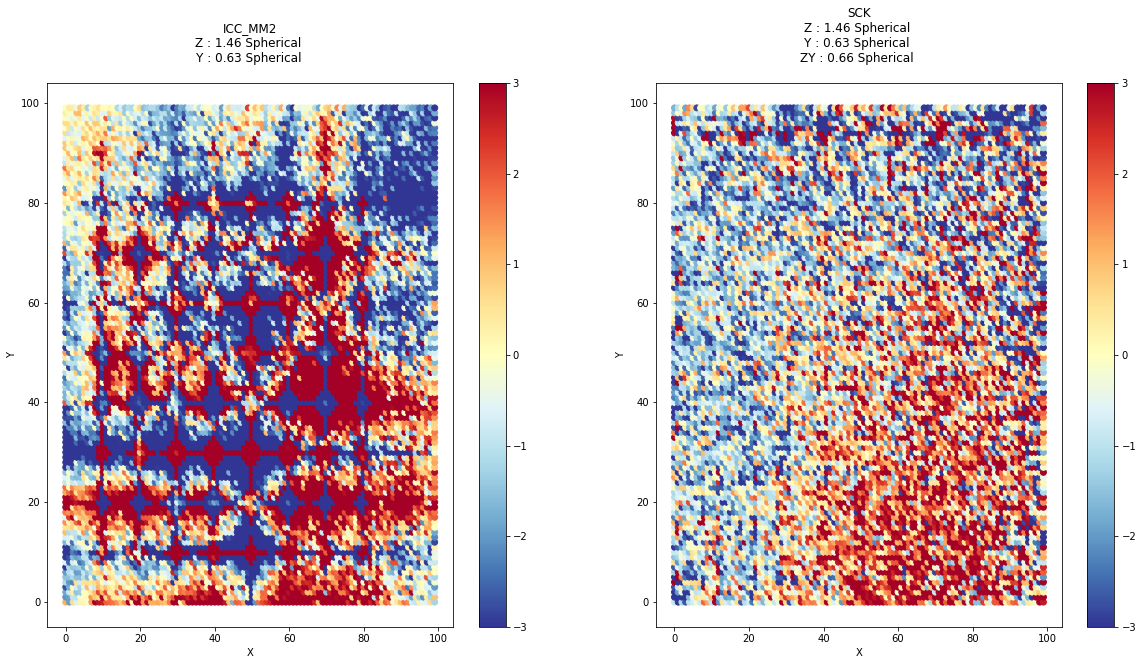

In [282]:
fig,ax=plt.subplots(1,2, figsize = (20,10))

types = "ICC_MM2"
Z = df_kriging["NS_Estimate_"+types].values
img0 = ax[0].scatter(x_ech, y_ech,c = Z,vmin = -3, vmax = 3, cmap = "RdYlBu_r")
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
# Title name Z / Y 
TITLE = ""
count = 1
for cc,vtype in zip(dict_primary["cc"],dict_primary["vtype"]) :
    model = MODEL_name[vtype]
    if (count == 1) & (len(dict_primary["cc"]) >= 2 ):
        a = 1
        TITLE += f"Z : {cc} {model} +" 
    elif len(dict_primary["cc"])<2 or count == len(dict_primary["cc"]) :
        TITLE += f"Z : {cc} {model} \n"
    else : 
        TITLE += f" {cc} {model} +"
    count += 1
    
count = 1
for cc,vtype in zip(dict_secondary["cc"],dict_secondary["vtype"]) :
    model = MODEL_name[vtype]
    if (count == 1) & (len(dict_secondary["cc"]) >= 2 ):
        TITLE += f"Y : {cc} {model} +" 
    elif (len(dict_secondary["cc"])<2) or (count == len(dict_secondary["cc"])):
        TITLE += f"Y : {cc} {model} \n"                 
    else : 
        TITLE += f"{cc} {model} +"
    count += 1
    
ax[0].set_title(types +'\n'+TITLE)
fig.colorbar(img0, ax=ax[0])

# ----------------------------------------------------------------------------------------------------------
types = "SCK"
Z = df_kriging["NS_Estimate_"+types].values
img0 = ax[1].scatter(x_ech, y_ech,c = Z,vmin = -3, vmax = 3, cmap = "RdYlBu_r")
ax[1].set_xlabel('X')
ax[1].set_ylabel('Y')
fig.colorbar(img0, ax=ax[1])

# Title name Z / Y / ZY
TITLE = ""
count = 1
for cc,vtype in zip(dict_primary["cc"],dict_primary["vtype"]) :
    model = MODEL_name[vtype]
    if (count == 1) & (len(dict_primary["cc"]) >= 2 ):
        a = 1
        TITLE += f"Z : {cc} {model} +" 
    elif len(dict_primary["cc"])<2 or count == len(dict_primary["cc"]) :
        TITLE += f"Z : {cc} {model} \n"
    else : 
        TITLE += f" {cc} {model} +"
    count += 1
    
count = 1
for cc,vtype in zip(dict_secondary["cc"],dict_secondary["vtype"]) :
    model = MODEL_name[vtype]
    if (count == 1) & (len(dict_secondary["cc"]) >= 2 ):
        TITLE += f"Y : {cc} {model} +" 
    elif (len(dict_secondary["cc"])<2) or (count == len(dict_secondary["cc"])):
        TITLE += f"Y : {cc} {model} \n"                 
    else : 
        TITLE += f"{cc} {model} +"
    count += 1
    
count = 1
for cc,vtype in zip(dict_cross["cc"],dict_cross["vtype"]) :
    model = MODEL_name[vtype]
    if (count == 1) & (len(dict_cross["cc"]) >= 2) :
        TITLE += f"ZY : {cc} {model} +" 
    elif len(dict_cross["cc"])<2 or count == len(dict_cross["cc"]):
        TITLE += f"ZY : {cc} {model} \n"                 
    else : 
        TITLE += f"{cc} {model} +"
    count += 1
    
ax[1].set_title(types +'\n'+TITLE)

### LMC

Text(0.5, 1.0, 'LMC_SCK\nZ : 0.84 Spherical +Z : 0.15 Gaussien \nY : 0.29 Spherical +Y : 0.3 Gaussien \nZY : 0.23 Spherical +ZY : 0.0 Gaussien \n')

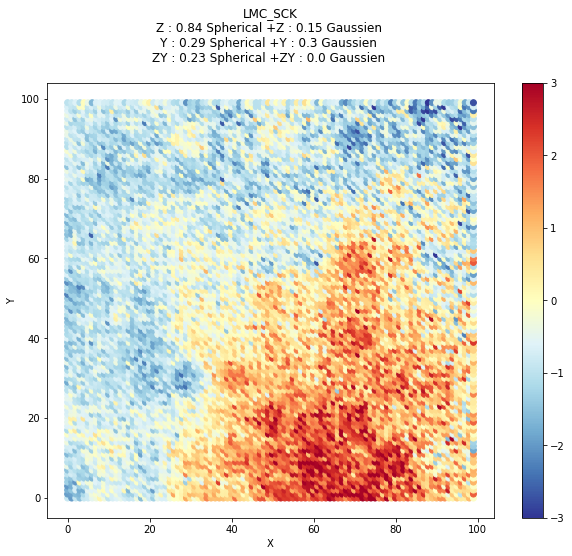

In [283]:
# Aperçu de la zone d'étude 
fig,ax=plt.subplots(1,1, figsize = (10,8))
types = "LMC_SCK"
Z = df_kriging["NS_Estimate_"+types].values
img0 = ax.scatter(x_ech, y_ech,c = Z,vmin = -3, vmax = 3, cmap = "RdYlBu_r")
ax.set_xlabel('X')
ax.set_ylabel('Y')
fig.colorbar(img0, ax=ax)

# Title name Z / Y / ZY
TITLE = ""
count = 1
for cc,vtype in zip(dict_primary_LMC["cc"],dict_primary_LMC["vtype"]) :
    model = MODEL_name[vtype]
    if (count == 1) & (len(dict_primary_LMC["cc"]) >= 2 ):
        a = 1
        TITLE += f"Z : {cc} {model} +" 
    elif len(dict_primary_LMC["cc"])<2 or count == len(dict_primary_LMC["cc"]) :
        TITLE += f"Z : {cc} {model} \n"
    else : 
        TITLE += f" {cc} {model} +"
    count += 1
    
count = 1
for cc,vtype in zip(dict_secondary_LMC["cc"],dict_secondary_LMC["vtype"]) :
    model = MODEL_name[vtype]
    if (count == 1) & (len(dict_secondary_LMC["cc"]) >= 2 ):
        TITLE += f"Y : {cc} {model} +" 
    elif (len(dict_secondary_LMC["cc"])<2) or (count == len(dict_secondary_LMC["cc"])):
        TITLE += f"Y : {cc} {model} \n"                 
    else : 
        TITLE += f"{cc} {model} +"
    count += 1
    
count = 1
for cc,vtype in zip(dict_cross_LMC["cc"],dict_cross_LMC["vtype"]) :
    model = MODEL_name[vtype]
    if (count == 1) & (len(dict_cross_LMC["cc"]) >= 2) :
        TITLE += f"ZY : {cc} {model} +" 
    elif len(dict_cross_LMC["cc"])<2 or count == len(dict_cross_LMC["cc"]):
        TITLE += f"ZY : {cc} {model} \n"                 
    else : 
        TITLE += f"{cc} {model} +"
    count += 1
    
ax.set_title(types +'\n'+TITLE)

#  Comparaison des Cokriging à la fonction initiale 

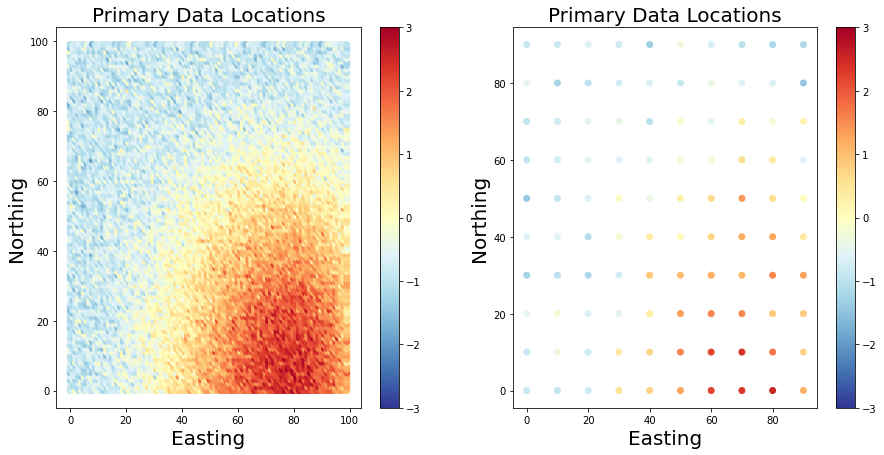

In [225]:
#Primary_truth Data Data
x, y = np.mgrid[0:0.5 * np.pi:100j, 0:0.5 * np.pi:100j]
np.random.seed(21)
mu, sigma = 0, 0.1
_field_z_truth  = fun_Primary(x,y,mu,sigma,size = 100)

Primary_truth = pd.DataFrame()
Primary_truth["X"] = xx_y.reshape(-1)
Primary_truth["Y"] = yy_y.reshape(-1)
Primary_truth["original_z"] = _field_z_truth.reshape(-1)
Primary_truth["Primary"] = (Primary_truth["original_z"] - Primary_truth["original_z"].mean()) / Primary_truth["original_z"].std()

f, ax = plt.subplots(1,2, figsize = (15,7))

img0 = ax[0].scatter(Primary_truth["X"], Primary_truth["Y"], c=Primary_truth["Primary"].values,
                     vmin = -3, vmax = 3, cmap = "RdYlBu_r")
ax[0].set_title("Primary Data Locations", size=20)
ax[0].set_xlabel("Easting", size=20)
ax[0].set_ylabel("Northing", size=20)
fig.colorbar(img0, ax=ax[0])

img0 = ax[1].scatter(Primary["X"], Primary["Y"], c=Primary["Primary"].values,
                     vmin = -3, vmax = 3, cmap = "RdYlBu_r")
ax[1].set_title("Primary Data Locations", size=20)
ax[1].set_xlabel("Easting", size=20)
ax[1].set_ylabel("Northing", size=20)
fig.colorbar(img0, ax=ax[1])


### Différence entre LMC / fonction initiale

Text(0.5, 1.0, "Différence entre les valeurs issus d'un cokriging LMC et de la fonction initiale \n RMSE = 0.25")

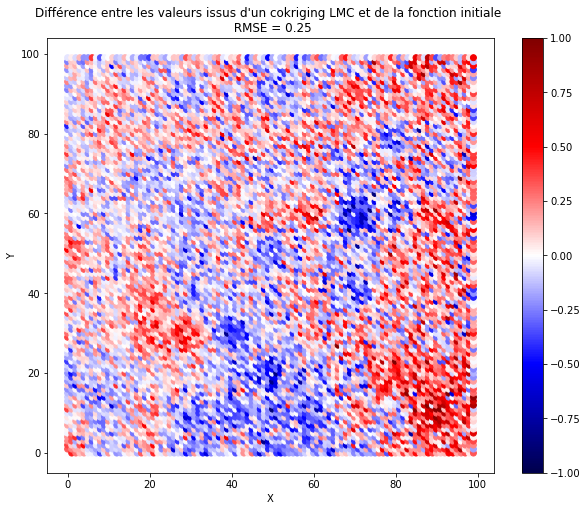

In [284]:
# Aperçu de la zone d'étude 
fig,ax=plt.subplots(1,1, figsize = (10,8))
types = "LMC_SCK"
#Différence entre les valeurs originales et non transformées
Z_ck = df_kriging["Estimate_"+types].values 
Z_truth = Primary_truth["original_z"].values
Z = Z_truth - Z_ck
RMSE = np.sqrt(mean_squared_error(Z_ck,Z_truth))
img0 = ax.scatter(x_ech, y_ech,c = Z,vmin = -1, vmax = 1, cmap = "seismic")
ax.set_xlabel('X')
ax.set_ylabel('Y')
fig.colorbar(img0, ax=ax)
Title = "Différence entre les valeurs issus d'un cokriging LMC et de la fonction initiale \n RMSE = " + "{:.2f}".format(RMSE)
ax.set_title(Title)